In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 116]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/coronal/t1c", t2f_dir="PED_Sliced/coronal/t2f", seg_dir="PED_Sliced/coronal/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



6048
189
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        # up6 = self.up6(c5)
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [7]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [8]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [9]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_PED_coronal_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_PED_coronal_comb.pth")

    
    return model


In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


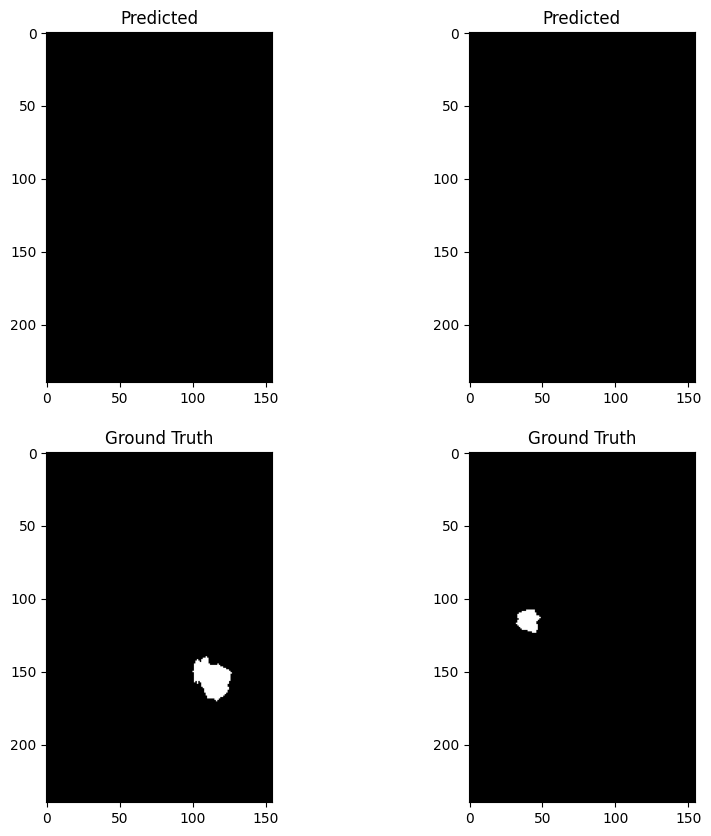

100%|██████████| 189/189 [10:08<00:00,  3.22s/it]



Average Training Loss: 0.28420122760155847

Average Training DSC: [0.92329988 0.4619709  0.65874266 0.        ]
Average Training ASSD: [ 21.38532781 194.76653439 115.02445843 362.        ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


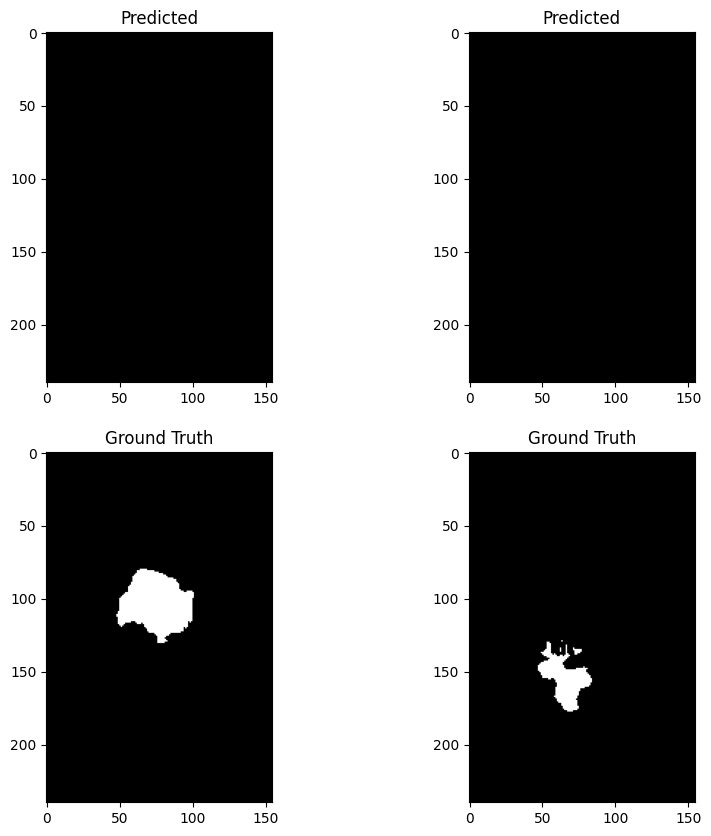

100%|██████████| 48/48 [02:42<00:00,  3.39s/it]


Average Validation Loss: 0.0962012899108231

Average Validation DSC: [0.98526587 0.43308738 0.73104745 0.        ]
Average Validation ASSD: [  3.74103227 205.2223669   97.36082176 362.        ]
Epoch 2/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


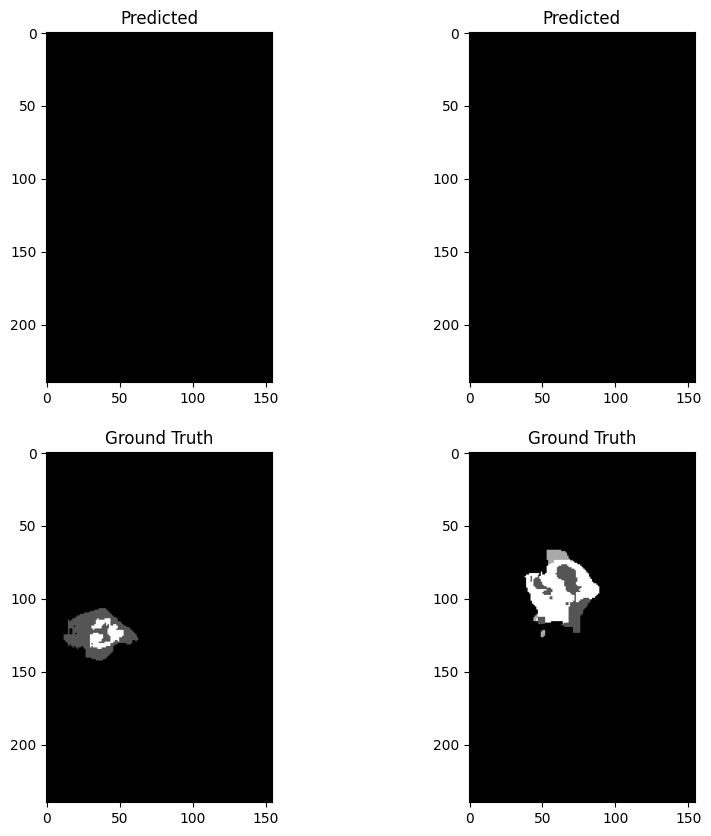

100%|██████████| 189/189 [11:14<00:00,  3.57s/it]



Average Training Loss: 0.07260956209172648

Average Training DSC: [0.99031847 0.38711552 0.74107705 0.18339776]
Average Training ASSD: [  1.7529402  159.10128314  92.29881957 192.04039615]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


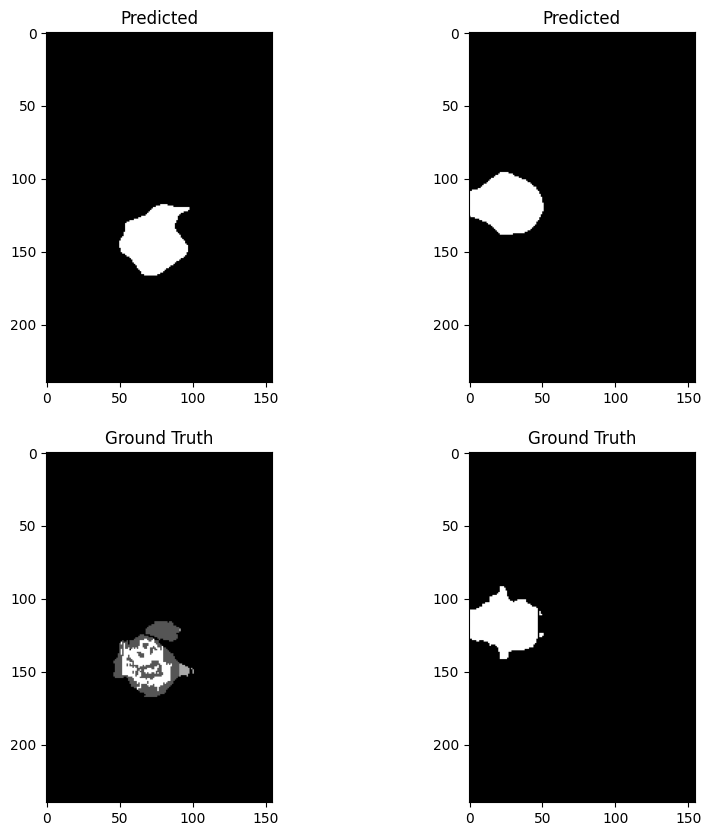

100%|██████████| 48/48 [02:36<00:00,  3.26s/it]


Average Validation Loss: 0.0583006648812443

Average Validation DSC: [0.99380003 0.4233868  0.72938368 0.38745404]
Average Validation ASSD: [  0.7420973  181.08074313  97.96310764  53.7968573 ]
Epoch 3/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


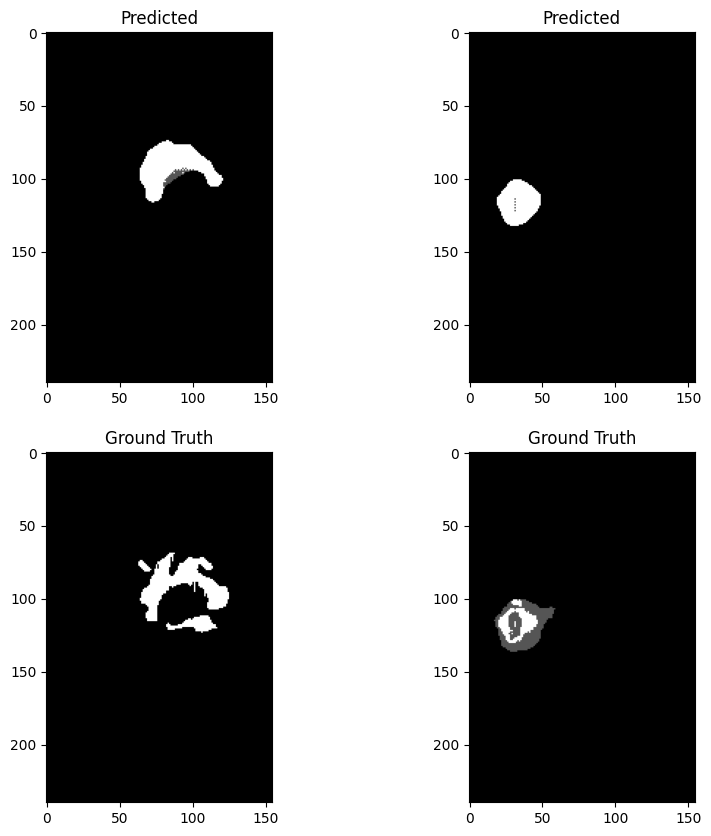

100%|██████████| 189/189 [11:31<00:00,  3.66s/it]



Average Training Loss: 0.05595256530103229

Average Training DSC: [0.99403172 0.43292415 0.74966931 0.34920349]
Average Training ASSD: [  0.70673583 136.2849955   90.61970899  59.28289112]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


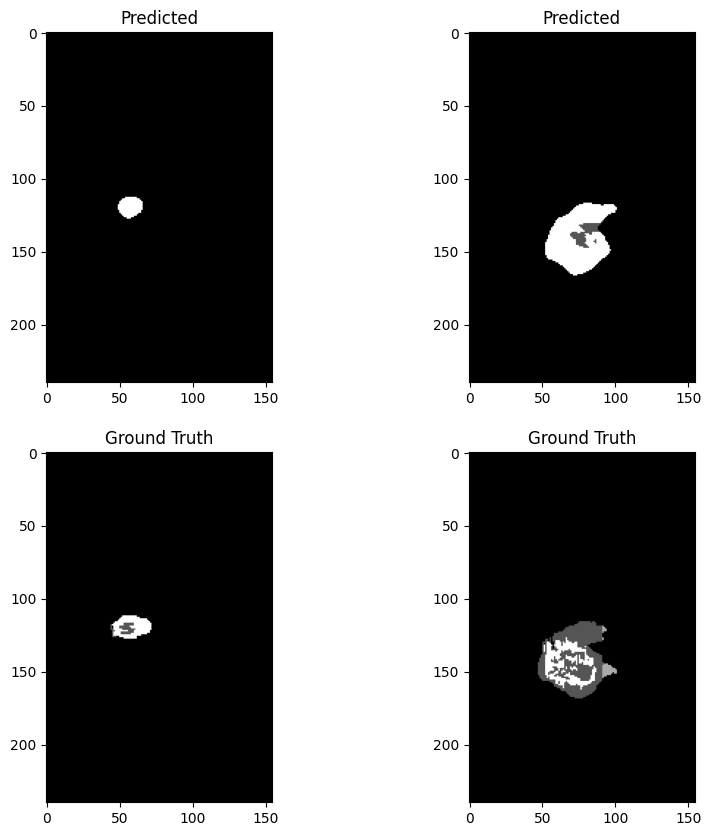

100%|██████████| 48/48 [02:36<00:00,  3.27s/it]


Average Validation Loss: 0.0508288301837941

Average Validation DSC: [0.99475096 0.43072472 0.73104745 0.30891687]
Average Validation ASSD: [  0.58943001 114.95810106  97.36082176  59.07399894]
Epoch 4/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


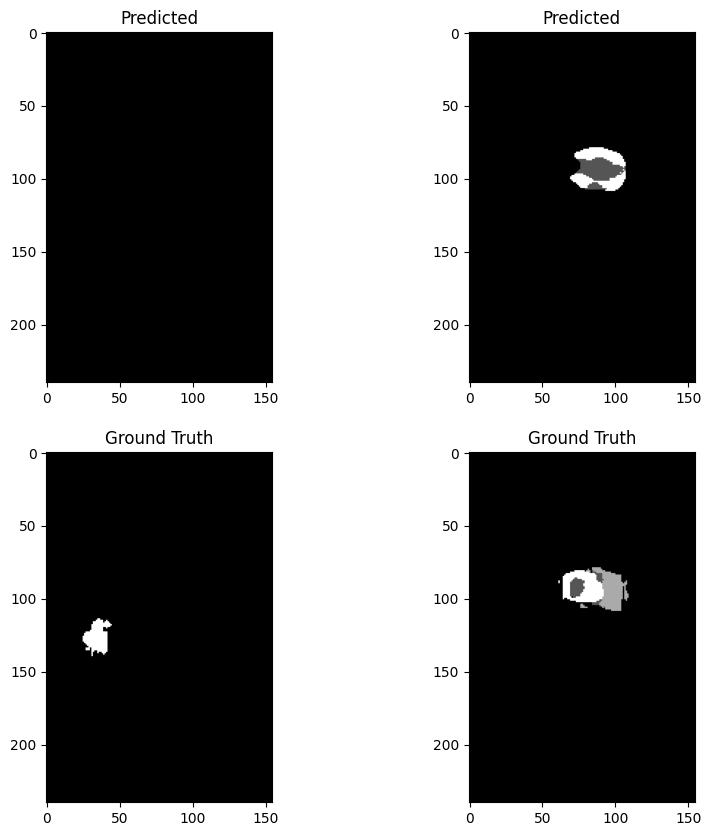

100%|██████████| 189/189 [11:27<00:00,  3.64s/it]



Average Training Loss: 0.04790456119983915

Average Training DSC: [0.99544125 0.47029617 0.74966931 0.37328416]
Average Training ASSD: [  0.52948218 122.95253797  90.61970899  46.63651629]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


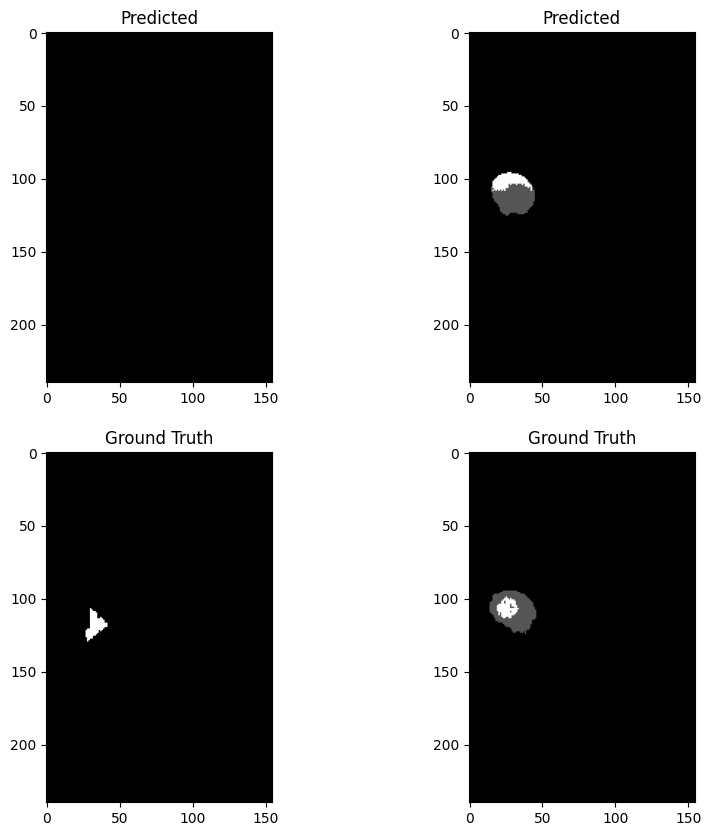

100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


Average Validation Loss: 0.04618470106894771

Average Validation DSC: [0.99589833 0.44460938 0.72938368 0.33247047]
Average Validation ASSD: [  0.49296849 105.82698465  97.96310764  56.86409033]
Epoch 5/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


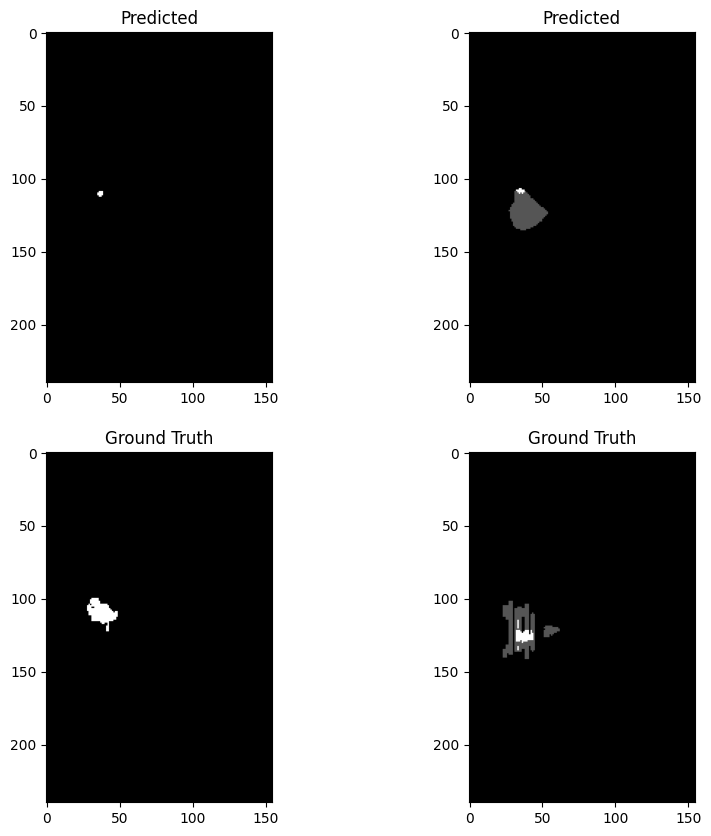

100%|██████████| 189/189 [11:33<00:00,  3.67s/it]



Average Training Loss: 0.04337537189127592

Average Training DSC: [0.99614179 0.46115872 0.74966931 0.39277605]
Average Training ASSD: [  0.43944854 111.88687489  90.61970899  40.89703221]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


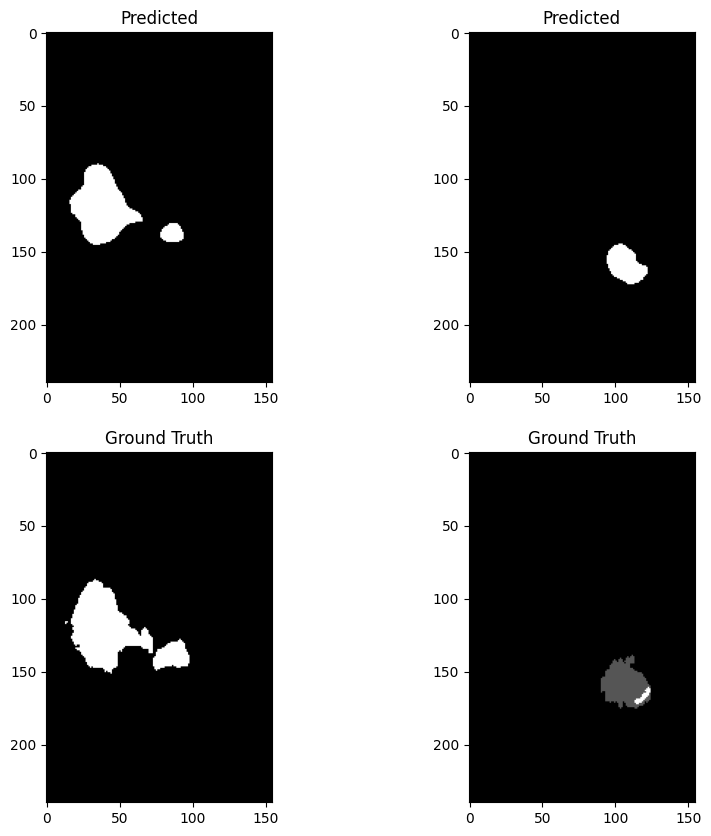

100%|██████████| 48/48 [02:44<00:00,  3.43s/it]


Average Validation Loss: 0.041940007669230304

Average Validation DSC: [0.99608026 0.50587881 0.73104745 0.38897959]
Average Validation ASSD: [ 0.45608218 90.52086995 97.36082176 40.8497162 ]
Epoch 6/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


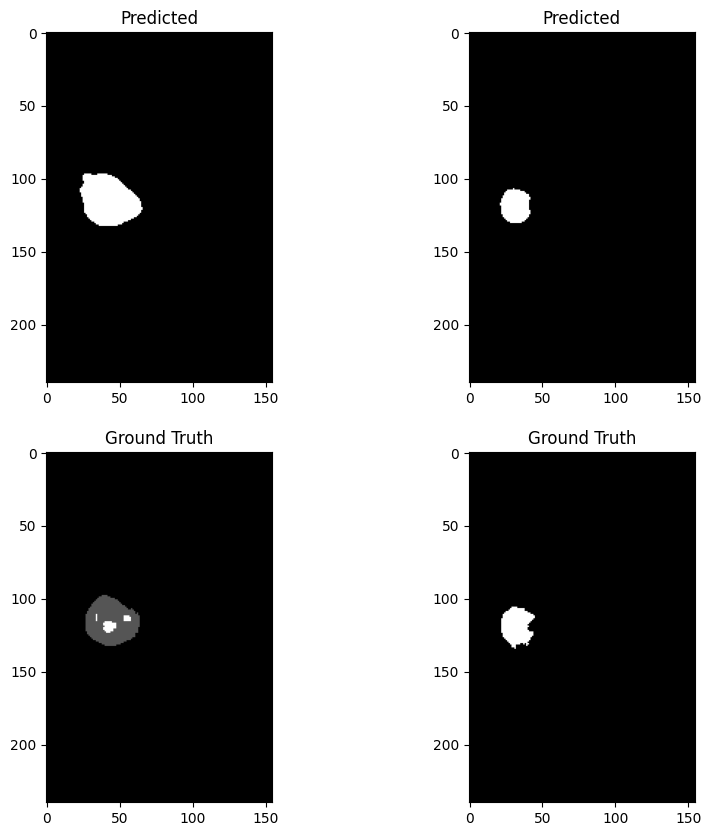

100%|██████████| 189/189 [11:30<00:00,  3.66s/it]



Average Training Loss: 0.03952851699339965

Average Training DSC: [0.99651521 0.5039636  0.74778041 0.40577483]
Average Training ASSD: [ 0.39365506 98.76910681 90.12870721 36.00655427]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


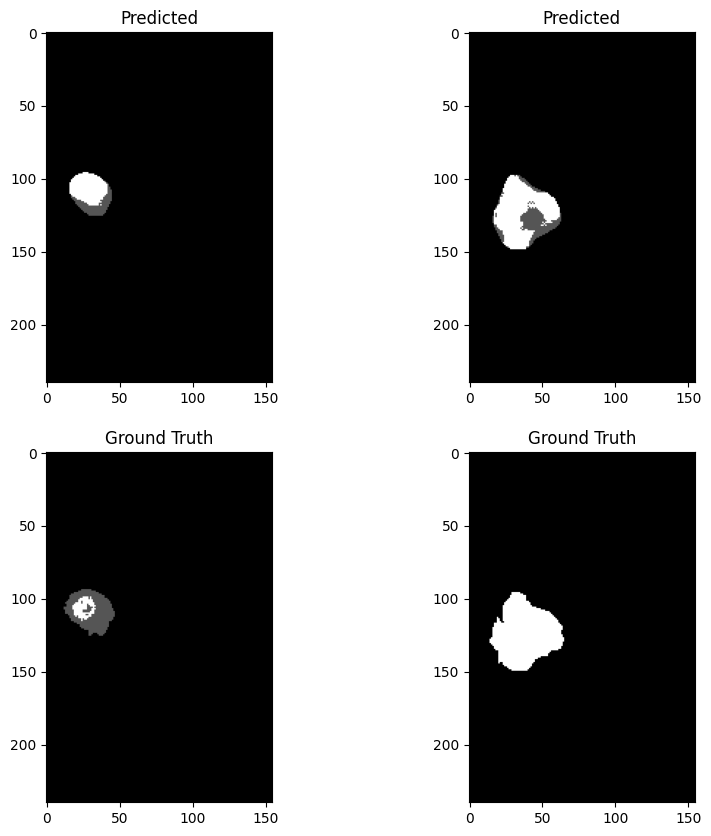

100%|██████████| 48/48 [02:41<00:00,  3.37s/it]


Average Validation Loss: 0.03698339262822022

Average Validation DSC: [0.99680503 0.50922509 0.71634995 0.45777581]
Average Validation ASSD: [ 0.33890131 94.5874866  97.13964255 29.02066651]
Epoch 7/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


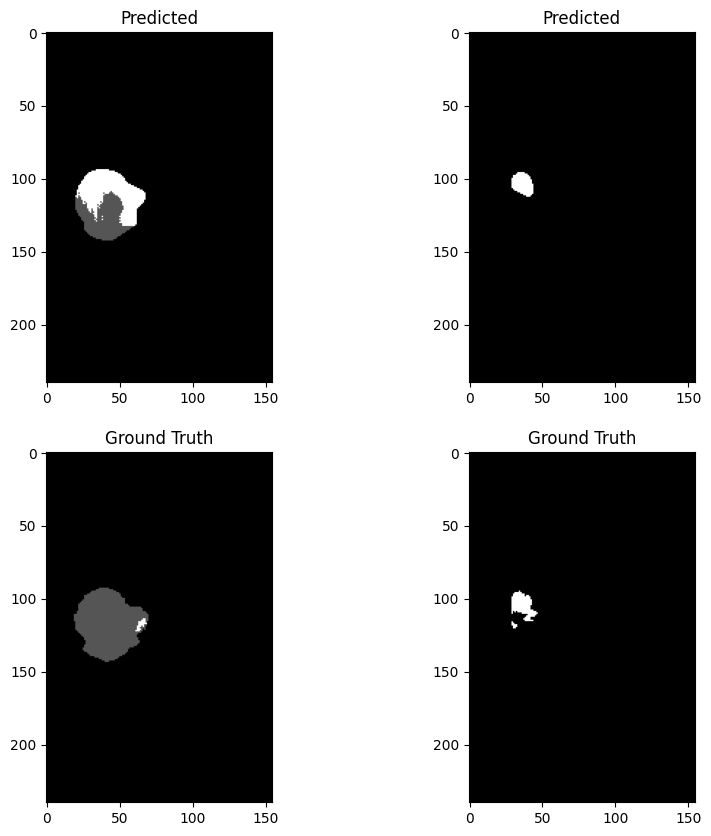

100%|██████████| 189/189 [11:27<00:00,  3.64s/it]



Average Training Loss: 0.03523644345699164

Average Training DSC: [0.99685769 0.58007038 0.70605329 0.426567  ]
Average Training ASSD: [ 0.34031973 84.78587467 81.05951764 39.3504185 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


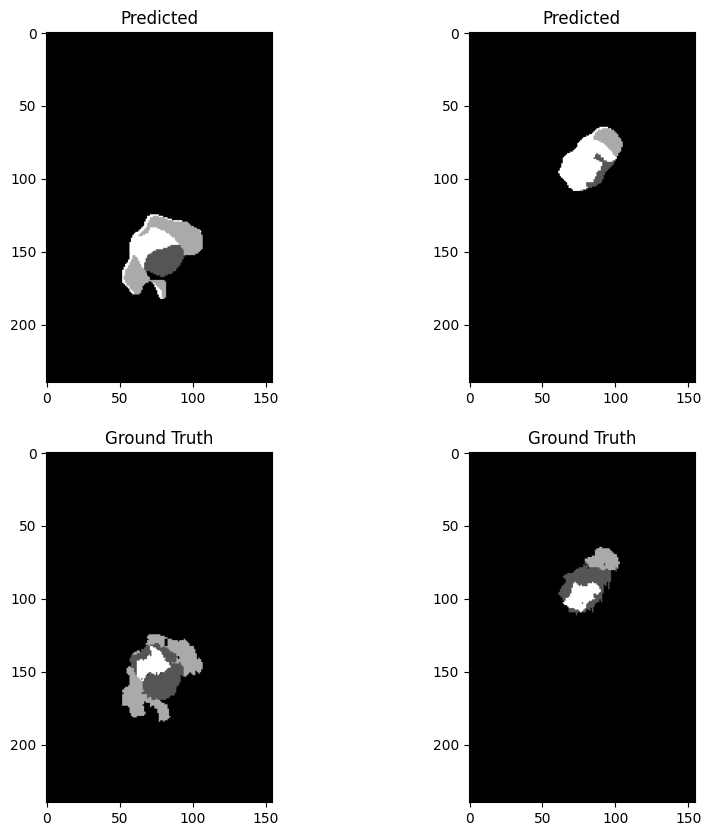

100%|██████████| 48/48 [02:44<00:00,  3.42s/it]


Average Validation Loss: 0.03556573255142818

Average Validation DSC: [0.99699749 0.56217869 0.66817387 0.49313347]
Average Validation ASSD: [ 0.32727399 73.42715247 86.29933152 27.34265786]
Epoch 8/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


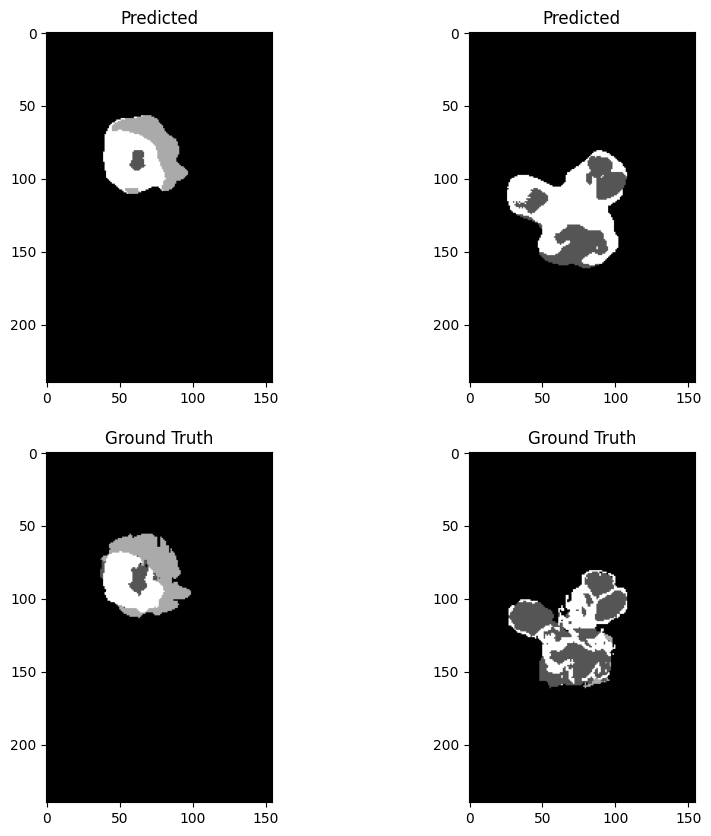

100%|██████████| 189/189 [11:52<00:00,  3.77s/it]



Average Training Loss: 0.03216180027950378

Average Training DSC: [0.99700758 0.6249205  0.71007951 0.4542075 ]
Average Training ASSD: [ 0.33018293 74.71357666 73.80502723 47.15635425]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


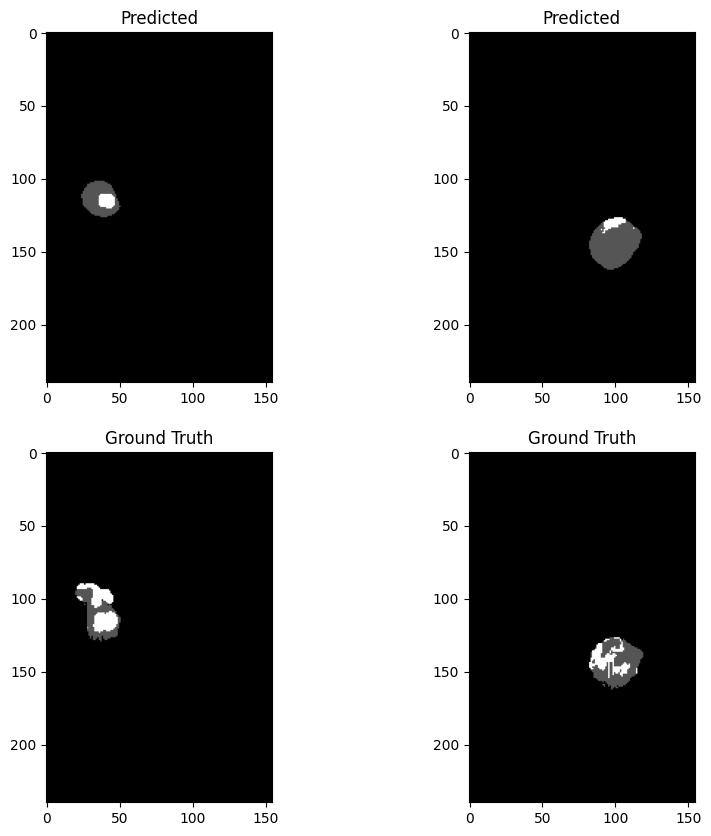

100%|██████████| 48/48 [02:43<00:00,  3.40s/it]


Average Validation Loss: 0.030711331210720044

Average Validation DSC: [0.99697231 0.64535721 0.77280903 0.41017308]
Average Validation ASSD: [ 0.32374482 71.05572058 54.51617569 71.77419441]
Epoch 9/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


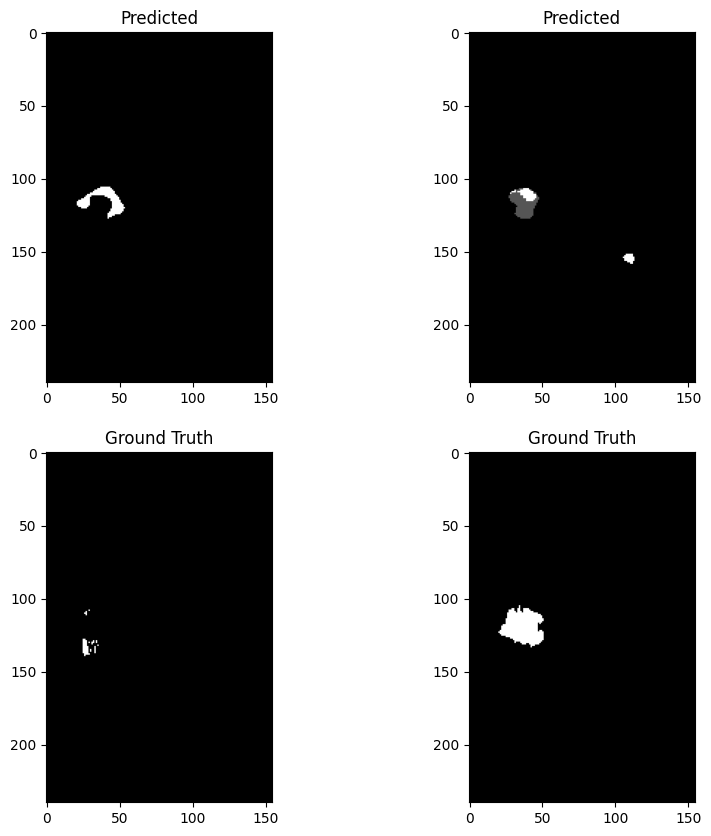

100%|██████████| 189/189 [11:27<00:00,  3.64s/it]



Average Training Loss: 0.027798383176405594

Average Training DSC: [0.99726977 0.68142476 0.77689275 0.49441363]
Average Training ASSD: [ 0.2969812  60.48878759 54.22339073 50.01624786]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


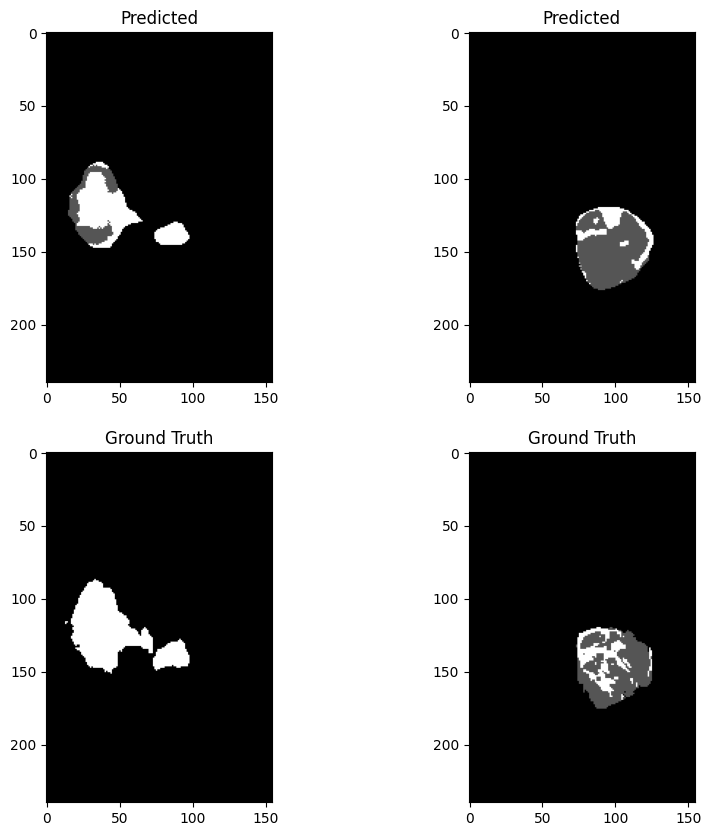

100%|██████████| 48/48 [02:42<00:00,  3.39s/it]


Average Validation Loss: 0.02561231512421121

Average Validation DSC: [0.99744372 0.72765267 0.76371954 0.53551003]
Average Validation ASSD: [ 0.27564331 45.657816   60.19915854 41.72263266]
Epoch 10/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


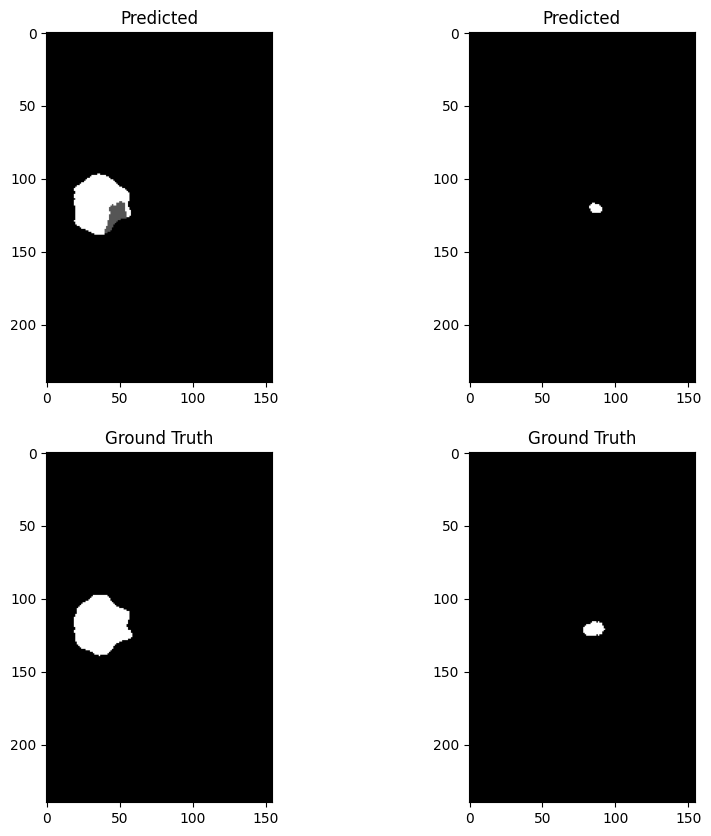

100%|██████████| 189/189 [11:41<00:00,  3.71s/it]



Average Training Loss: 0.02485433622958168

Average Training DSC: [0.99743639 0.73102587 0.80800239 0.53257433]
Average Training ASSD: [ 0.27301873 47.21521378 45.25488822 50.63707508]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


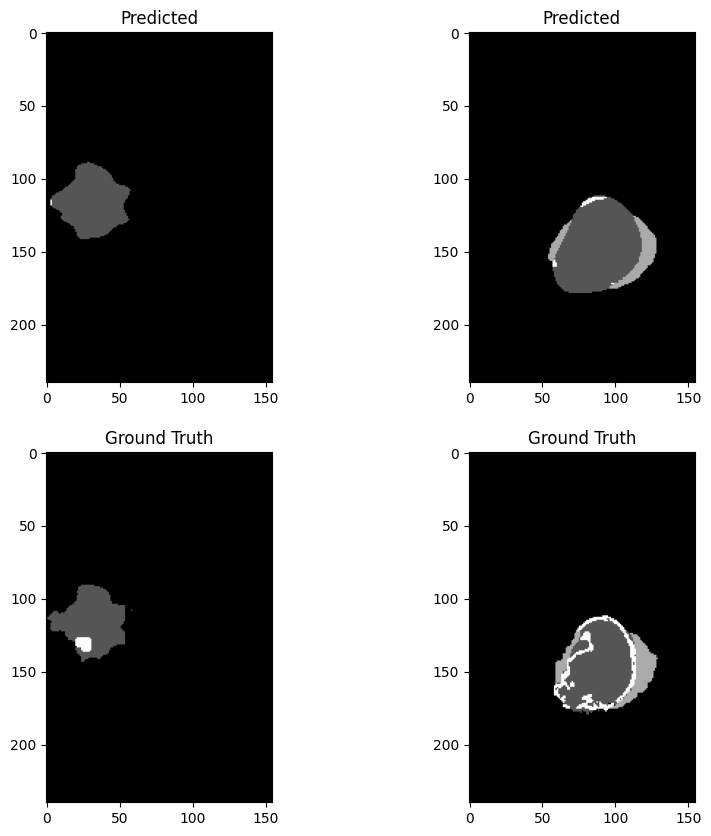

100%|██████████| 48/48 [02:38<00:00,  3.29s/it]


Average Validation Loss: 0.023276090466727812

Average Validation DSC: [0.99754809 0.75533464 0.81451128 0.57765278]
Average Validation ASSD: [ 0.24727092 35.92574399 43.24221696 38.10895255]
Epoch 11/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


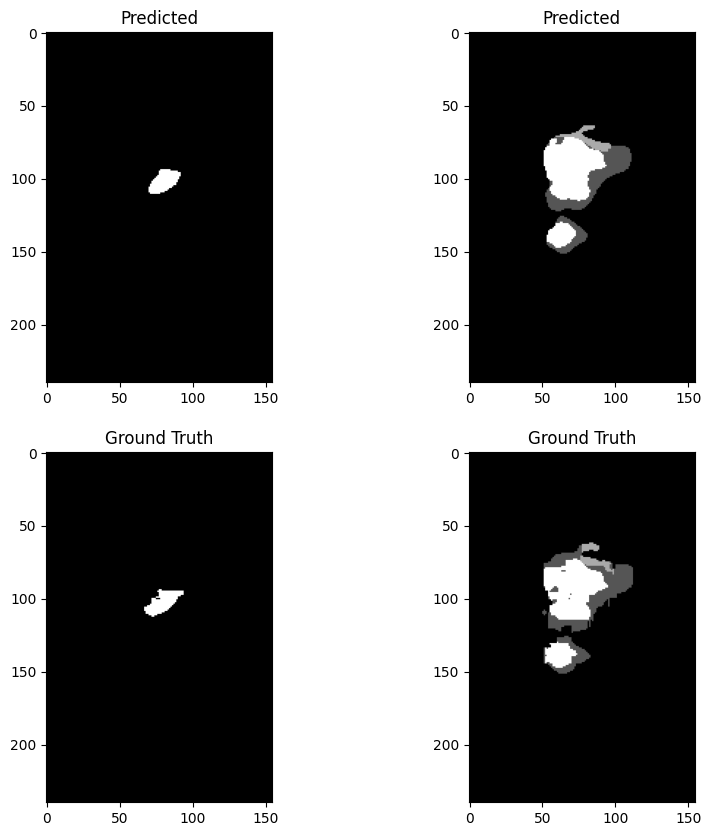

100%|██████████| 189/189 [11:38<00:00,  3.69s/it]



Average Training Loss: 0.02237241002657111

Average Training DSC: [0.99764046 0.76299867 0.83440635 0.55691473]
Average Training ASSD: [ 0.24861781 38.40850279 36.71351909 50.04566493]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


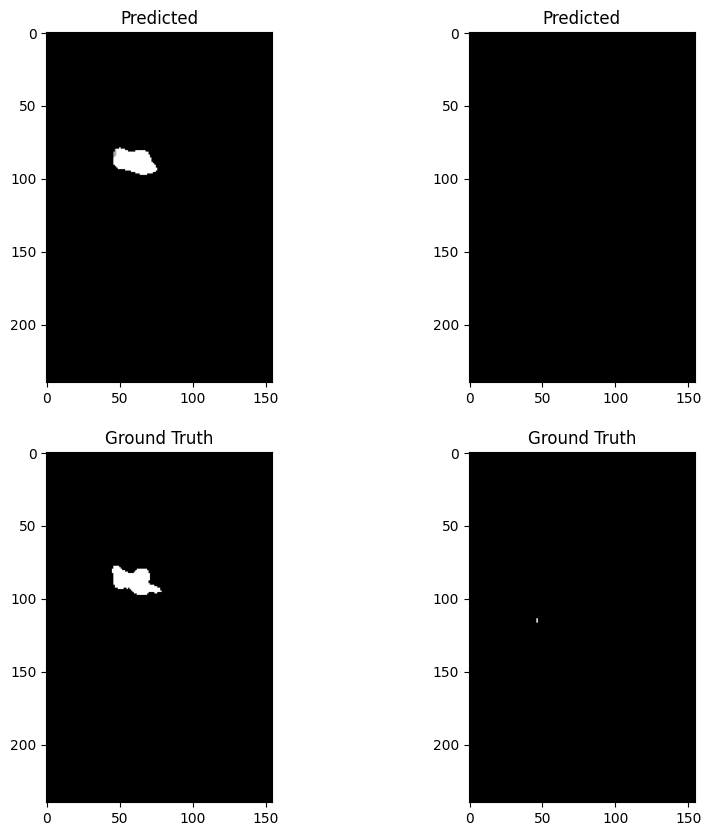

100%|██████████| 48/48 [02:43<00:00,  3.41s/it]


Average Validation Loss: 0.021718771662563086

Average Validation DSC: [0.99765669 0.77398405 0.80747346 0.56422088]
Average Validation ASSD: [ 0.2527587  32.98991867 44.03107493 54.46110592]
Epoch 12/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


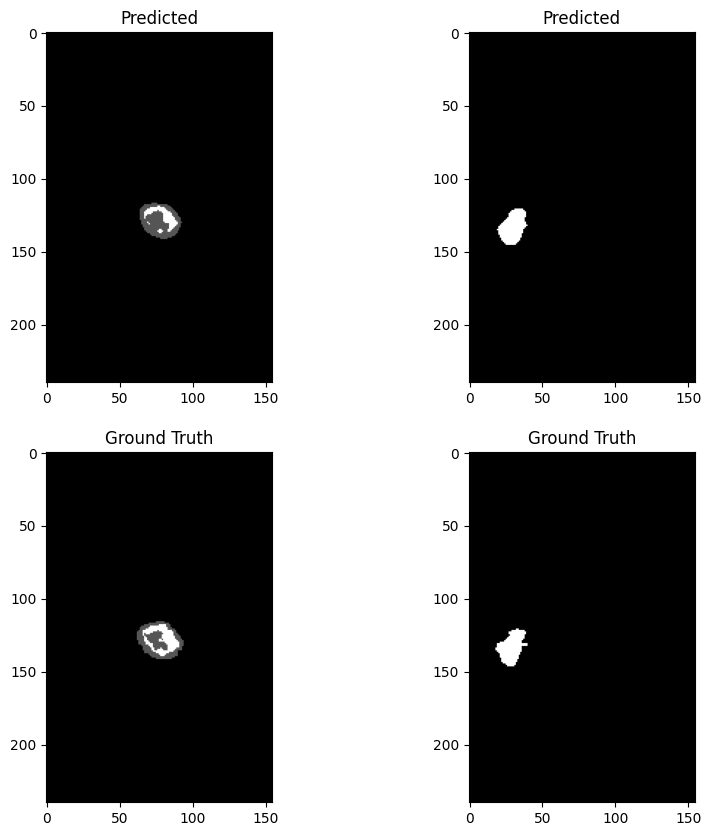

100%|██████████| 189/189 [11:24<00:00,  3.62s/it]



Average Training Loss: 0.020971820571474613

Average Training DSC: [0.99774056 0.78549102 0.84212569 0.57697843]
Average Training ASSD: [ 0.23639334 32.24275575 33.43801752 49.32879195]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


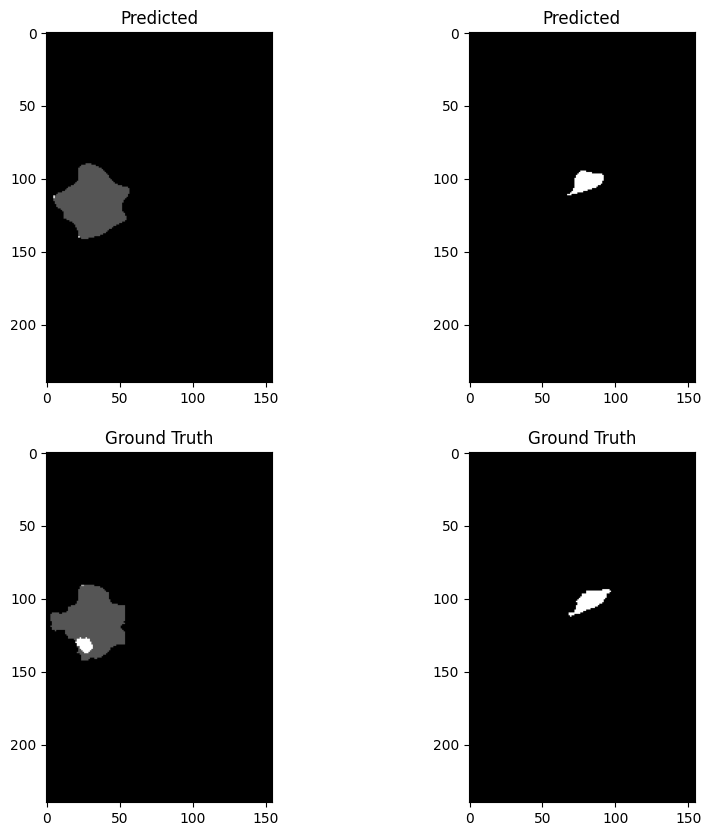

100%|██████████| 48/48 [02:40<00:00,  3.34s/it]


Average Validation Loss: 0.020225577192225803

Average Validation DSC: [0.99789981 0.77155561 0.84944853 0.61491559]
Average Validation ASSD: [ 0.22142725 32.34741679 28.77463314 39.98906999]
Epoch 13/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


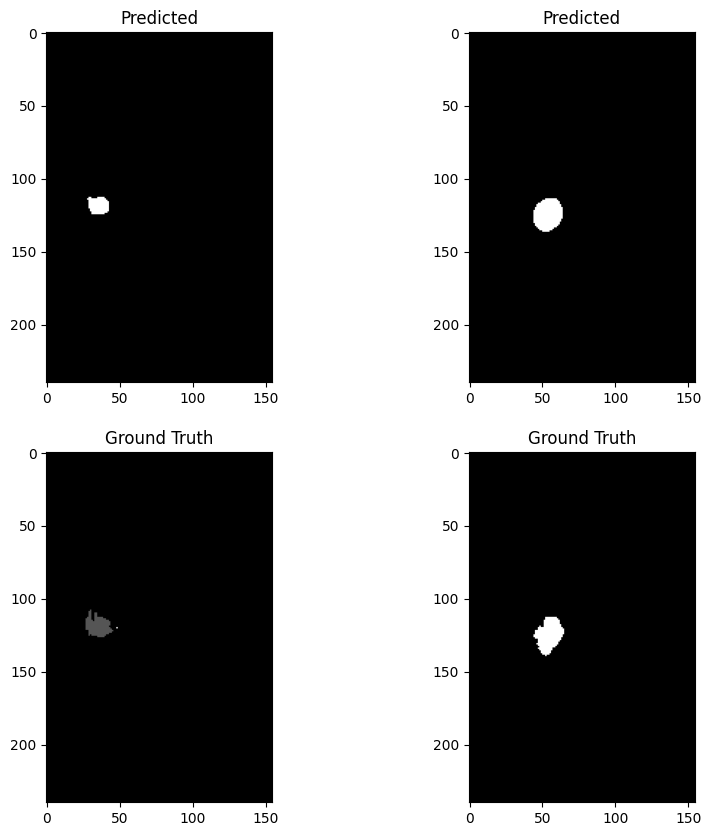

100%|██████████| 189/189 [11:31<00:00,  3.66s/it]



Average Training Loss: 0.019780744281080034

Average Training DSC: [0.99790127 0.80234641 0.85330762 0.59554274]
Average Training ASSD: [ 0.21349598 28.70519495 29.43918576 48.02534365]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


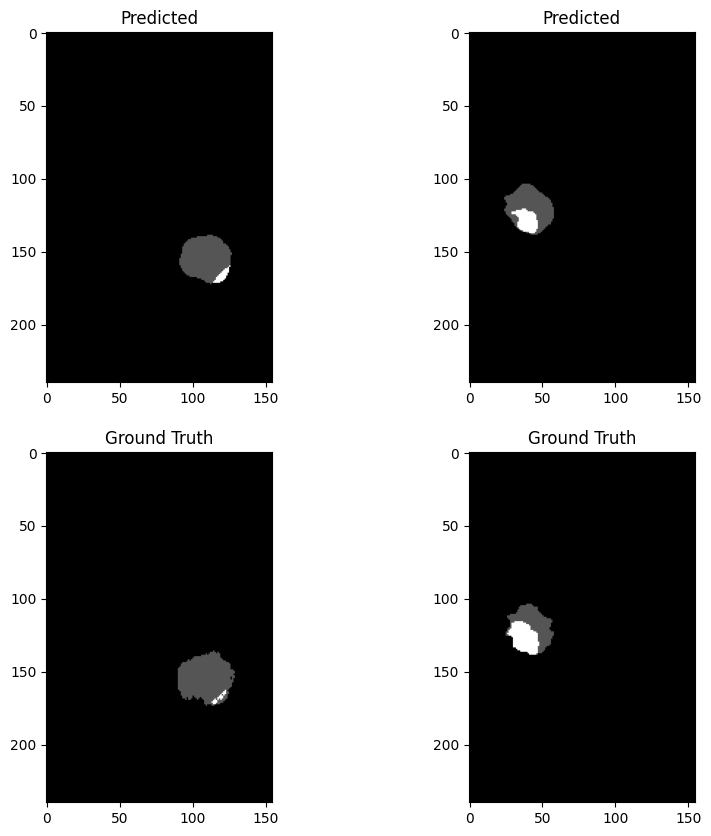

100%|██████████| 48/48 [02:46<00:00,  3.48s/it]


Average Validation Loss: 0.019483438363143552

Average Validation DSC: [0.99790072 0.79843403 0.84170864 0.61537222]
Average Validation ASSD: [ 0.21030214 29.50867445 31.05650035 40.40037317]
Epoch 14/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


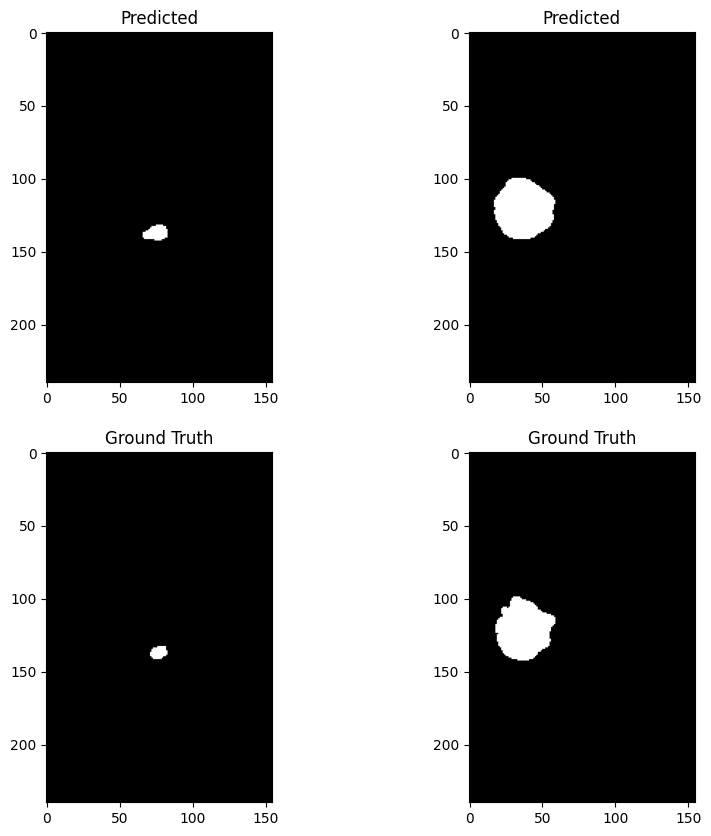

100%|██████████| 189/189 [11:41<00:00,  3.71s/it]



Average Training Loss: 0.018318318136075817

Average Training DSC: [0.99796666 0.81744323 0.8636413  0.61368795]
Average Training ASSD: [ 0.209036   25.29635918 26.24490452 45.56723666]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


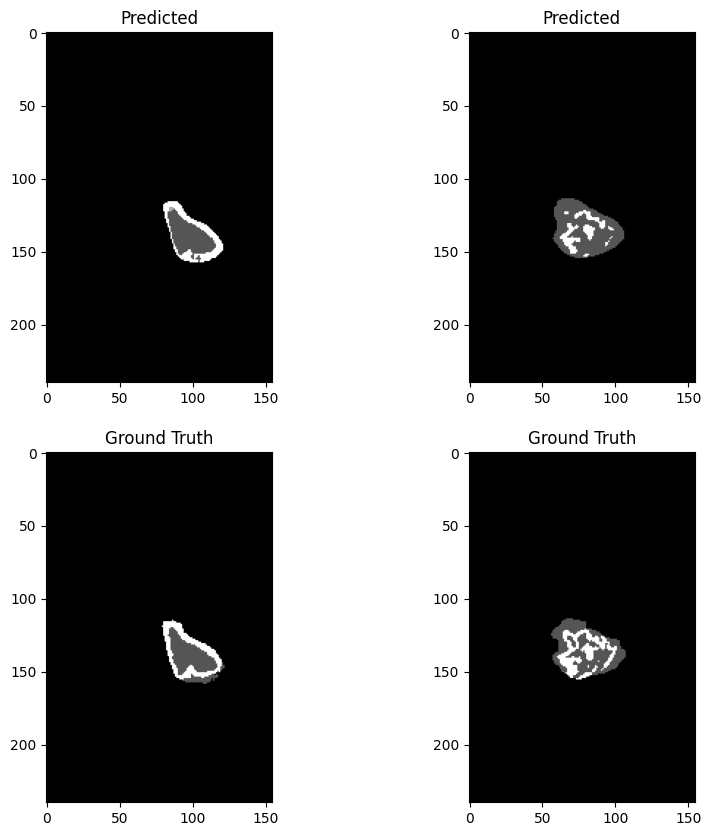

100%|██████████| 48/48 [02:43<00:00,  3.41s/it]


Average Validation Loss: 0.01771447198310246

Average Validation DSC: [0.99804008 0.81775549 0.85340649 0.61711124]
Average Validation ASSD: [ 0.20906732 21.1170708  28.64421881 46.01160841]
Epoch 15/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


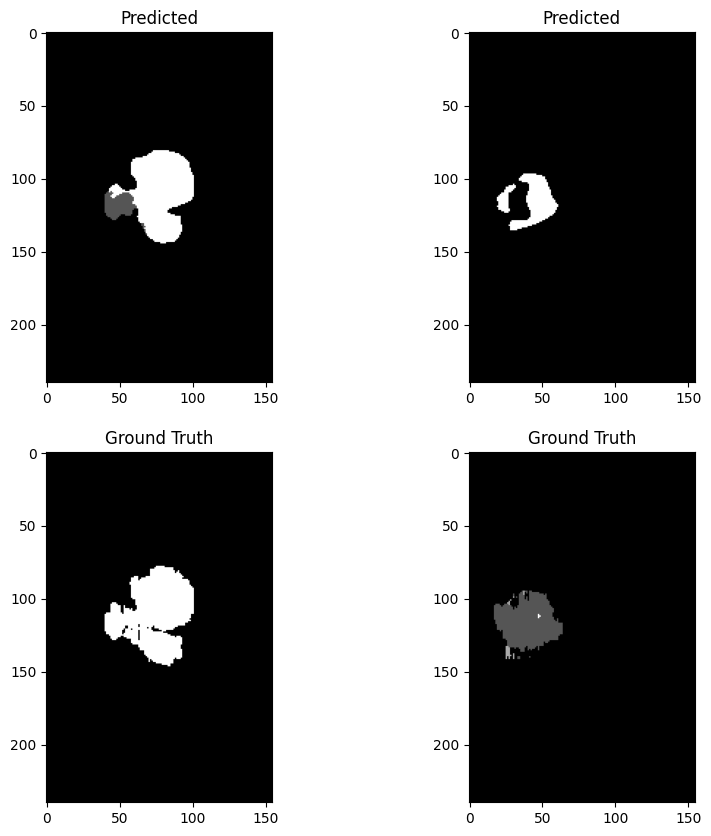

100%|██████████| 189/189 [11:32<00:00,  3.67s/it]



Average Training Loss: 0.017264257332990095

Average Training DSC: [0.99805666 0.82508505 0.87444202 0.62838135]
Average Training ASSD: [ 0.19999479 23.10539489 22.58079437 43.71332488]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


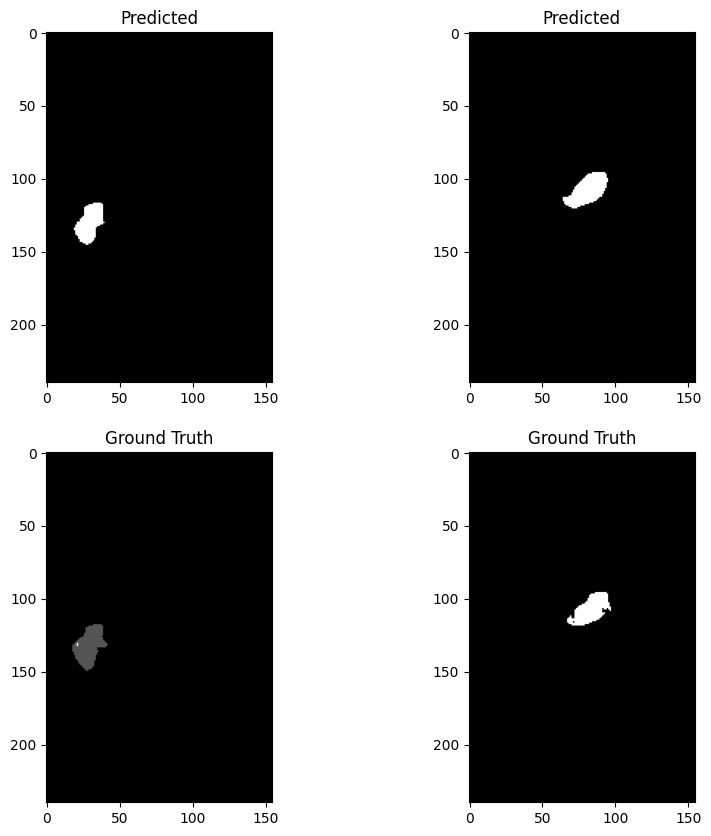

100%|██████████| 48/48 [02:44<00:00,  3.43s/it]


Average Validation Loss: 0.01731861454512303

Average Validation DSC: [0.99807999 0.82675392 0.86083051 0.62591851]
Average Validation ASSD: [ 0.20643573 22.07846286 27.1182686  49.41890219]
Epoch 16/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


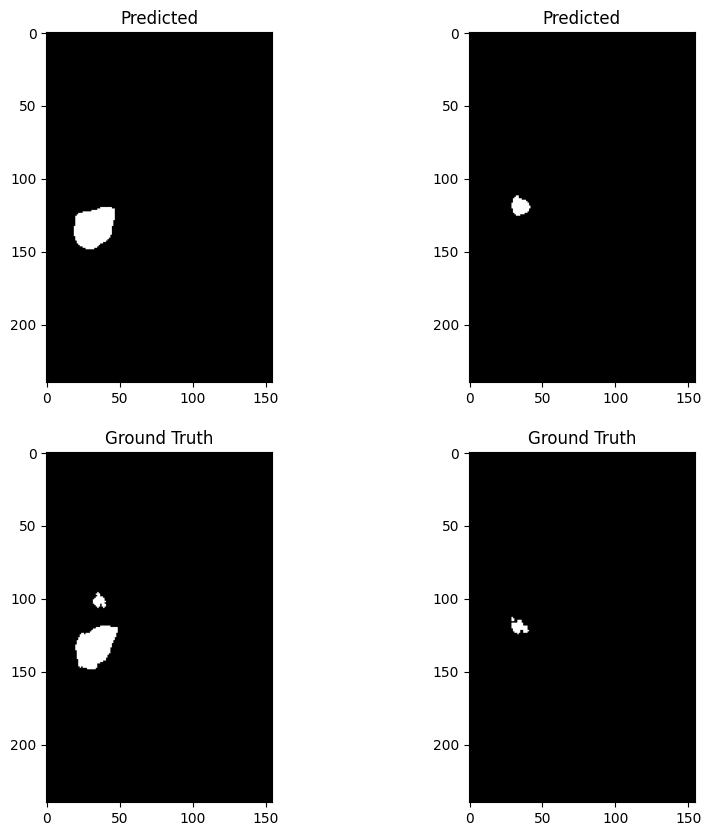

100%|██████████| 189/189 [11:30<00:00,  3.65s/it]



Average Training Loss: 0.017002275080553124

Average Training DSC: [0.99809336 0.82805347 0.87342309 0.63752741]
Average Training ASSD: [ 0.18908839 22.95768816 23.08121682 41.8827838 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


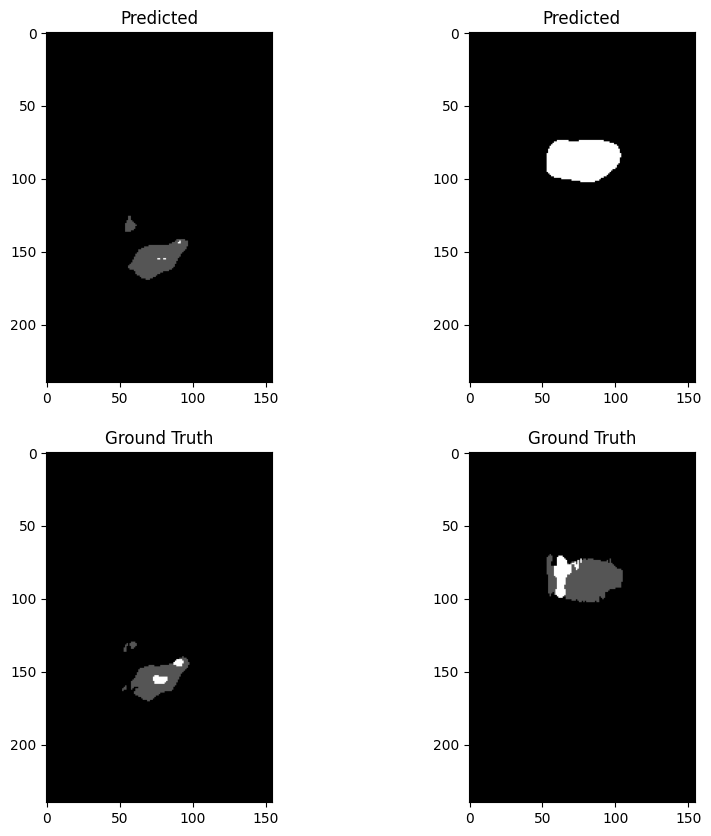

100%|██████████| 48/48 [02:45<00:00,  3.46s/it]


Average Validation Loss: 0.020210112212225795

Average Validation DSC: [0.99775574 0.82219181 0.85342165 0.54460961]
Average Validation ASSD: [ 0.26488438 24.58987865 26.71922824 67.89500193]
Epoch 17/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


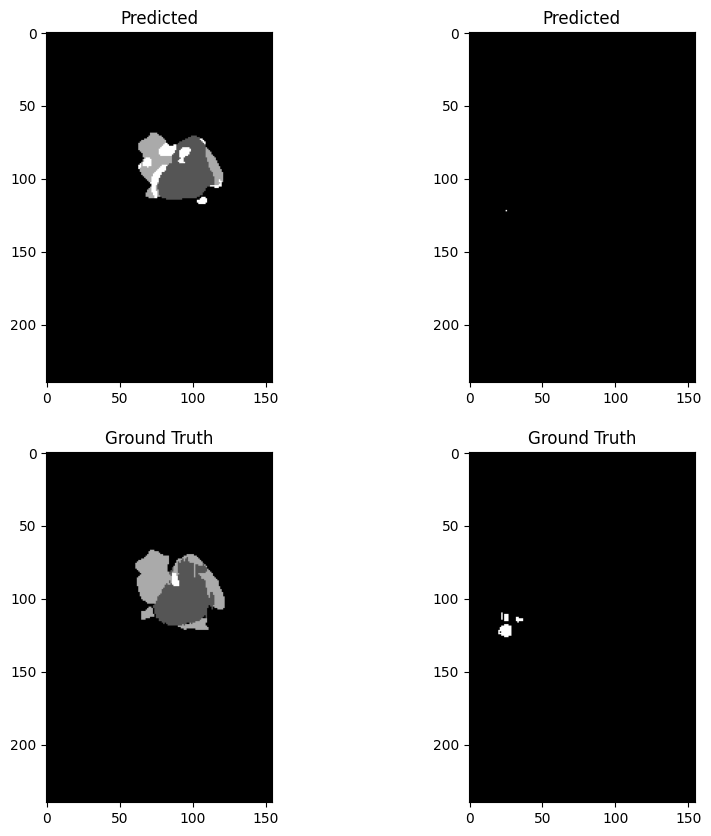

100%|██████████| 189/189 [11:23<00:00,  3.61s/it]



Average Training Loss: 0.0162610022361001

Average Training DSC: [0.99815167 0.84127419 0.87677104 0.64549921]
Average Training ASSD: [ 0.18551439 20.22733103 23.75210241 41.16037941]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


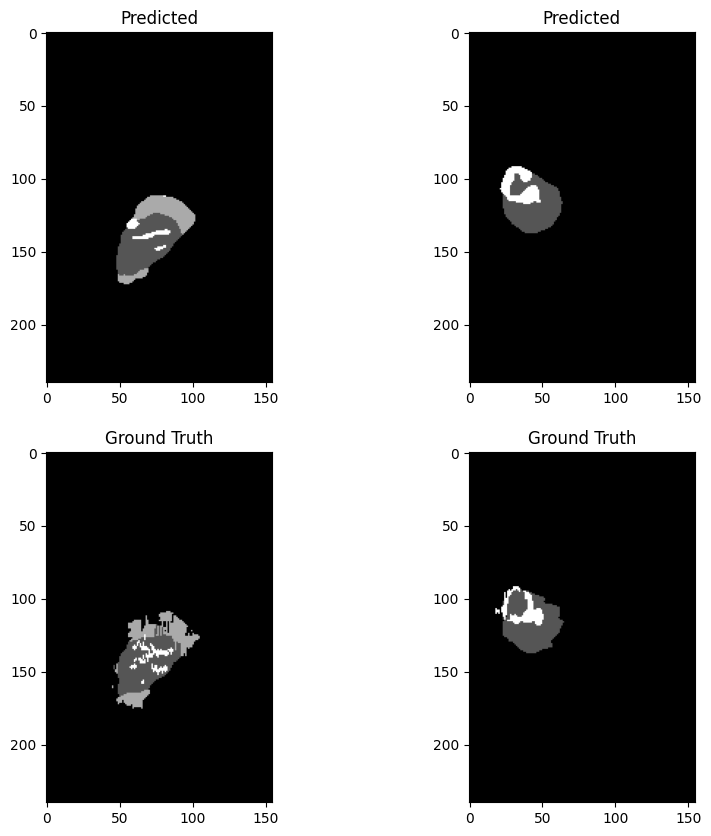

100%|██████████| 48/48 [02:34<00:00,  3.23s/it]


Average Validation Loss: 0.01659539941465482

Average Validation DSC: [0.99821127 0.82224664 0.87121064 0.67881551]
Average Validation ASSD: [ 0.1792659  21.22230654 24.61379852 31.65860988]
Epoch 18/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


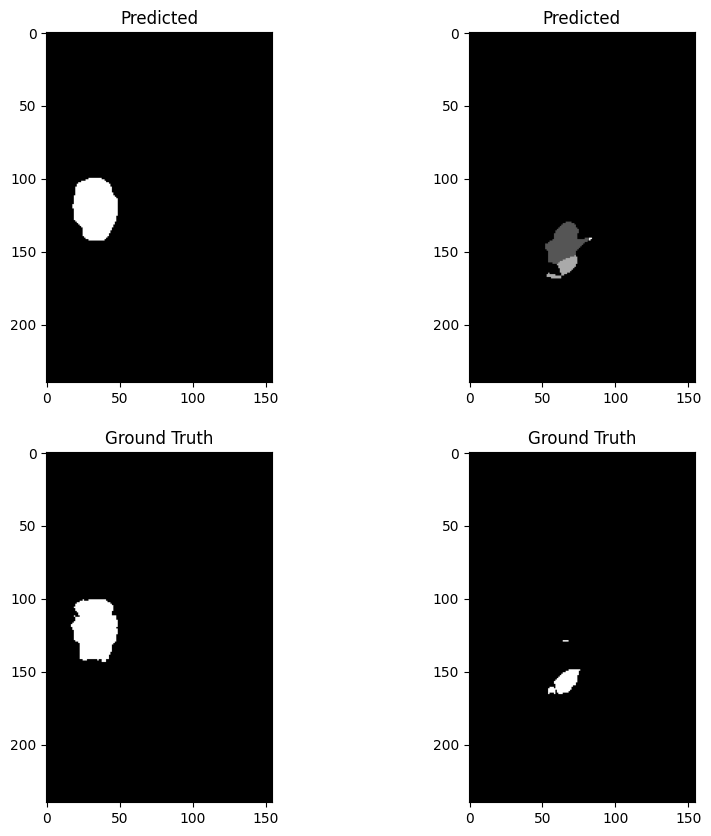

100%|██████████| 189/189 [10:58<00:00,  3.49s/it]



Average Training Loss: 0.015123708863501195

Average Training DSC: [0.99828945 0.84558125 0.88803375 0.66167428]
Average Training ASSD: [ 0.17187975 19.83048788 20.26726833 40.16776373]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


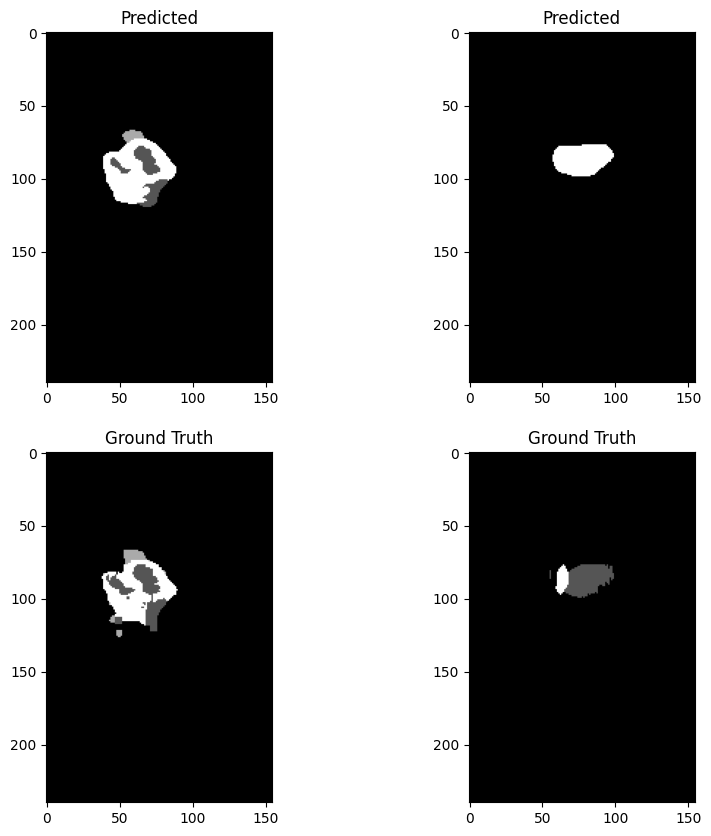

100%|██████████| 48/48 [02:40<00:00,  3.33s/it]


Average Validation Loss: 0.015444182131129006

Average Validation DSC: [0.99830781 0.83950839 0.86634561 0.66589894]
Average Validation ASSD: [ 0.17330961 22.63163125 25.65956243 39.7509424 ]
Epoch 19/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


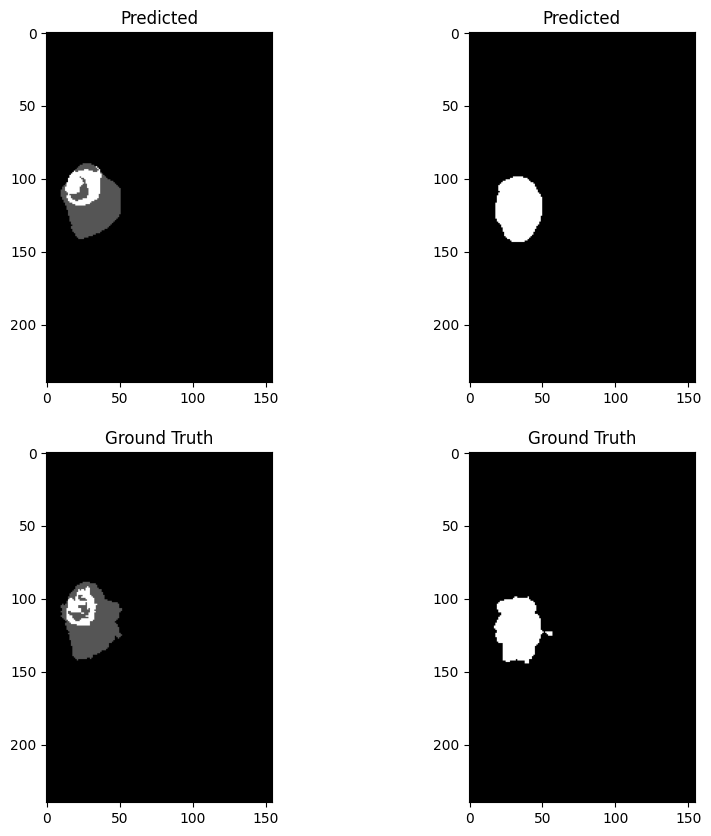

100%|██████████| 189/189 [11:17<00:00,  3.58s/it]



Average Training Loss: 0.015017314193149408

Average Training DSC: [0.99832958 0.84797447 0.88658781 0.66513573]
Average Training ASSD: [ 0.16690182 18.92326434 20.47096049 38.50772523]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


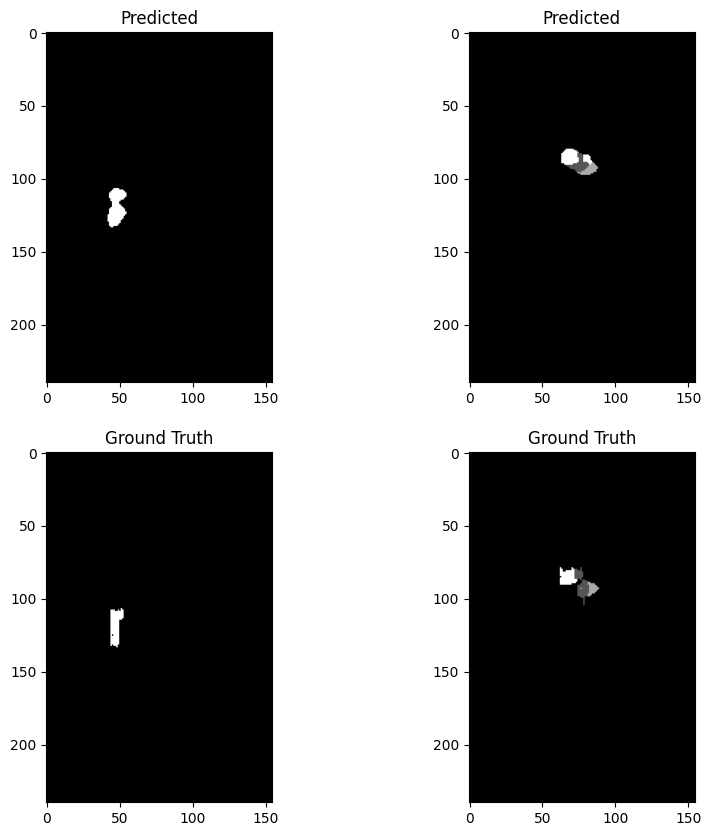

100%|██████████| 48/48 [02:36<00:00,  3.27s/it]


Average Validation Loss: 0.015443171161071708

Average Validation DSC: [0.99830638 0.85364087 0.87140396 0.66966206]
Average Validation ASSD: [ 0.16810579 16.30936576 25.62158914 33.7121673 ]
Epoch 20/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


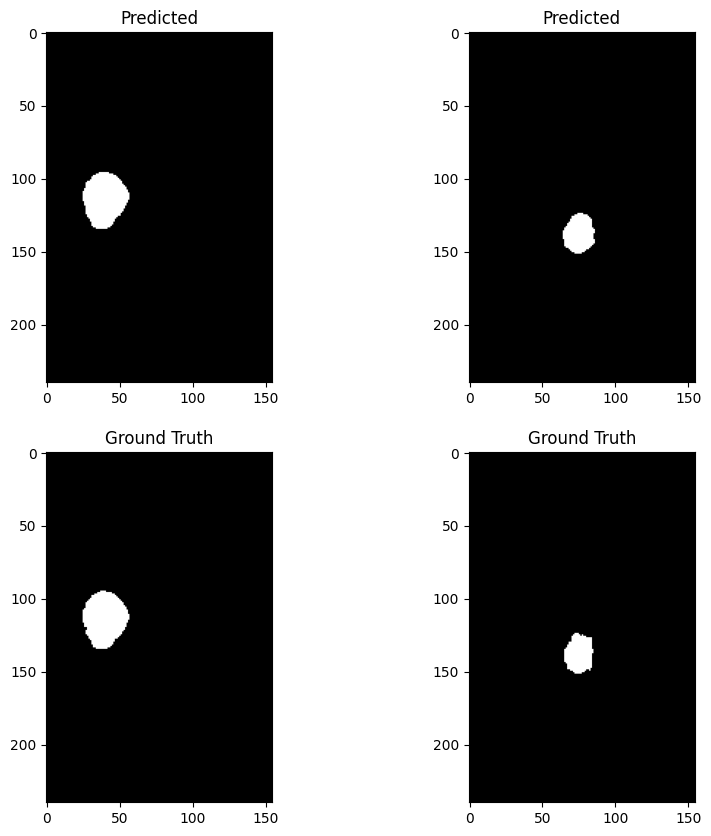

100%|██████████| 189/189 [11:07<00:00,  3.53s/it]



Average Training Loss: 0.014216543032378747

Average Training DSC: [0.99836976 0.85897929 0.89128738 0.67638959]
Average Training ASSD: [ 0.16166662 16.73128426 19.74620457 38.24332648]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


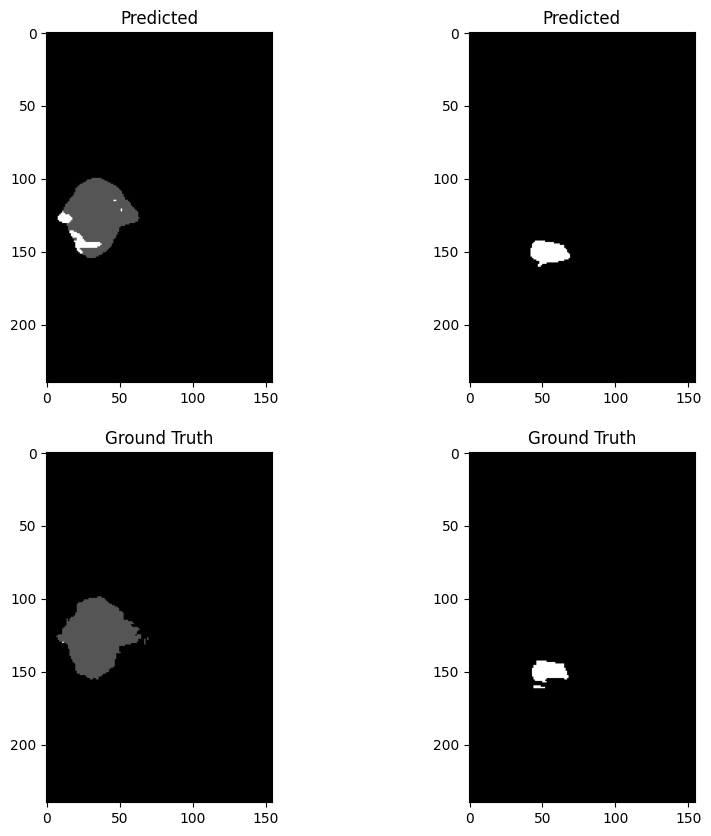

100%|██████████| 48/48 [02:37<00:00,  3.28s/it]


Average Validation Loss: 0.01569941461396714

Average Validation DSC: [0.99826814 0.85102883 0.87306818 0.66724874]
Average Validation ASSD: [ 0.1628782  17.39185814 24.66422318 30.52486597]
Epoch 21/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


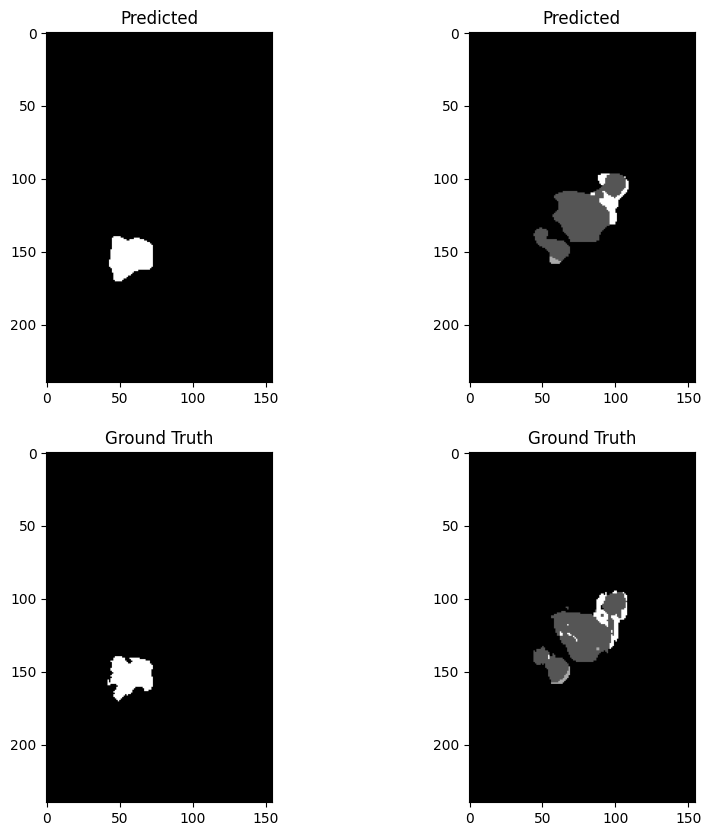

100%|██████████| 189/189 [11:47<00:00,  3.74s/it]



Average Training Loss: 0.01406215206182823

Average Training DSC: [0.99839806 0.85942289 0.89381584 0.68290391]
Average Training ASSD: [ 0.15892911 17.12898634 19.44179092 36.11028281]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


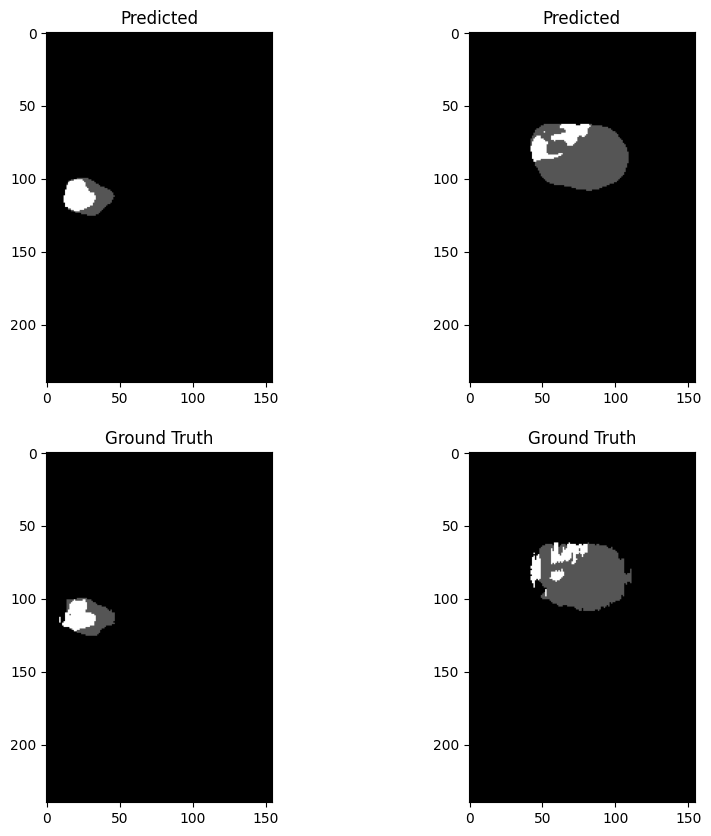

100%|██████████| 48/48 [02:47<00:00,  3.49s/it]


Average Validation Loss: 0.014204479152491937

Average Validation DSC: [0.99839315 0.85233353 0.87621406 0.66656114]
Average Validation ASSD: [ 0.17283315 20.10041615 23.60742062 46.15855308]
Epoch 22/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


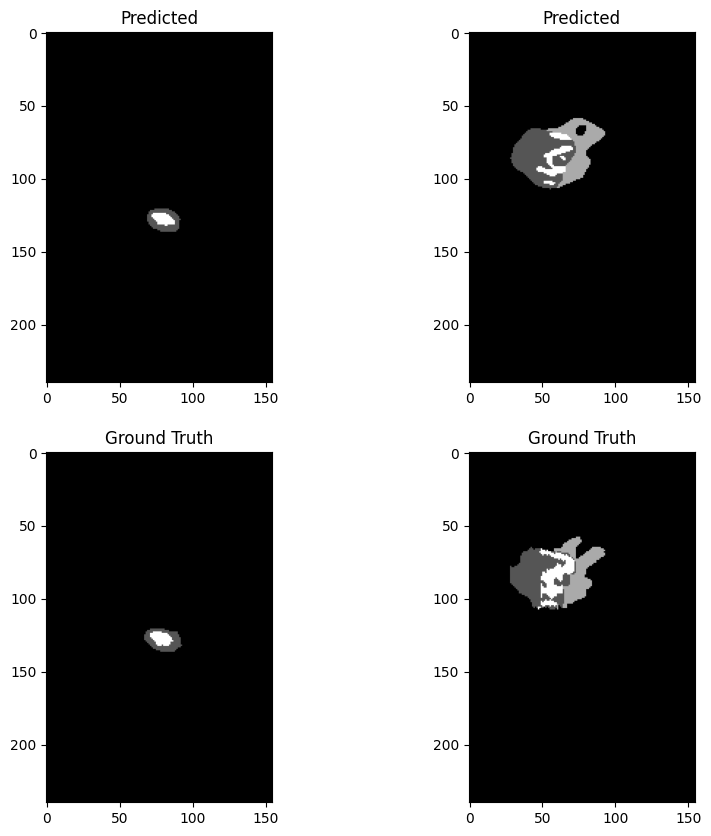

100%|██████████| 189/189 [11:50<00:00,  3.76s/it]



Average Training Loss: 0.01340978169843318

Average Training DSC: [0.99848464 0.86120512 0.89801126 0.68893701]
Average Training ASSD: [ 0.14725898 17.64234961 18.07811282 35.86798566]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


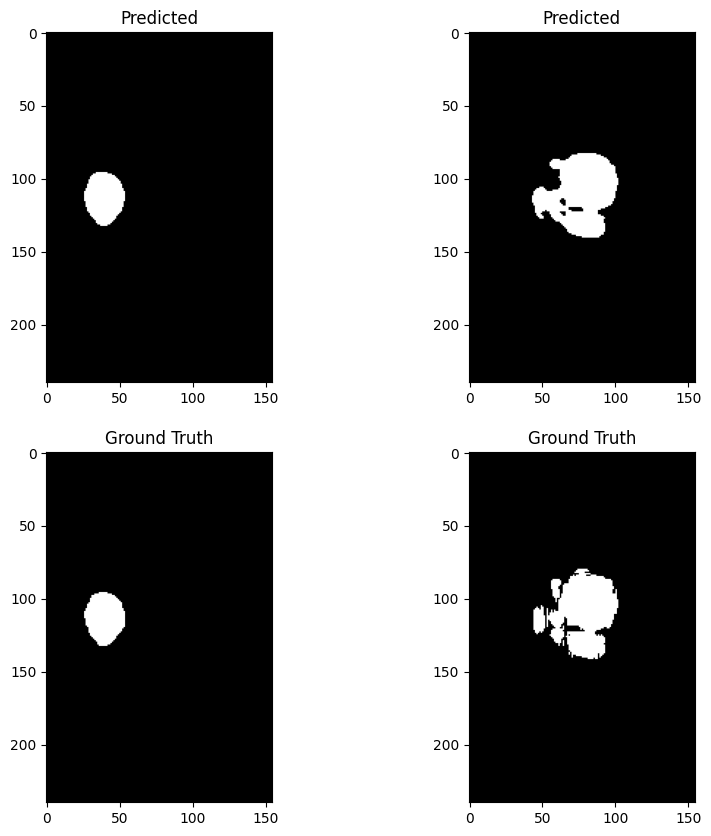

100%|██████████| 48/48 [02:42<00:00,  3.39s/it]


Average Validation Loss: 0.013815877435263246

Average Validation DSC: [0.99843786 0.86164084 0.88173608 0.66534481]
Average Validation ASSD: [ 0.16962104 16.35218076 22.6843362  47.28143882]
Epoch 23/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


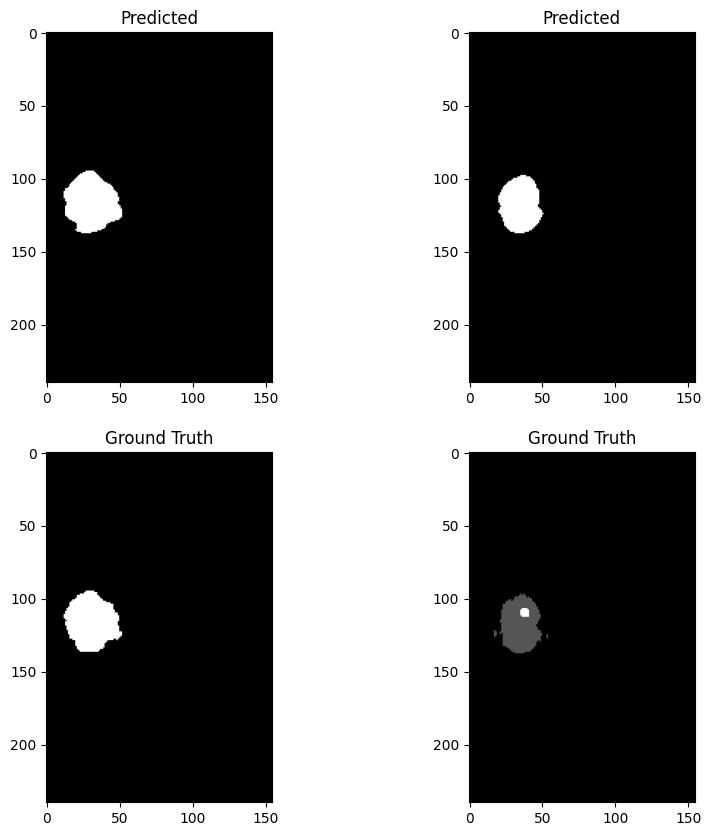

100%|██████████| 189/189 [11:36<00:00,  3.69s/it]



Average Training Loss: 0.012885870503153277

Average Training DSC: [0.99851609 0.87208439 0.89885811 0.69903994]
Average Training ASSD: [ 0.14494052 14.91722019 18.02464852 34.92643904]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


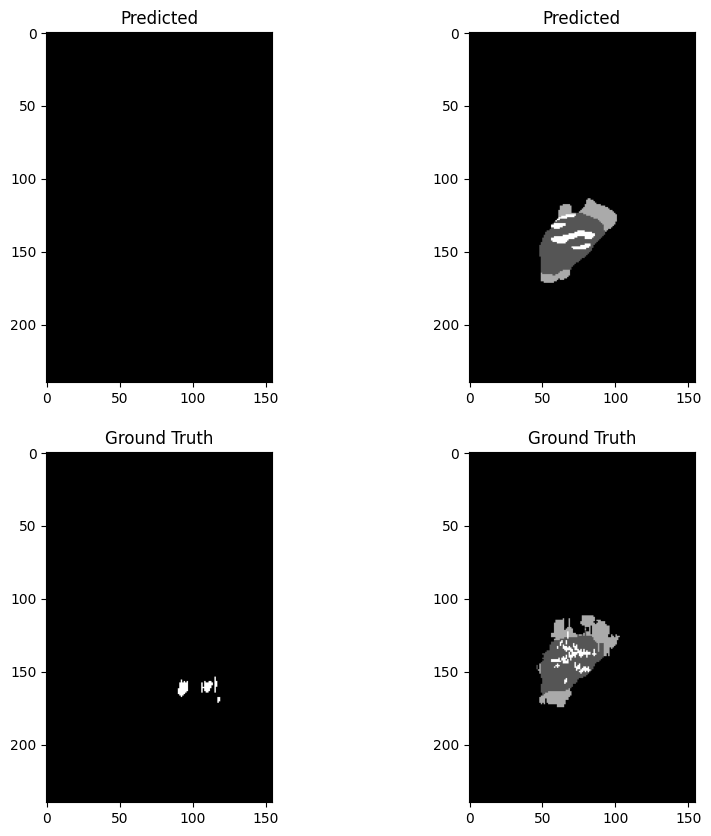

100%|██████████| 48/48 [02:47<00:00,  3.49s/it]


Average Validation Loss: 0.014902709731056044

Average Validation DSC: [0.99839852 0.82886516 0.87717212 0.68857627]
Average Validation ASSD: [ 0.15914192 25.18884201 23.54405852 32.86591274]
Epoch 24/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


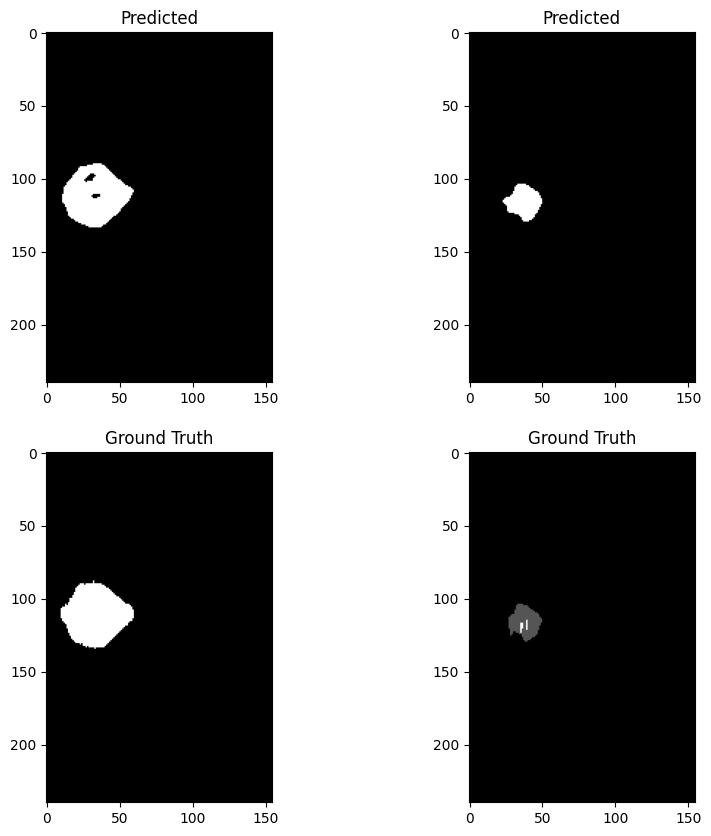

100%|██████████| 189/189 [11:42<00:00,  3.72s/it]



Average Training Loss: 0.012965702722785334

Average Training DSC: [0.99846961 0.86841196 0.90471898 0.6974735 ]
Average Training ASSD: [ 0.1511285  15.29022121 16.38024244 35.27279968]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


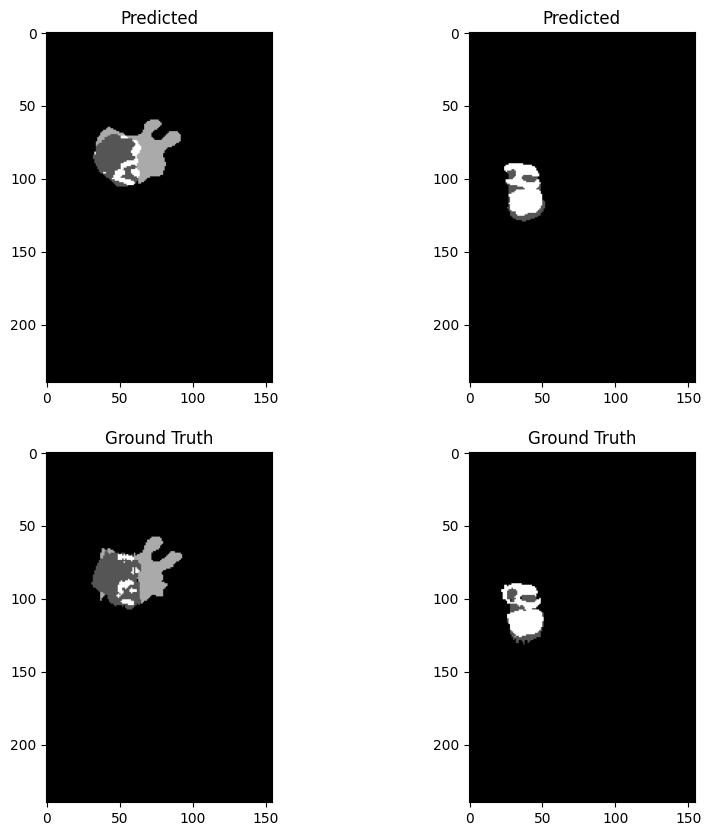

100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Average Validation Loss: 0.013710462740467241

Average Validation DSC: [0.99850744 0.85907491 0.87967236 0.70942575]
Average Validation ASSD: [ 0.15008471 18.42617172 22.75241577 34.27453312]
Epoch 25/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


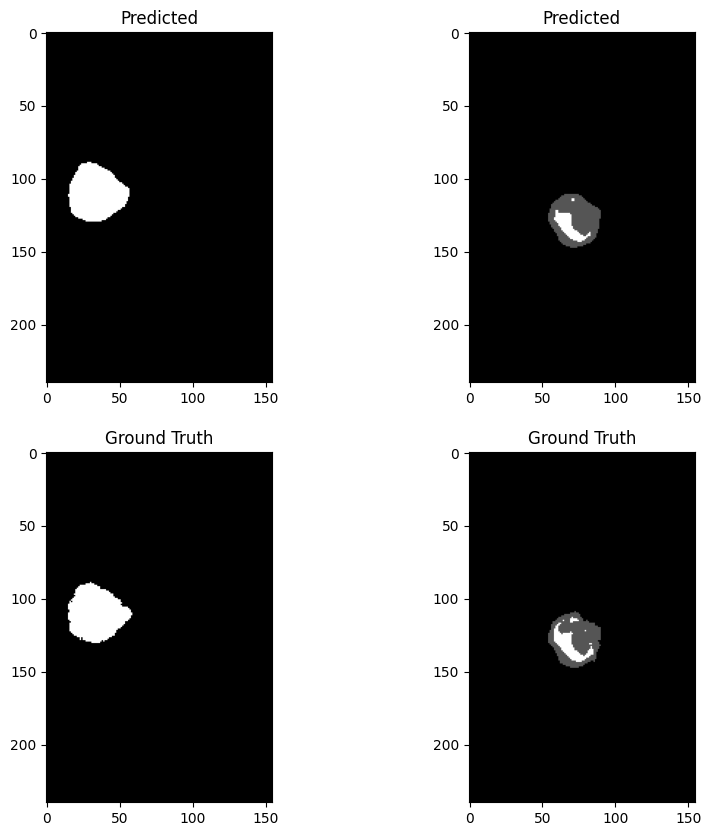

100%|██████████| 189/189 [11:52<00:00,  3.77s/it]



Average Training Loss: 0.012721420857050116

Average Training DSC: [0.99854881 0.86801543 0.90505904 0.70578519]
Average Training ASSD: [ 0.14215475 16.93913393 16.50121563 33.4188203 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


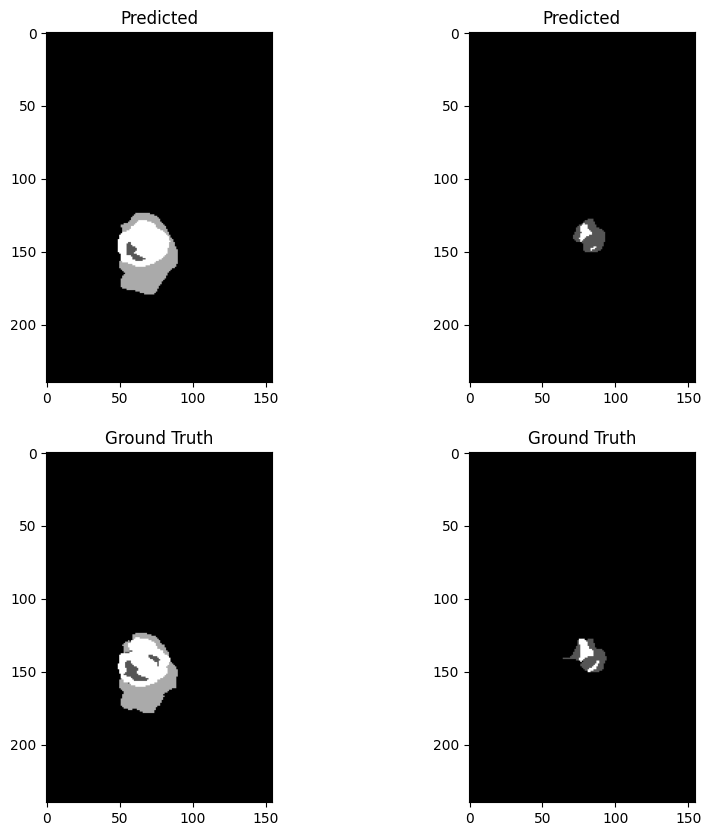

100%|██████████| 48/48 [02:49<00:00,  3.54s/it]


Average Validation Loss: 0.013674719026312232

Average Validation DSC: [0.9984268  0.85913479 0.8852308  0.72001792]
Average Validation ASSD: [ 0.14759937 16.23509661 21.2366982  26.92873332]
Epoch 26/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


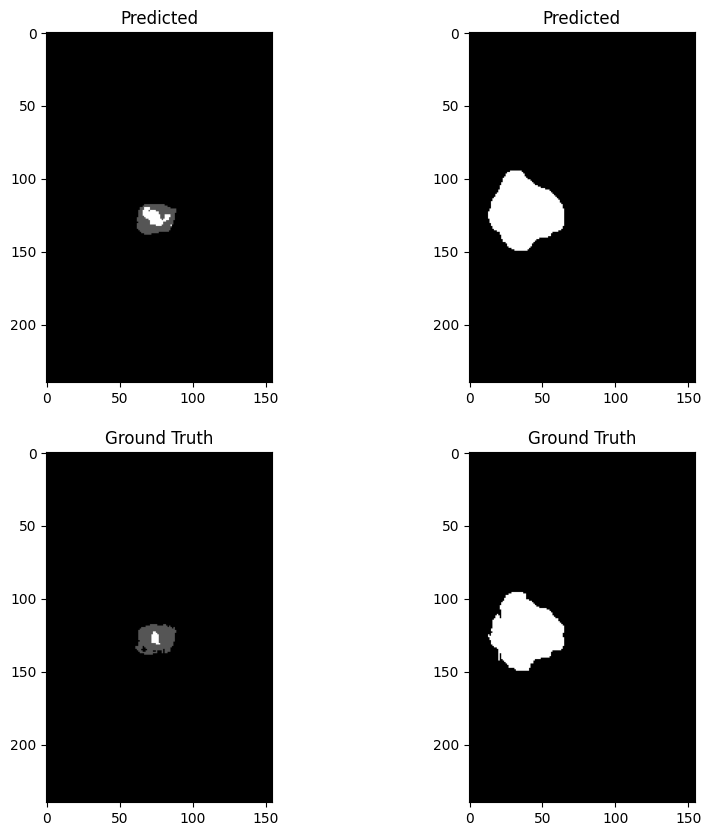

100%|██████████| 189/189 [12:10<00:00,  3.86s/it]



Average Training Loss: 0.012165268732816297

Average Training DSC: [0.99861769 0.87644505 0.90973801 0.70991162]
Average Training ASSD: [ 0.13447749 14.34830681 15.34265681 34.65653647]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


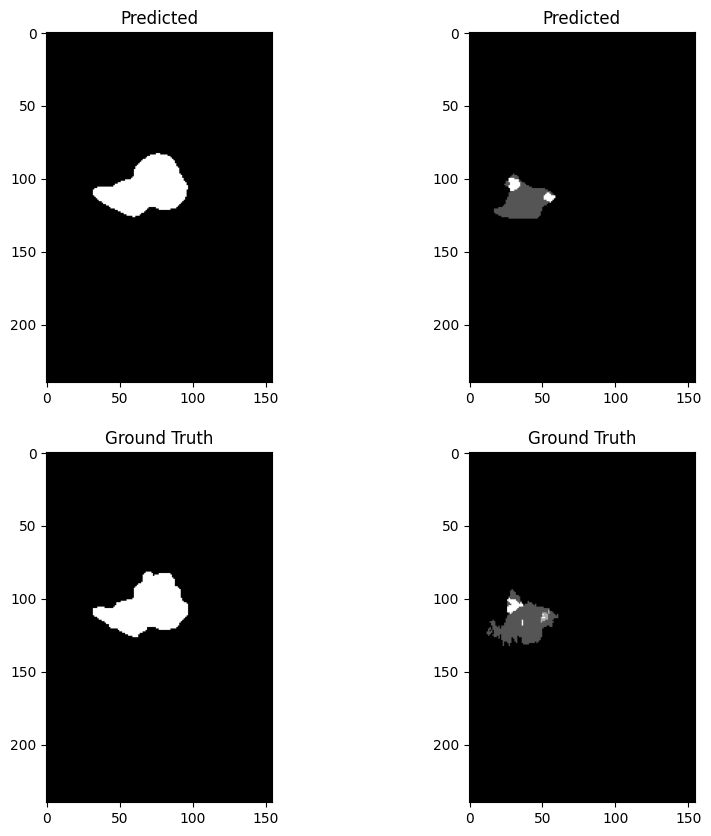

100%|██████████| 48/48 [02:47<00:00,  3.48s/it]


Average Validation Loss: 0.014857700637852153

Average Validation DSC: [0.99834175 0.8608266  0.88532126 0.68597554]
Average Validation ASSD: [ 0.17038216 16.37735228 21.08364891 31.07670178]
Epoch 27/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


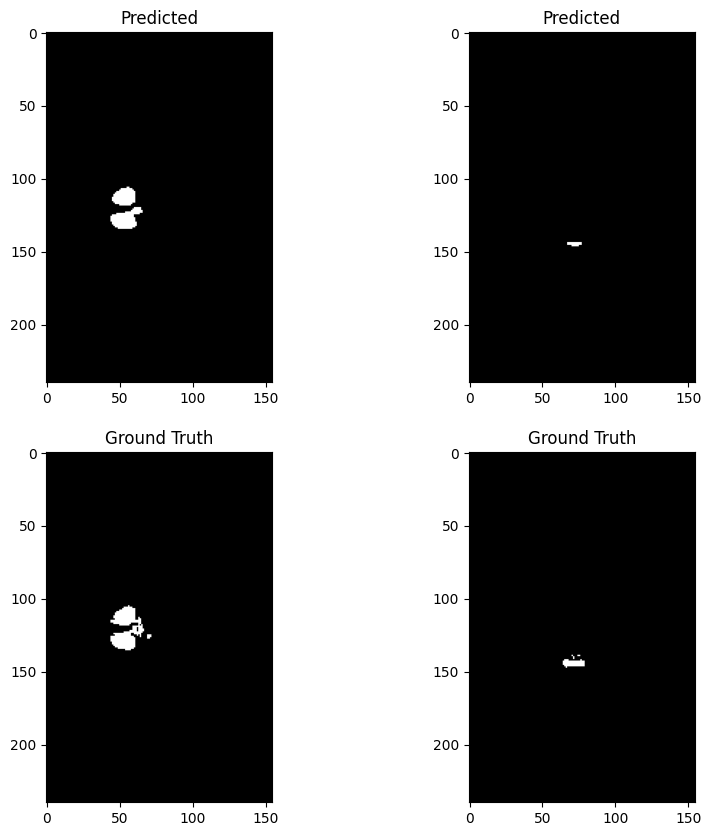

100%|██████████| 189/189 [11:53<00:00,  3.77s/it]



Average Training Loss: 0.012812486140146143

Average Training DSC: [0.99853109 0.86735712 0.90207402 0.70281781]
Average Training ASSD: [ 0.14617876 17.1669965  17.03742282 34.63210773]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


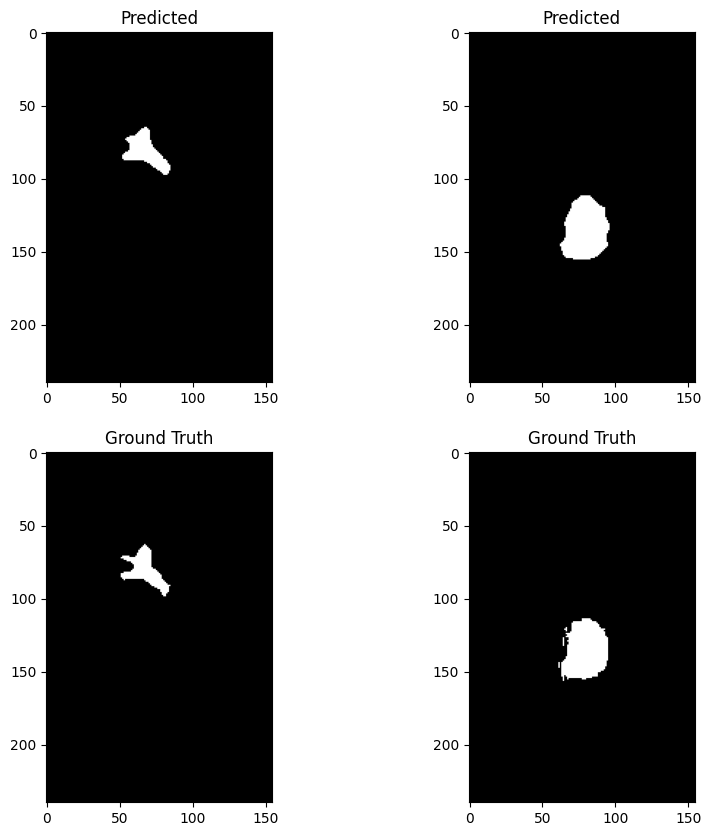

100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Average Validation Loss: 0.014738065966715416

Average Validation DSC: [0.99846864 0.84750843 0.83230157 0.70678985]
Average Validation ASSD: [ 0.14732299 15.91280943 36.00573774 26.88068927]
Epoch 28/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


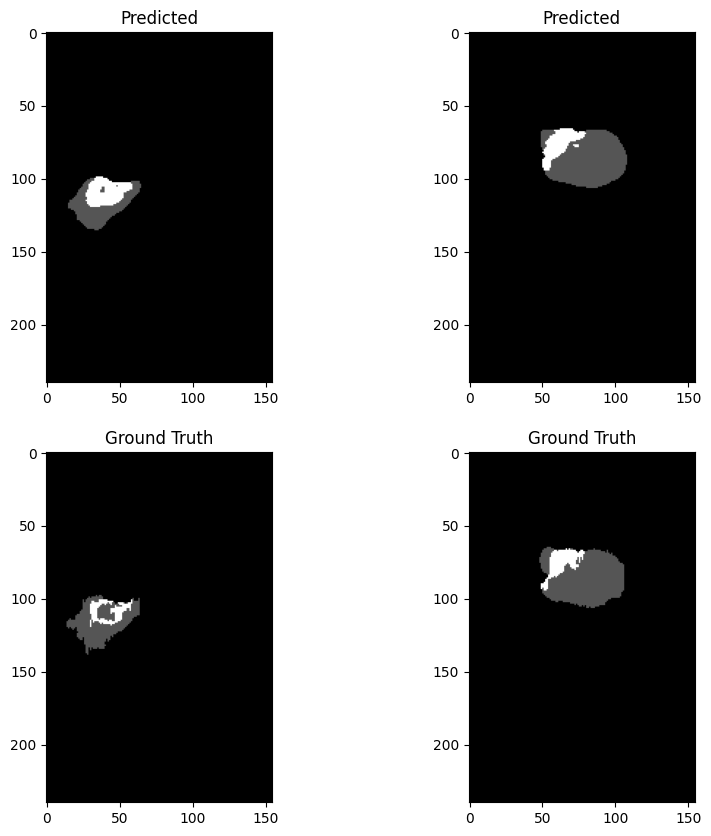

100%|██████████| 189/189 [11:45<00:00,  3.73s/it]



Average Training Loss: 0.011810178136719125

Average Training DSC: [0.99862217 0.88062672 0.90889319 0.71575085]
Average Training ASSD: [ 0.13476546 14.02538439 15.52806566 33.3178479 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


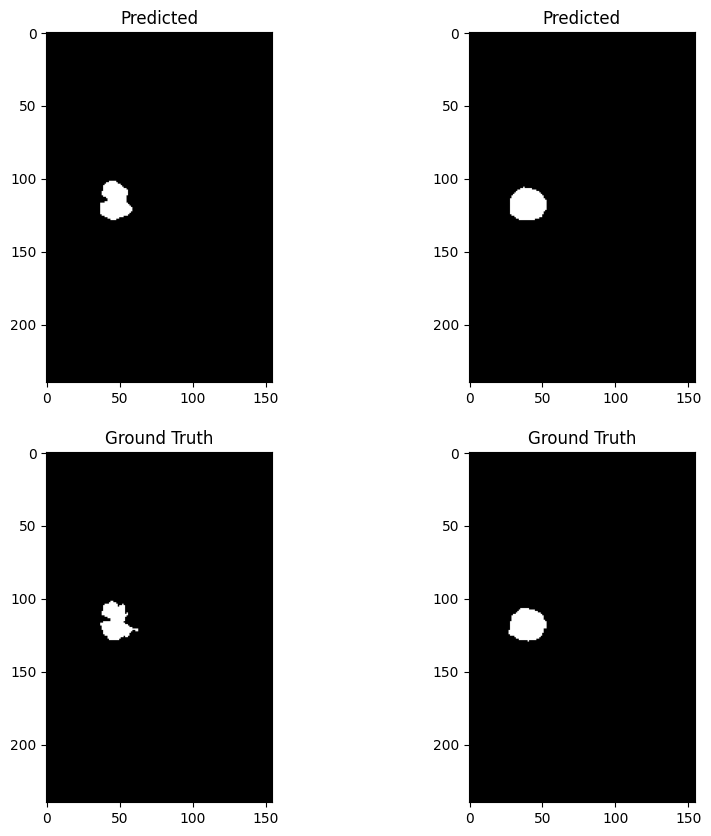

100%|██████████| 48/48 [02:52<00:00,  3.59s/it]


Average Validation Loss: 0.012639866132910052

Average Validation DSC: [0.99852627 0.87824171 0.89657246 0.70565535]
Average Validation ASSD: [ 0.14444372 14.3508732  19.66825574 32.17684894]
Epoch 29/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


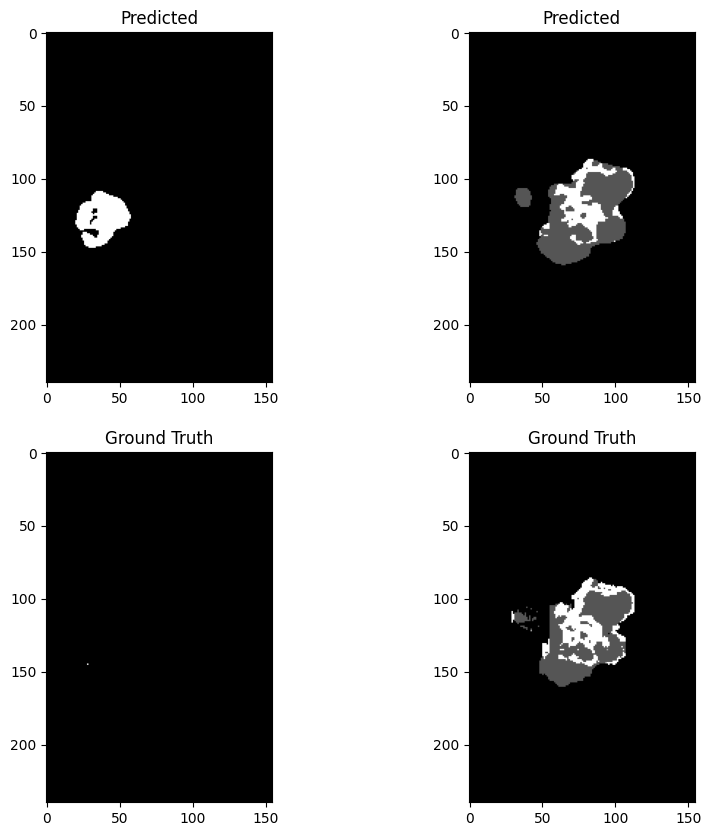

100%|██████████| 189/189 [12:00<00:00,  3.81s/it]



Average Training Loss: 0.011149535312874135

Average Training DSC: [0.99867394 0.89068148 0.91281058 0.72872567]
Average Training ASSD: [ 0.12838836 11.77196867 15.09616067 32.04685986]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


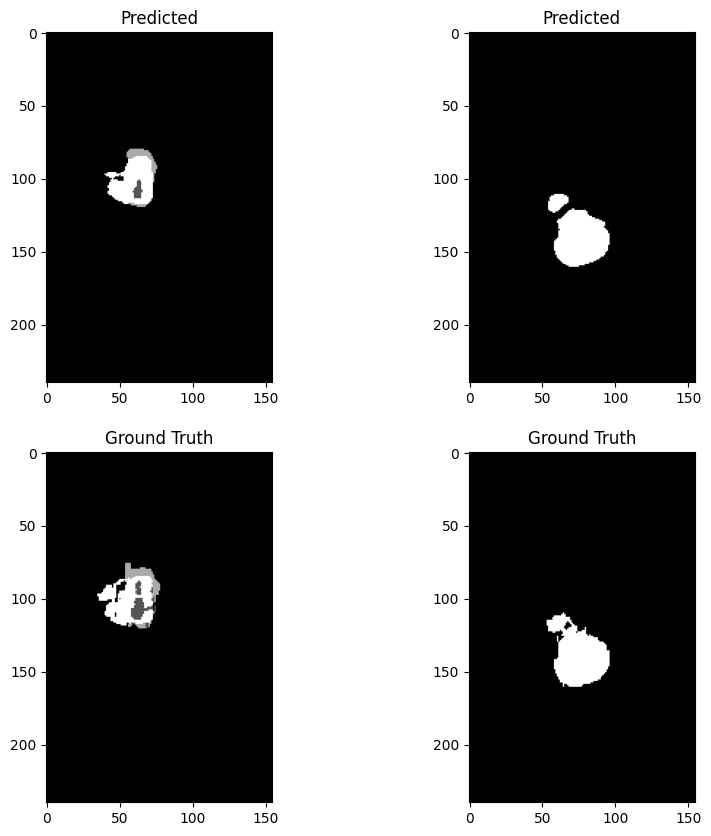

100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Average Validation Loss: 0.012869890488218516

Average Validation DSC: [0.99838328 0.87556074 0.89602107 0.72729949]
Average Validation ASSD: [ 0.15478907 12.61004639 17.89153359 28.37868072]
Epoch 30/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


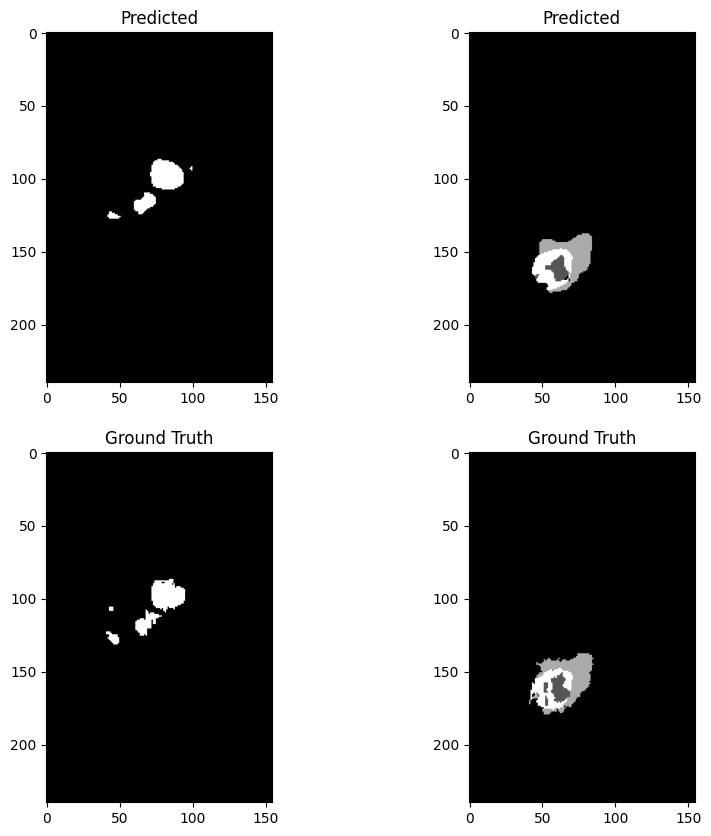

100%|██████████| 189/189 [12:01<00:00,  3.82s/it]



Average Training Loss: 0.010719010897138446

Average Training DSC: [0.99874284 0.8916956  0.92241142 0.73386644]
Average Training ASSD: [ 0.12193427 12.11765286 12.31093688 32.31349925]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


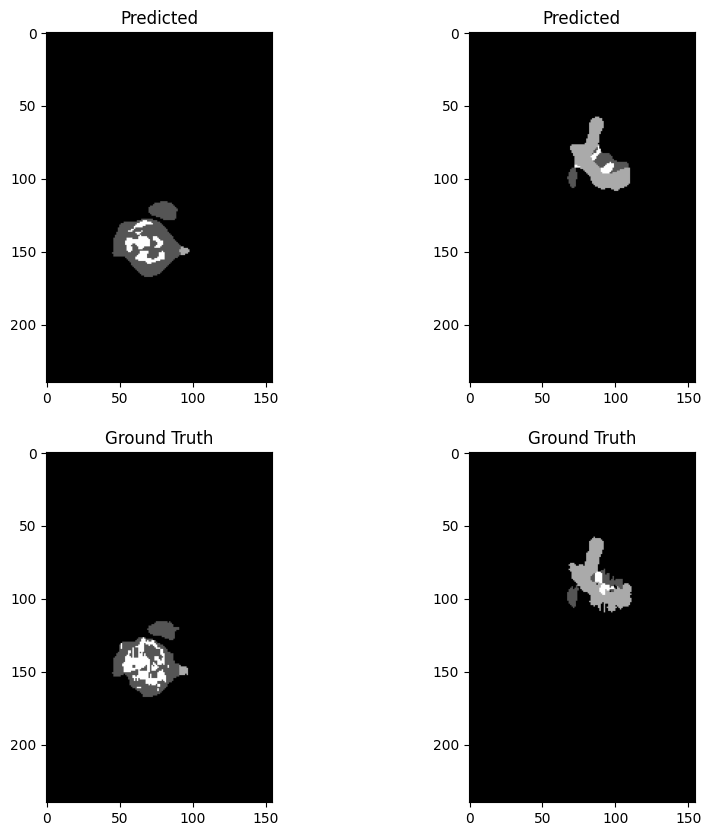

100%|██████████| 48/48 [02:48<00:00,  3.51s/it]


Average Validation Loss: 0.012432257314988723

Average Validation DSC: [0.99863653 0.85926939 0.90244155 0.6925334 ]
Average Validation ASSD: [ 0.14164835 21.27368166 18.34146348 42.09342118]
Epoch 31/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


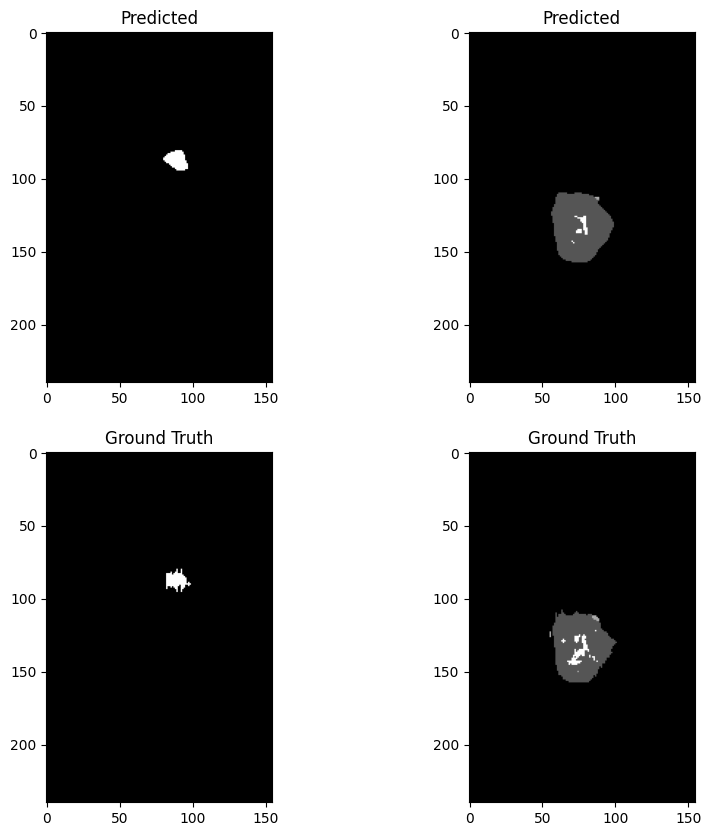

100%|██████████| 189/189 [11:37<00:00,  3.69s/it]



Average Training Loss: 0.011006511802041026

Average Training DSC: [0.99872012 0.88606964 0.9163845  0.73435183]
Average Training ASSD: [ 0.12522281 13.56922514 14.14415482 30.20377805]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


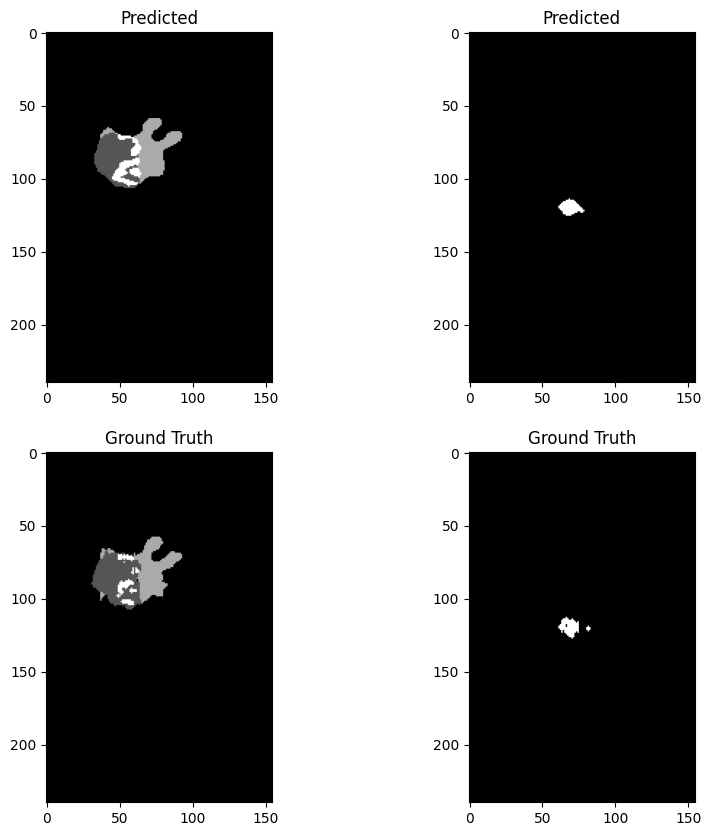

100%|██████████| 48/48 [02:45<00:00,  3.46s/it]


Average Validation Loss: 0.012133689500236263

Average Validation DSC: [0.99861981 0.87923816 0.88787301 0.73226607]
Average Validation ASSD: [ 0.13728069 13.63325691 23.60389693 27.15482926]
Epoch 32/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


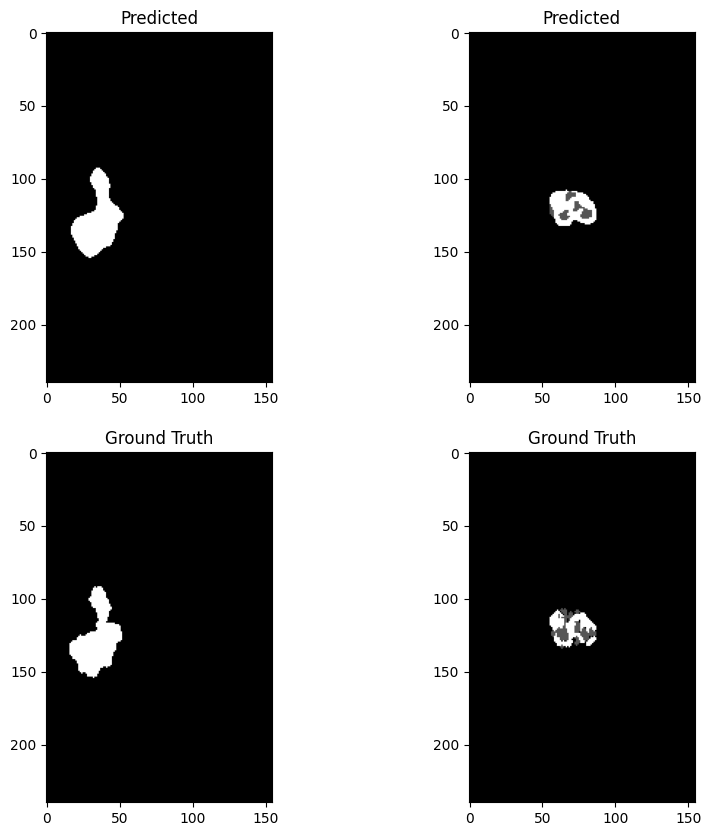

100%|██████████| 189/189 [12:04<00:00,  3.83s/it]



Average Training Loss: 0.01042675741618036

Average Training DSC: [0.99875169 0.89724988 0.92355928 0.74062077]
Average Training ASSD: [ 0.12148805 10.84838102 12.135102   30.5109266 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


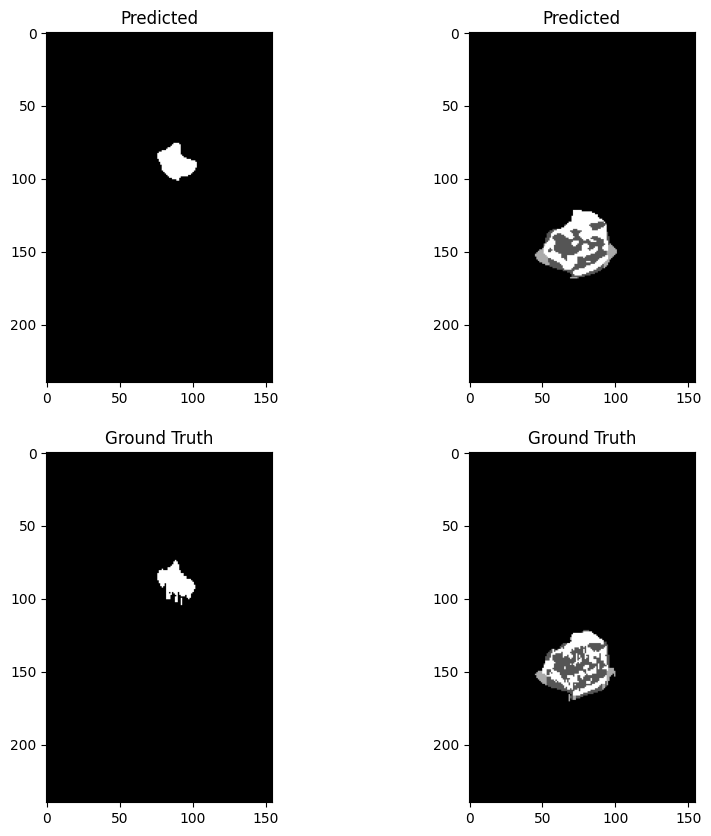

100%|██████████| 48/48 [02:52<00:00,  3.59s/it]


Average Validation Loss: 0.012294801922204593

Average Validation DSC: [0.99867598 0.87275109 0.87719379 0.72972806]
Average Validation ASSD: [ 0.13373237 13.89830176 25.10714424 27.25637076]
Epoch 33/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


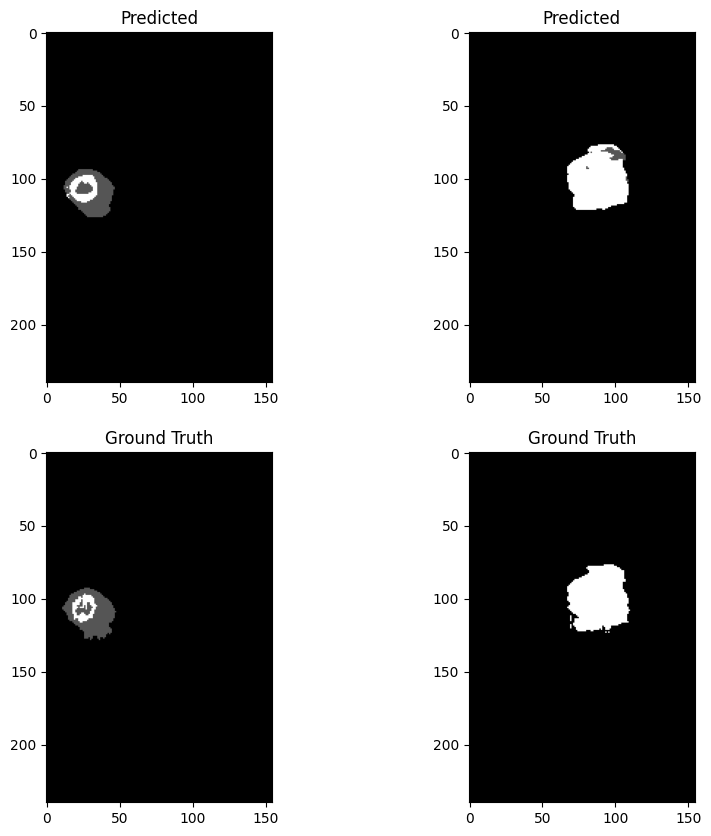

100%|██████████| 189/189 [11:51<00:00,  3.76s/it]



Average Training Loss: 0.010991574844059647

Average Training DSC: [0.99875579 0.88806222 0.91184044 0.73711026]
Average Training ASSD: [ 0.12123628 12.96349164 15.37288515 29.87950612]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


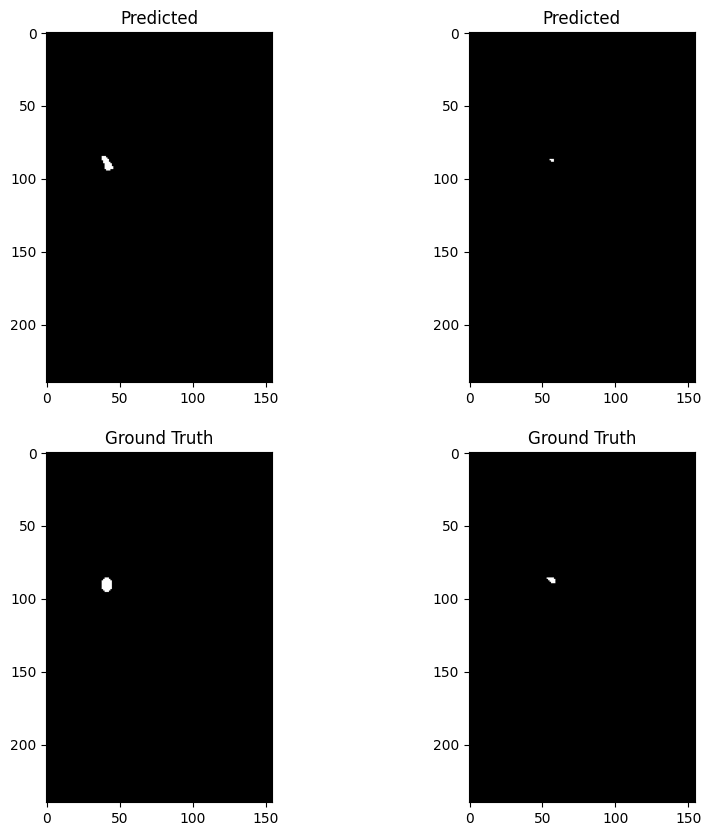

100%|██████████| 48/48 [02:38<00:00,  3.29s/it]


Average Validation Loss: 0.012371107004582882

Average Validation DSC: [0.99865798 0.86985812 0.89262023 0.69076151]
Average Validation ASSD: [ 0.14654637 16.134593   20.55543149 43.26085604]
Epoch 34/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


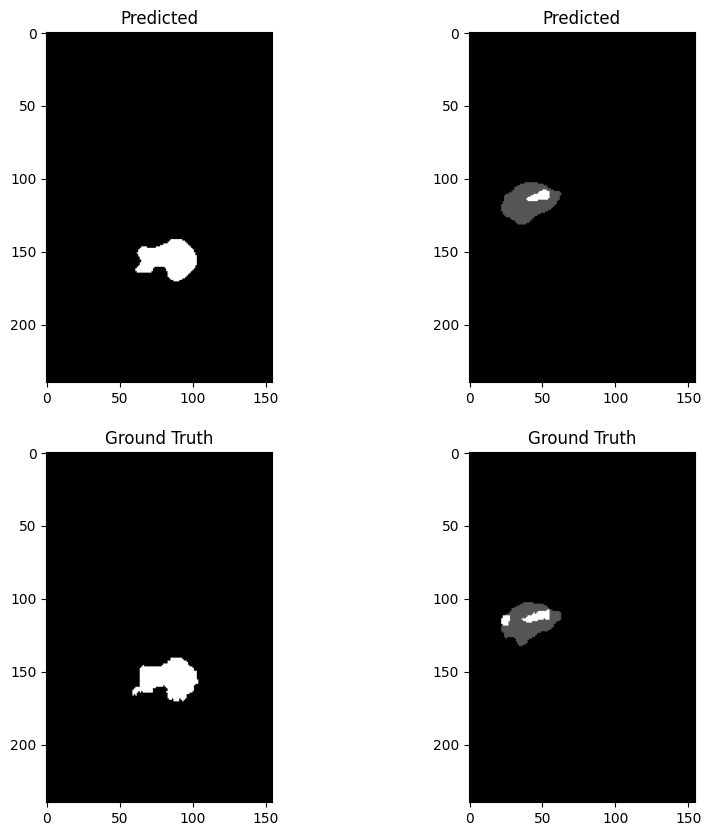

100%|██████████| 189/189 [11:38<00:00,  3.69s/it]



Average Training Loss: 0.009950985254907103

Average Training DSC: [0.99882592 0.89930303 0.9235571  0.74816499]
Average Training ASSD: [ 0.11383877 10.70406962 12.01156079 29.91325338]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


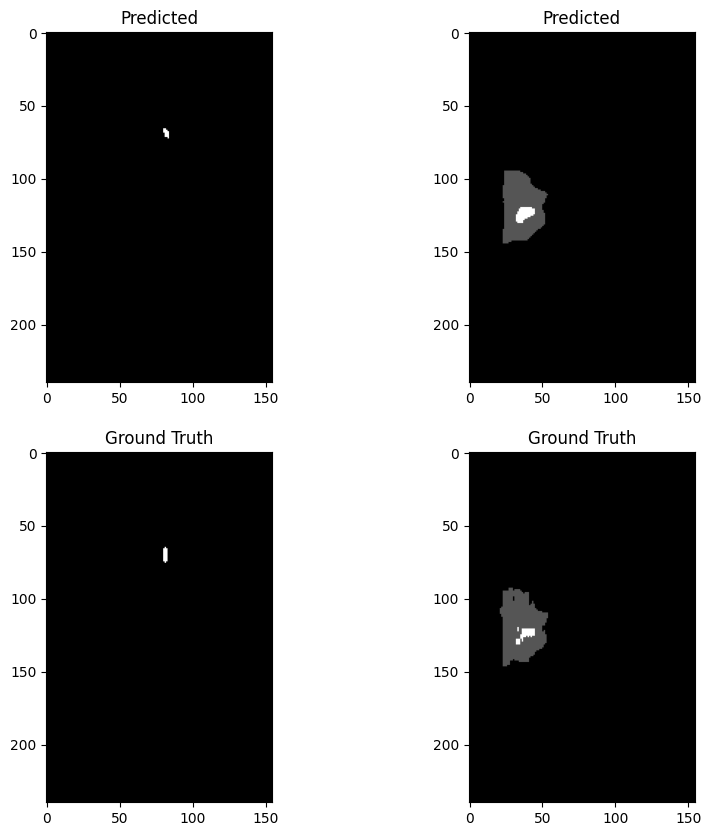

100%|██████████| 48/48 [02:51<00:00,  3.57s/it]


Average Validation Loss: 0.010997729298348228

Average Validation DSC: [0.99874786 0.88186882 0.90953823 0.72706183]
Average Validation ASSD: [ 0.13029459 14.42468663 15.7229833  37.31717   ]
Epoch 35/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


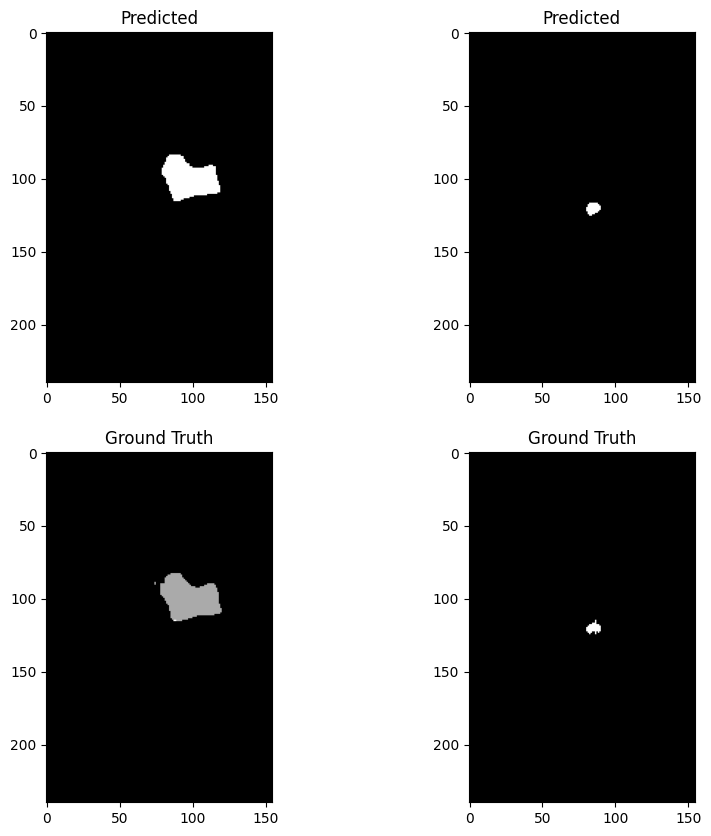

100%|██████████| 189/189 [11:46<00:00,  3.74s/it]



Average Training Loss: 0.00970329265923254

Average Training DSC: [0.99886955 0.89957045 0.92944153 0.75201021]
Average Training ASSD: [ 0.10963414 11.17123514 10.79706281 29.23214278]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


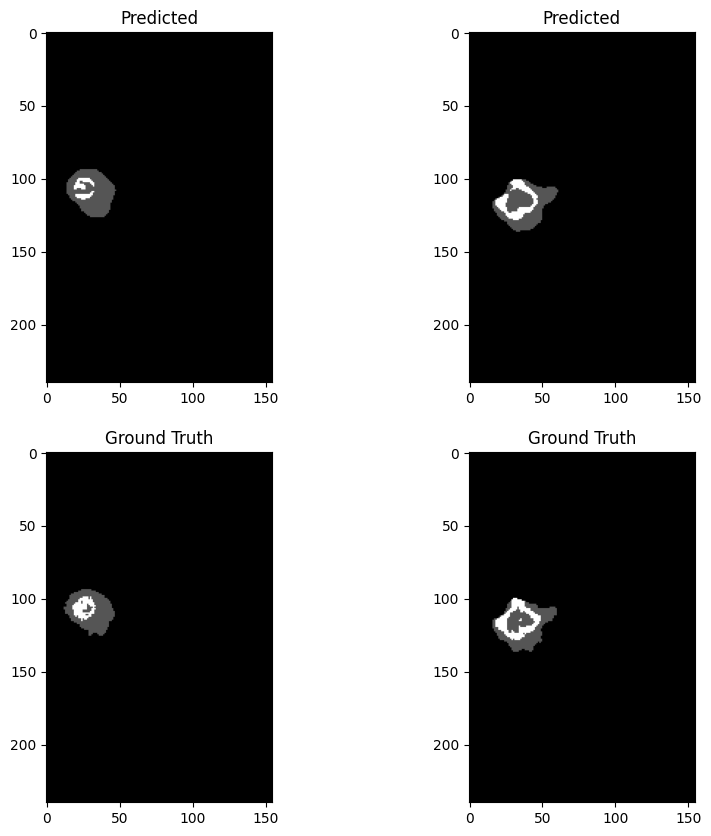

100%|██████████| 48/48 [02:51<00:00,  3.57s/it]


Average Validation Loss: 0.010826380438326547

Average Validation DSC: [0.99874241 0.89499408 0.91434635 0.74633411]
Average Validation ASSD: [ 0.11445678 10.52847146 15.20313199 26.34079117]
Epoch 36/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


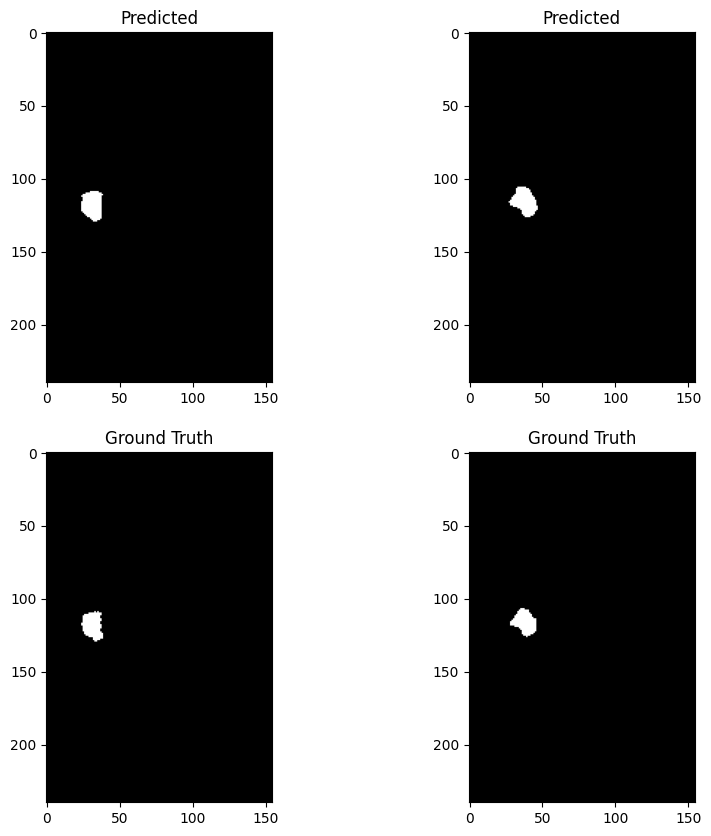

100%|██████████| 189/189 [11:57<00:00,  3.80s/it]



Average Training Loss: 0.009149867669240665

Average Training DSC: [0.99890828 0.90847167 0.93088526 0.76010847]
Average Training ASSD: [ 0.10606063  9.23592439 10.25064386 28.76942775]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


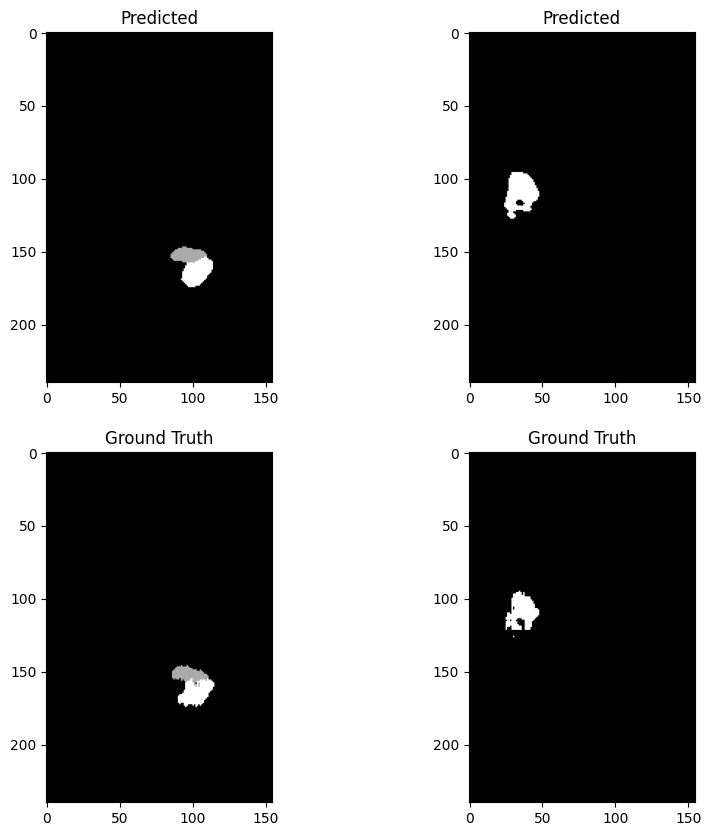

100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


Average Validation Loss: 0.011797720731313651

Average Validation DSC: [0.99859576 0.88987142 0.90993013 0.72492344]
Average Validation ASSD: [ 0.13280399 11.84081507 15.69201668 25.88331096]
Epoch 37/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


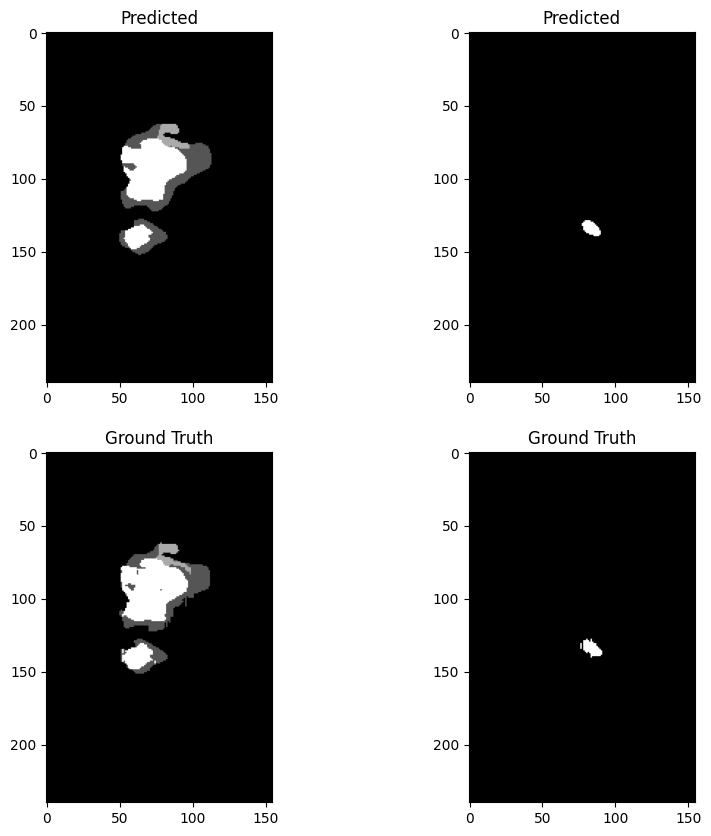

100%|██████████| 189/189 [11:51<00:00,  3.76s/it]



Average Training Loss: 0.009993169212802536

Average Training DSC: [0.99885309 0.89808375 0.92519009 0.75372795]
Average Training ASSD: [ 0.11031156 11.65423388 11.06871559 28.5857726 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


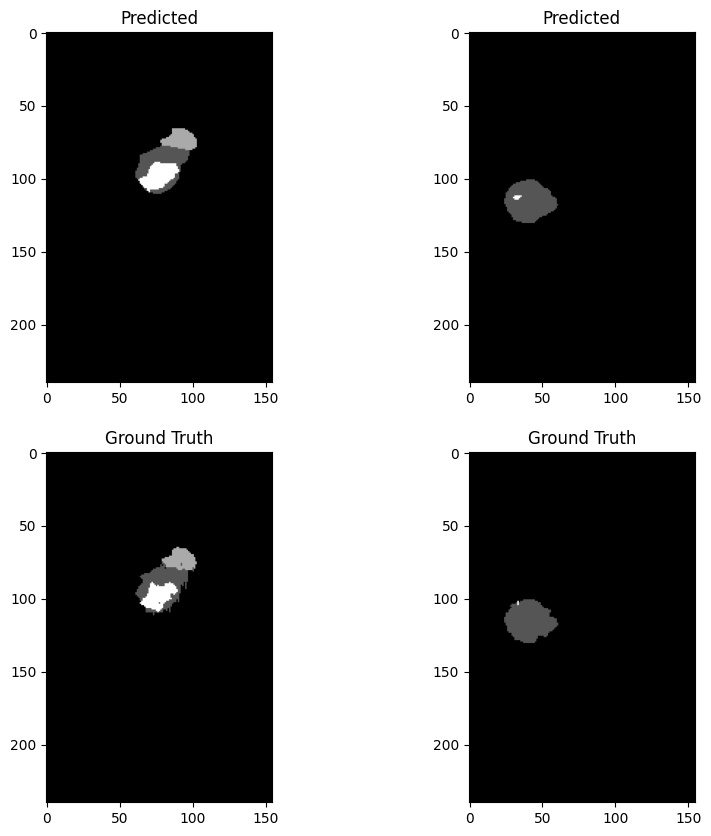

100%|██████████| 48/48 [02:53<00:00,  3.62s/it]


Average Validation Loss: 0.011347649163023258

Average Validation DSC: [0.99875177 0.87597076 0.89924764 0.73961773]
Average Validation ASSD: [ 0.13103245 15.58021274 19.35191816 26.22650791]
Epoch 38/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


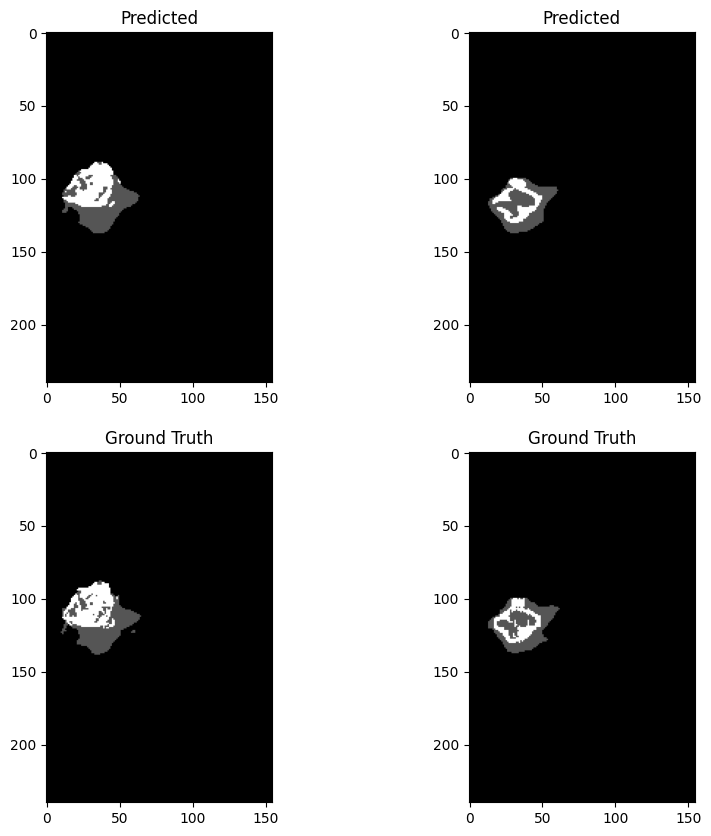

100%|██████████| 189/189 [11:50<00:00,  3.76s/it]



Average Training Loss: 0.009091614819471799

Average Training DSC: [0.99892642 0.90714337 0.93006573 0.76217765]
Average Training ASSD: [ 0.10399432  9.82812589 10.247782   28.20014011]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


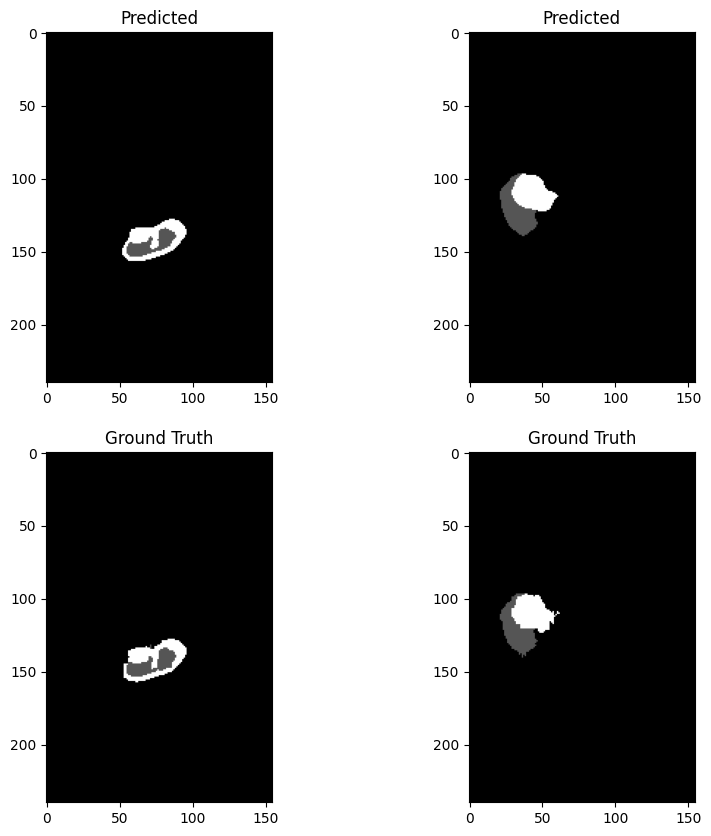

100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Average Validation Loss: 0.010570108861429617

Average Validation DSC: [0.99886052 0.90031096 0.90580983 0.74649919]
Average Validation ASSD: [ 0.1140602   9.80713969 18.3279459  25.66484289]
Epoch 39/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


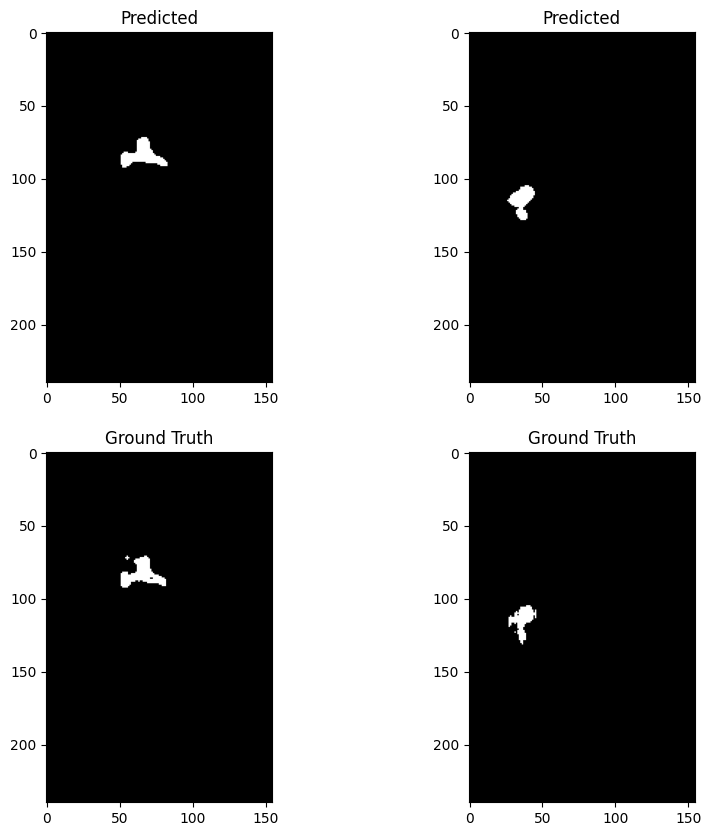

100%|██████████| 189/189 [11:57<00:00,  3.80s/it]



Average Training Loss: 0.009473063273444063

Average Training DSC: [0.99885784 0.89960611 0.92921865 0.76134652]
Average Training ASSD: [ 0.10787627 11.63686571 10.66010337 26.24805406]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


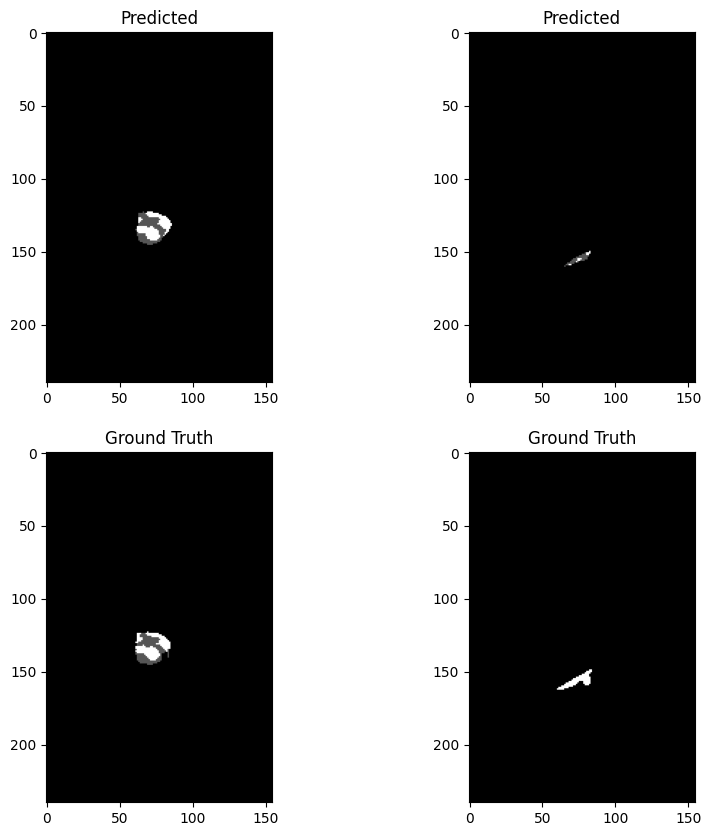

100%|██████████| 48/48 [02:53<00:00,  3.62s/it]


Average Validation Loss: 0.011594191135372967

Average Validation DSC: [0.99868047 0.87632823 0.9016111  0.72563991]
Average Validation ASSD: [ 0.13511204 18.63156138 17.58274083 33.60908572]
Epoch 40/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


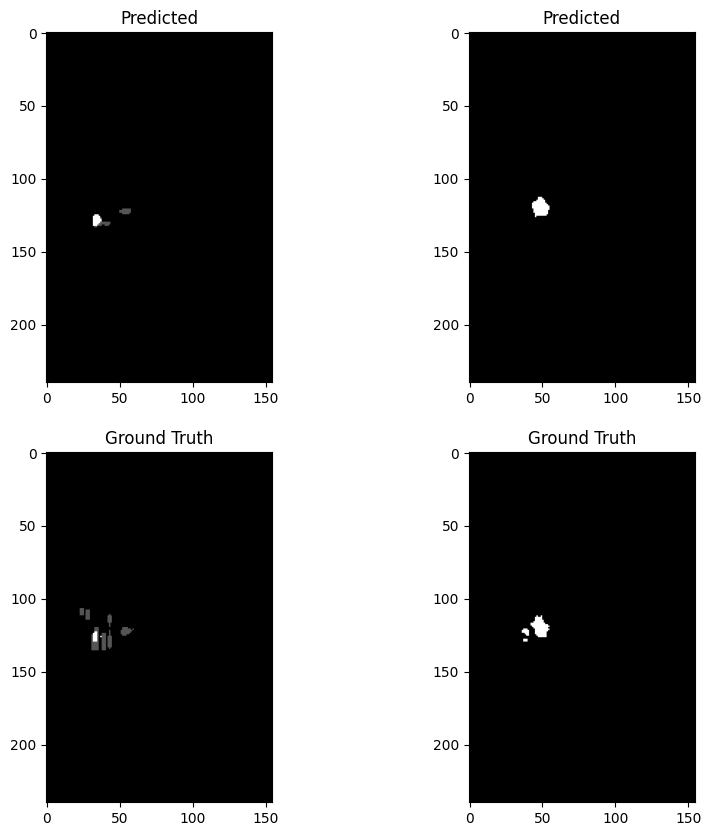

100%|██████████| 189/189 [12:02<00:00,  3.83s/it]



Average Training Loss: 0.008610129696390932

Average Training DSC: [0.99899785 0.90931355 0.93358112 0.77056468]
Average Training ASSD: [ 0.0968025  10.05089421  9.80475288 27.22006019]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


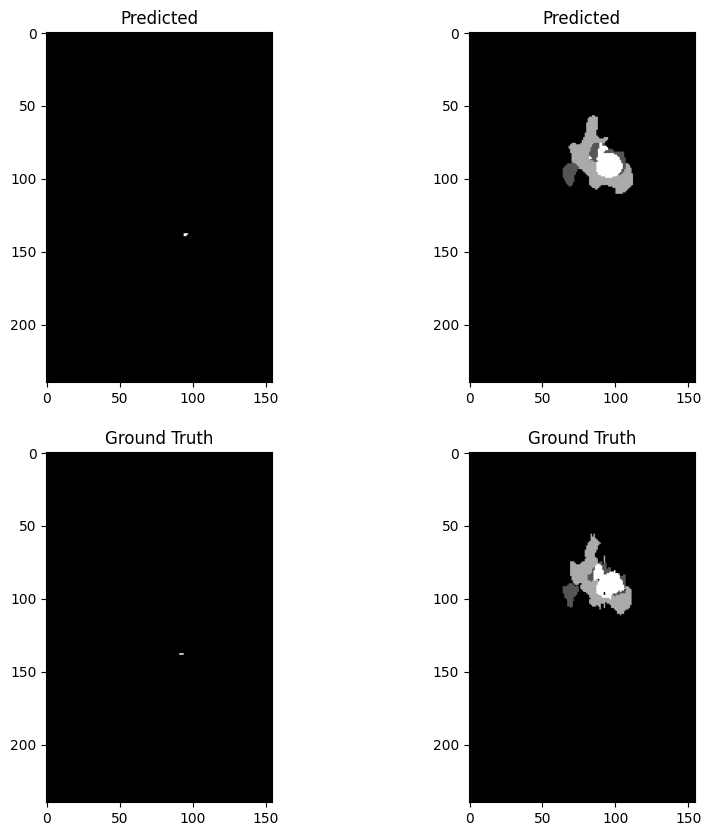

100%|██████████| 48/48 [02:48<00:00,  3.51s/it]


Average Validation Loss: 0.010674674432569494

Average Validation DSC: [0.99884916 0.88879912 0.91741406 0.76564223]
Average Validation ASSD: [ 0.10661892 11.34239075 13.09812168 16.70436652]
Epoch 41/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


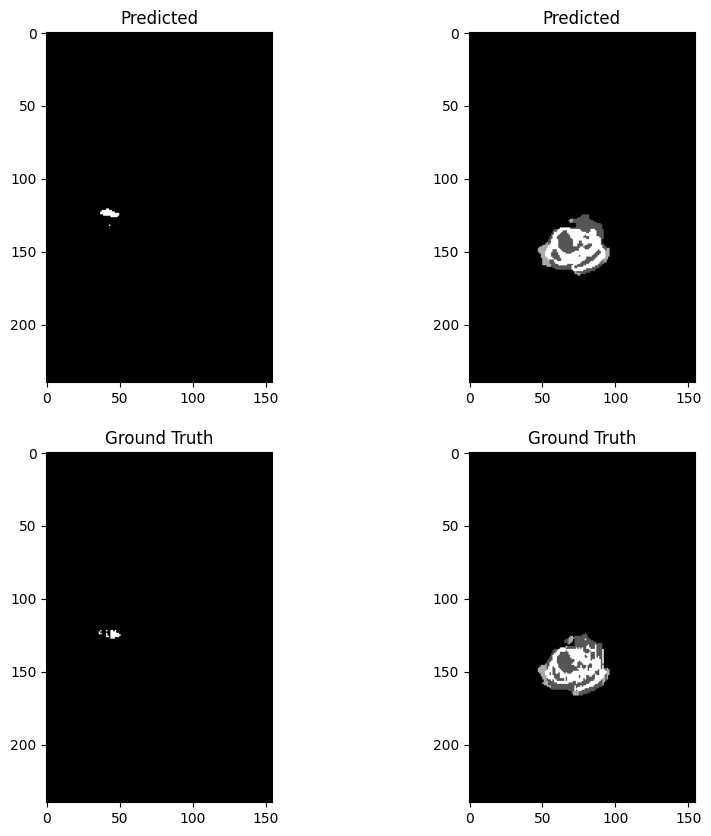

100%|██████████| 189/189 [11:52<00:00,  3.77s/it]



Average Training Loss: 0.0087141336493746

Average Training DSC: [0.99897593 0.91106999 0.93501715 0.76911598]
Average Training ASSD: [ 0.09854977  9.21290307  9.21203884 28.39727299]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


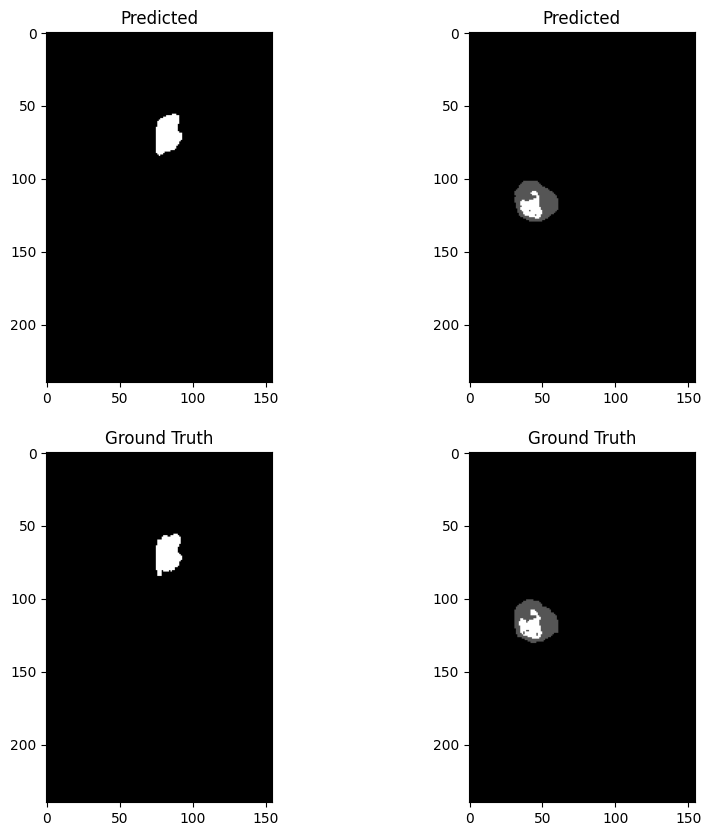

100%|██████████| 48/48 [02:51<00:00,  3.58s/it]


Average Validation Loss: 0.01020695508729356

Average Validation DSC: [0.99887197 0.90222603 0.9103924  0.73971237]
Average Validation ASSD: [ 0.11024961  9.63304017 14.83918759 32.88702421]
Epoch 42/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


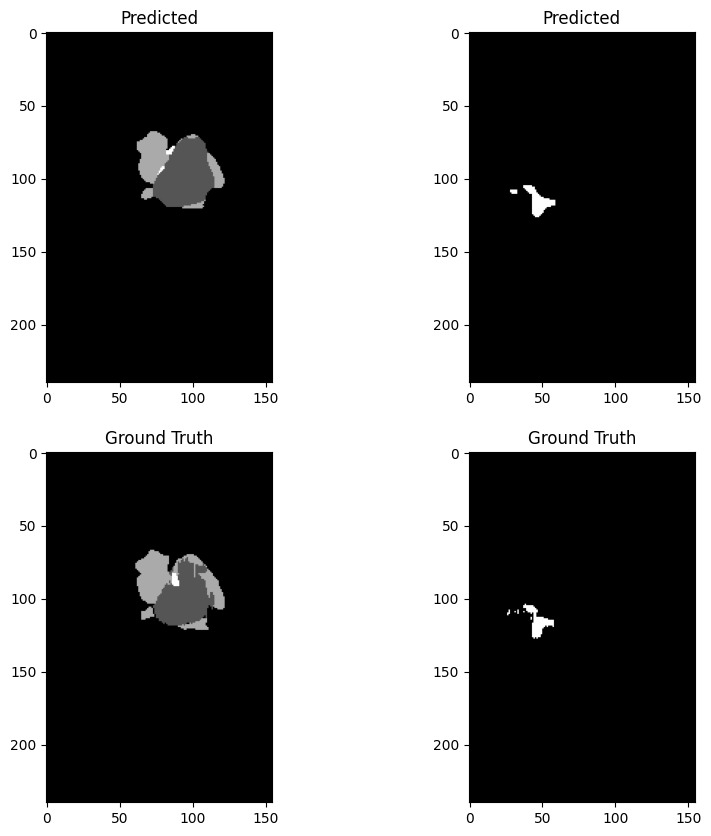

100%|██████████| 189/189 [12:11<00:00,  3.87s/it]



Average Training Loss: 0.009300640914786272

Average Training DSC: [0.99894372 0.90321579 0.9266893  0.76392741]
Average Training ASSD: [ 0.10137542 10.73798237 11.44499846 26.36762161]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


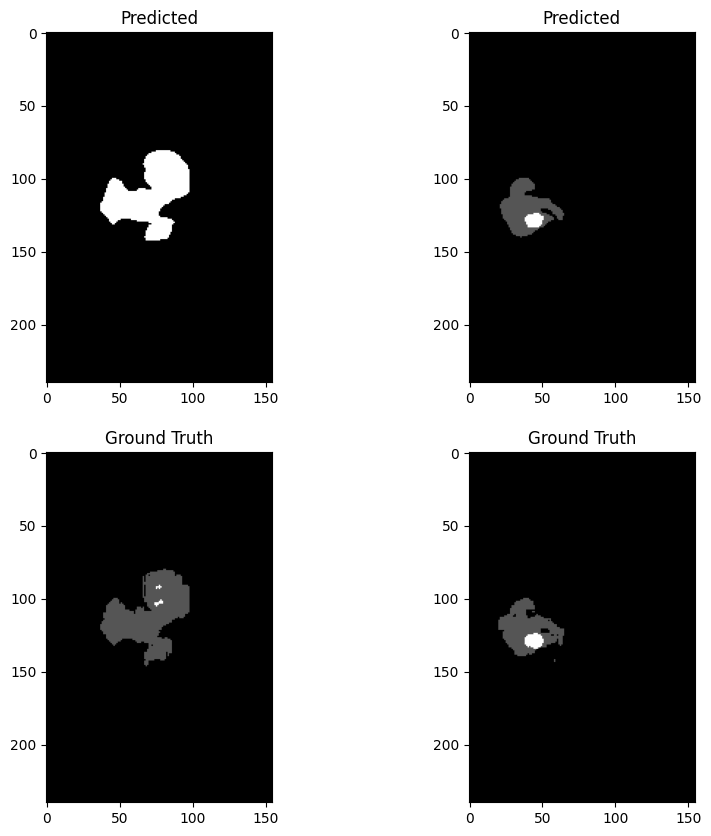

100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Average Validation Loss: 0.010137326617647583

Average Validation DSC: [0.9988763  0.90011136 0.91893746 0.76680158]
Average Validation ASSD: [ 0.10553715 10.82844784 13.73917175 19.2848081 ]
Epoch 43/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


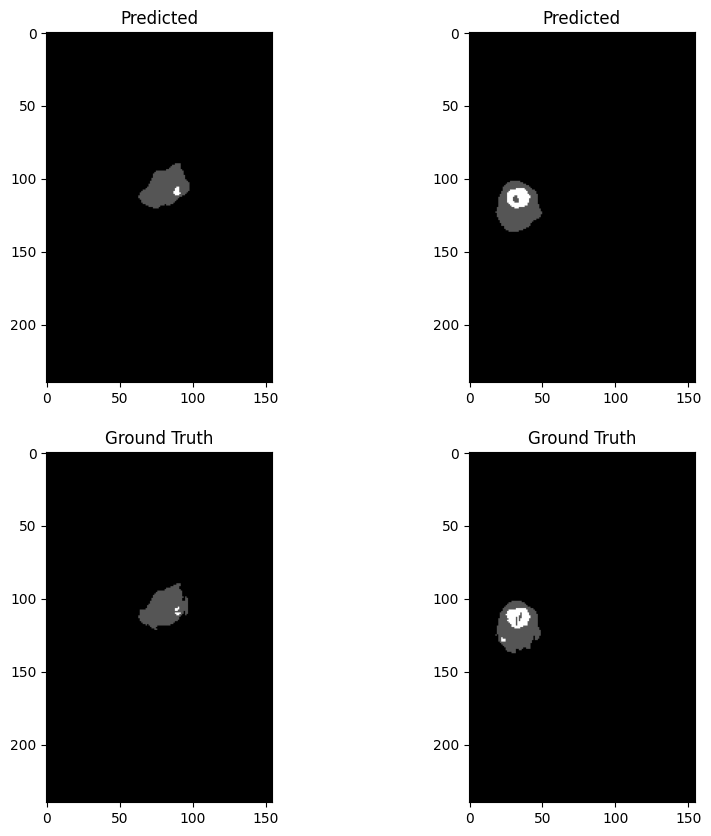

100%|██████████| 189/189 [11:42<00:00,  3.72s/it]



Average Training Loss: 0.008797115158467065

Average Training DSC: [0.99901258 0.91154307 0.92458651 0.77434508]
Average Training ASSD: [ 0.0954064   9.50423991 12.74878243 26.07480301]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


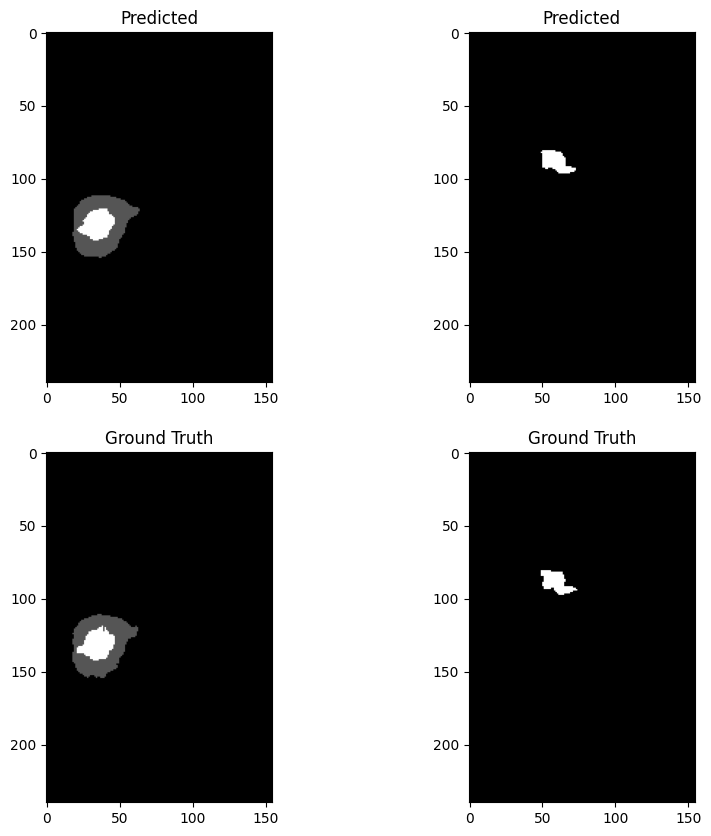

100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Average Validation Loss: 0.010020704697429514

Average Validation DSC: [0.99889294 0.90396734 0.91613712 0.77028752]
Average Validation ASSD: [ 0.1108179  10.55573797 14.46502984 23.74555363]
Epoch 44/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


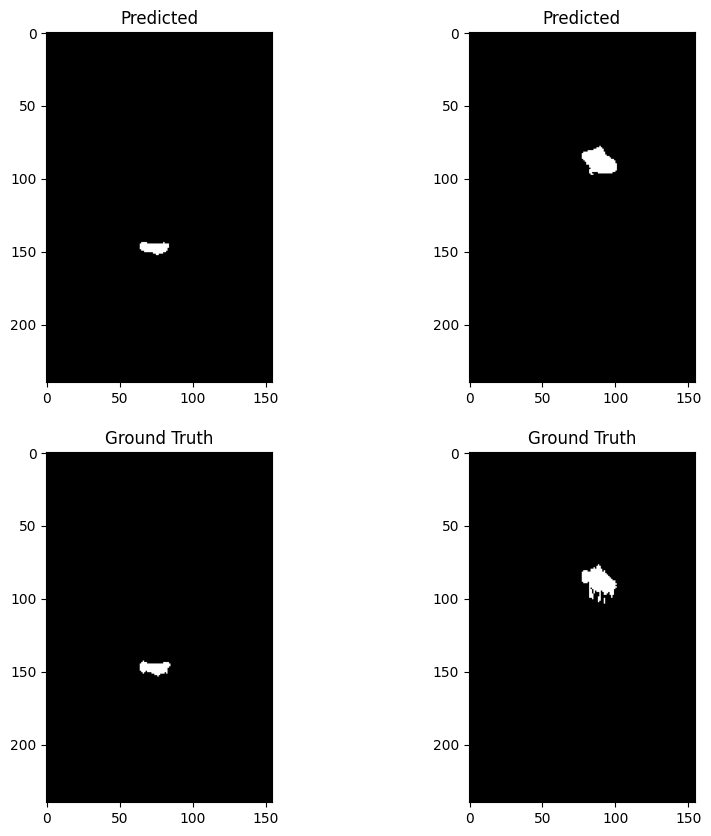

100%|██████████| 189/189 [12:03<00:00,  3.83s/it]



Average Training Loss: 0.00876920824752204

Average Training DSC: [0.99897674 0.91239008 0.92897521 0.77329704]
Average Training ASSD: [ 0.09887703  8.96684864 10.92220897 25.6090931 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


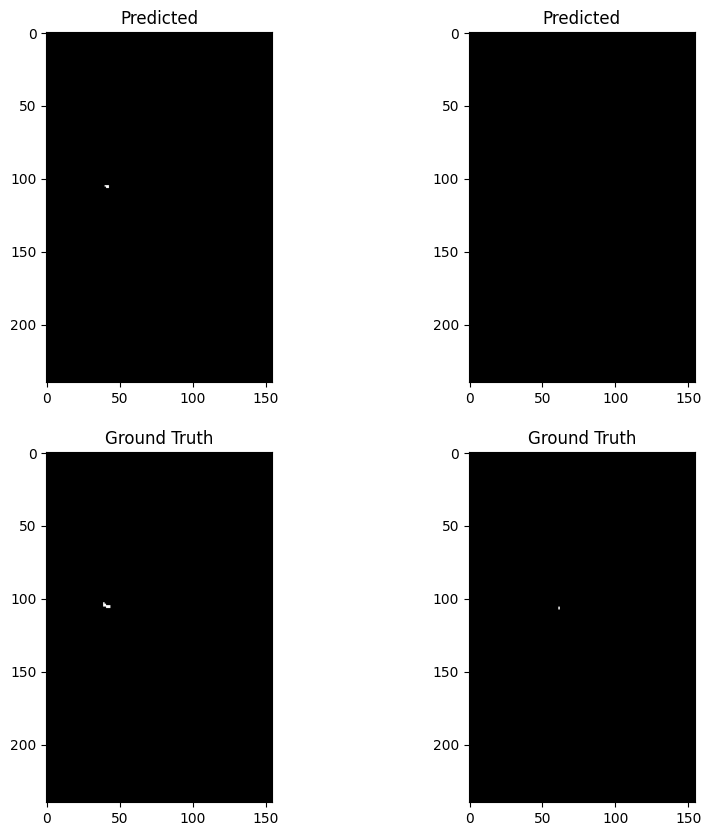

100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


Average Validation Loss: 0.00978392162748302

Average Validation DSC: [0.99890293 0.907871   0.91730042 0.76163271]
Average Validation ASSD: [ 0.10869243  8.46864573 13.53984724 24.55926019]
Epoch 45/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


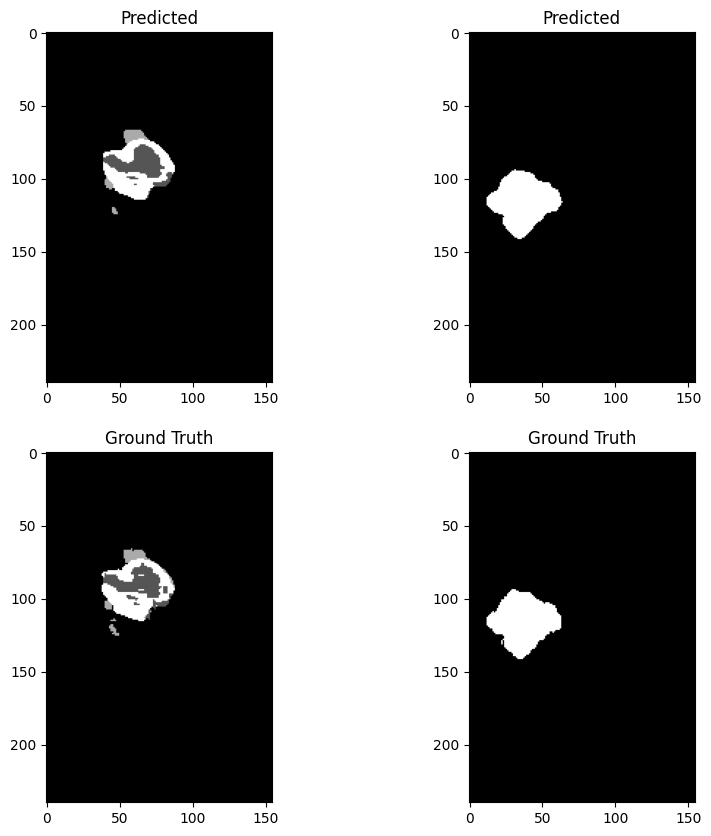

100%|██████████| 189/189 [11:46<00:00,  3.74s/it]



Average Training Loss: 0.008599181341687365

Average Training DSC: [0.99897023 0.91269944 0.93252753 0.77379724]
Average Training ASSD: [ 0.09987984  9.31529553 10.57318464 26.73937208]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


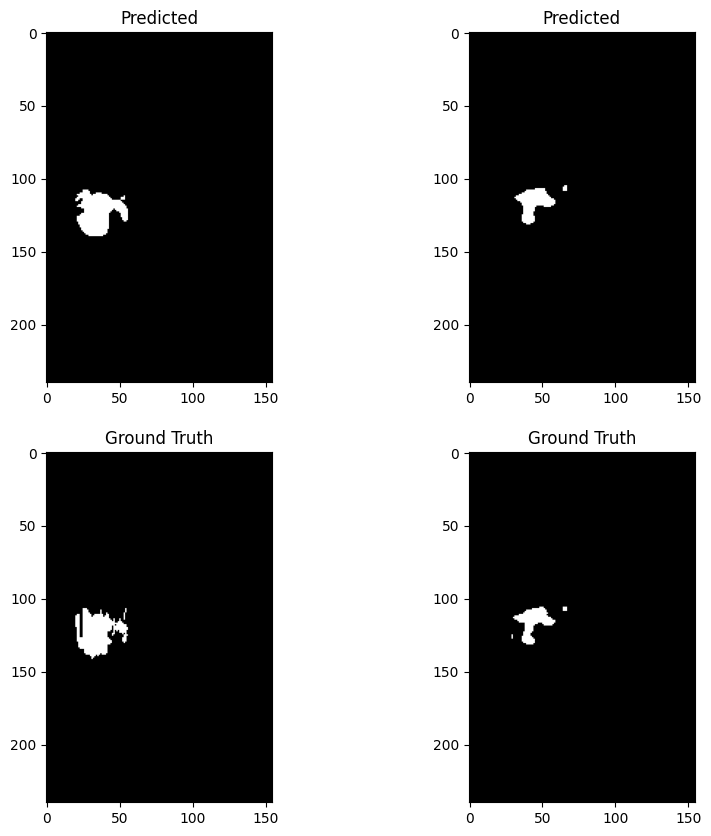

100%|██████████| 48/48 [02:54<00:00,  3.63s/it]


Average Validation Loss: 0.00997807773334595

Average Validation DSC: [0.99882952 0.89259893 0.91435598 0.76032735]
Average Validation ASSD: [ 0.11380078 13.41980655 14.2906808  24.74696025]
Epoch 46/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


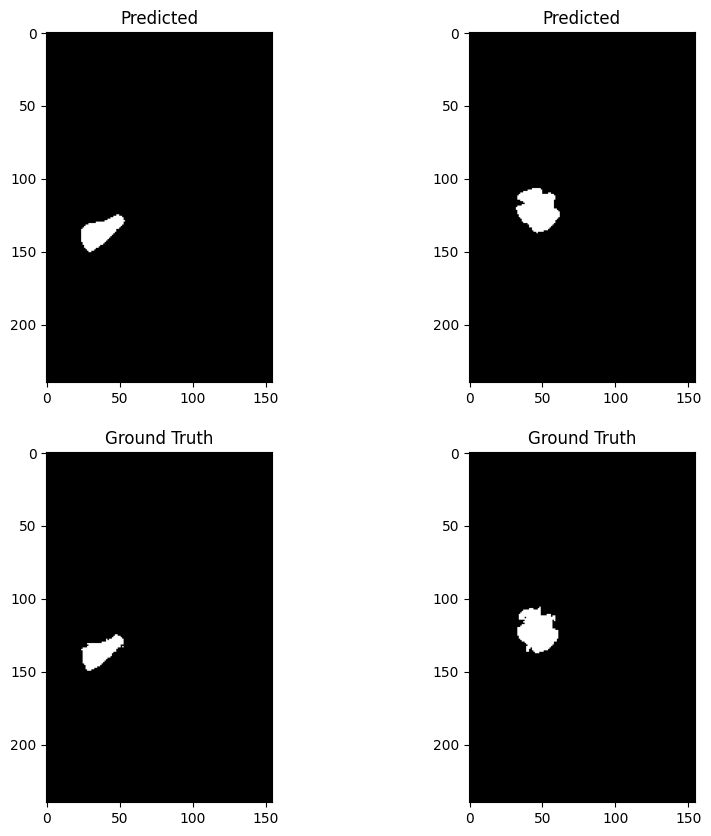

100%|██████████| 189/189 [11:49<00:00,  3.75s/it]



Average Training Loss: 0.007961224771976944

Average Training DSC: [0.99907577 0.91753844 0.93739528 0.78241603]
Average Training ASSD: [ 0.08872866  8.63533567  8.7182887  25.72498079]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


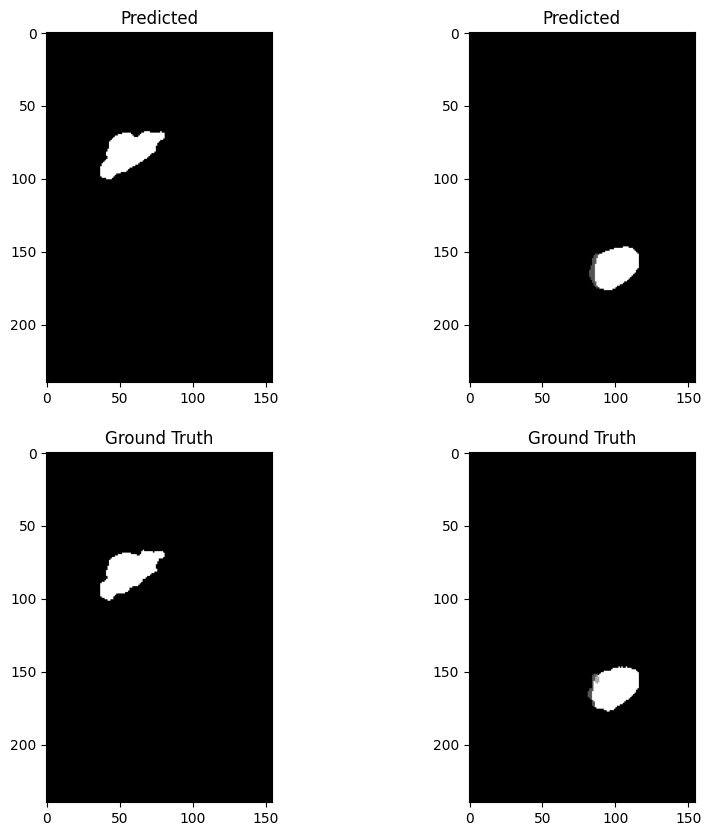

100%|██████████| 48/48 [02:44<00:00,  3.44s/it]


Average Validation Loss: 0.009028326506571224

Average Validation DSC: [0.99899631 0.91458274 0.92301627 0.77765254]
Average Validation ASSD: [ 0.09911866  7.23482798 12.14005273 24.75902716]
Epoch 47/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


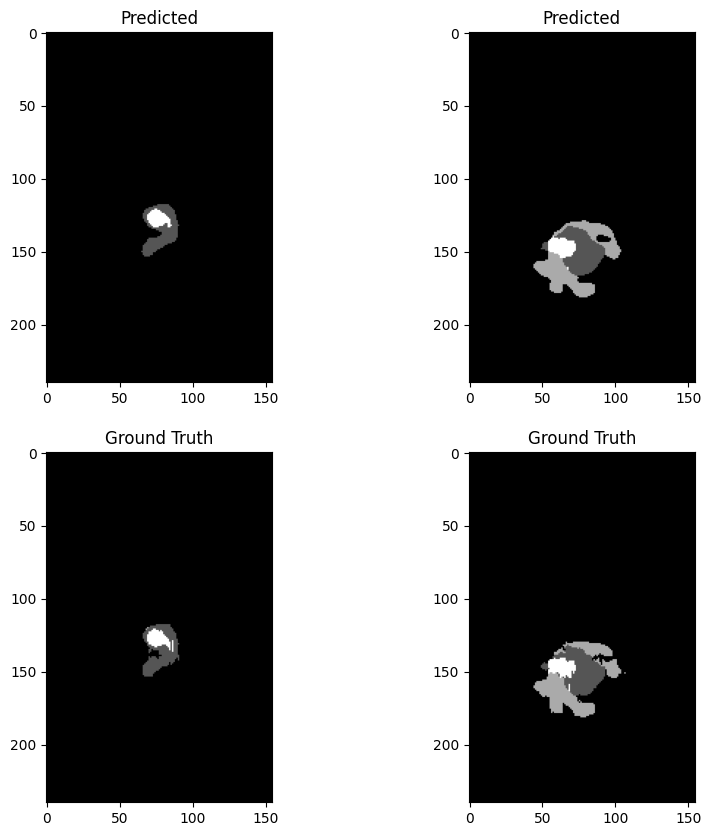

100%|██████████| 189/189 [11:32<00:00,  3.66s/it]



Average Training Loss: 0.007543829863486939

Average Training DSC: [0.99912207 0.91970329 0.94349619 0.79331466]
Average Training ASSD: [ 0.08270371  8.44158587  7.54583537 23.60770088]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


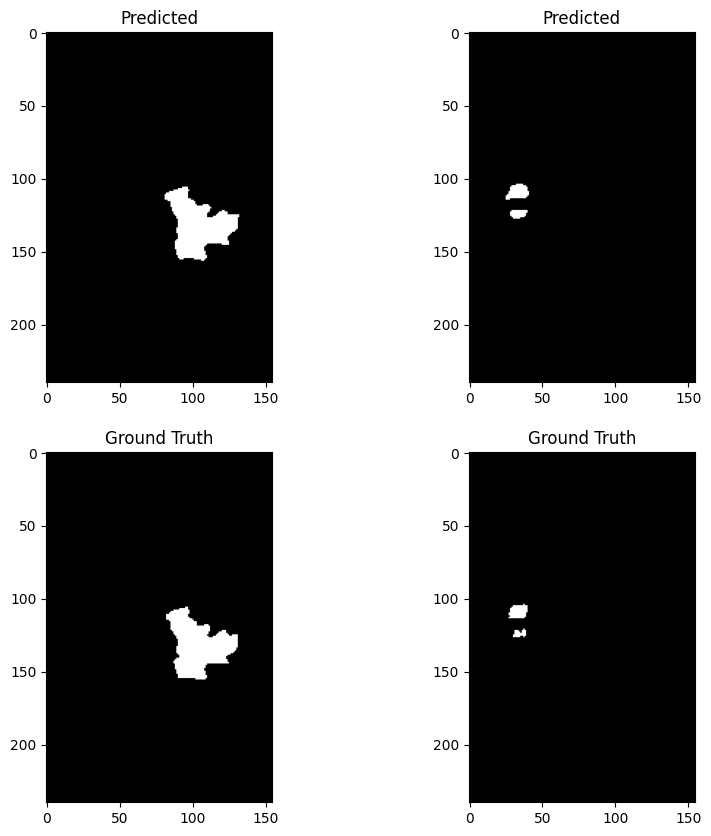

100%|██████████| 48/48 [02:37<00:00,  3.28s/it]


Average Validation Loss: 0.009667276918965703

Average Validation DSC: [0.99891438 0.90731922 0.92203847 0.74857628]
Average Validation ASSD: [ 0.10218292  8.68241511 13.99664422 29.3603171 ]
Epoch 48/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


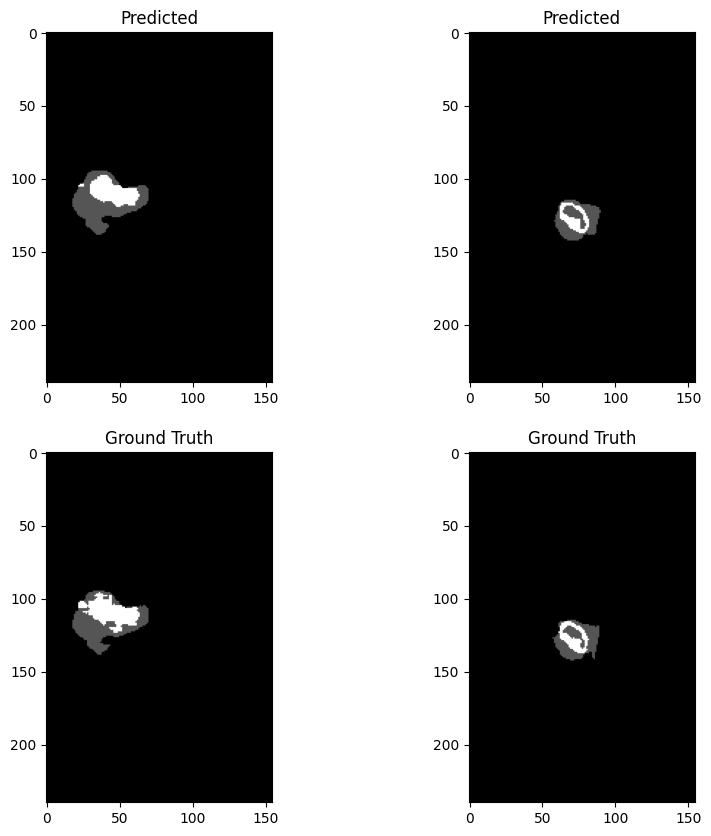

100%|██████████| 189/189 [11:16<00:00,  3.58s/it]



Average Training Loss: 0.007924113612346075

Average Training DSC: [0.99905663 0.91522667 0.93579127 0.78607003]
Average Training ASSD: [ 0.08949248  8.58389389 10.11813064 23.91797151]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


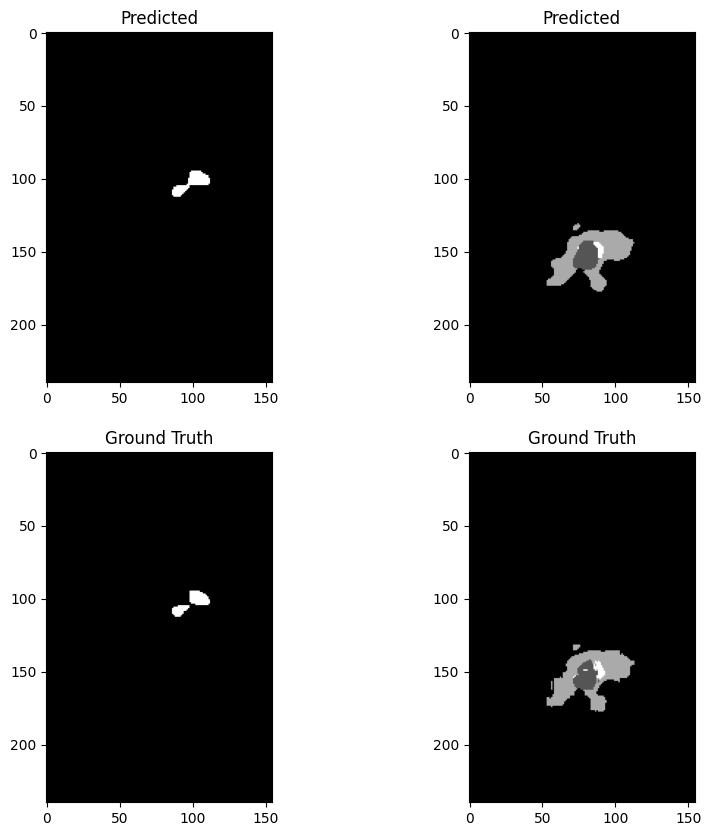

100%|██████████| 48/48 [02:39<00:00,  3.33s/it]


Average Validation Loss: 0.008931686927098781

Average Validation DSC: [0.99900923 0.91094547 0.9232531  0.78481402]
Average Validation ASSD: [ 0.09533605  7.60747502 13.33502004 18.07386586]
Epoch 49/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


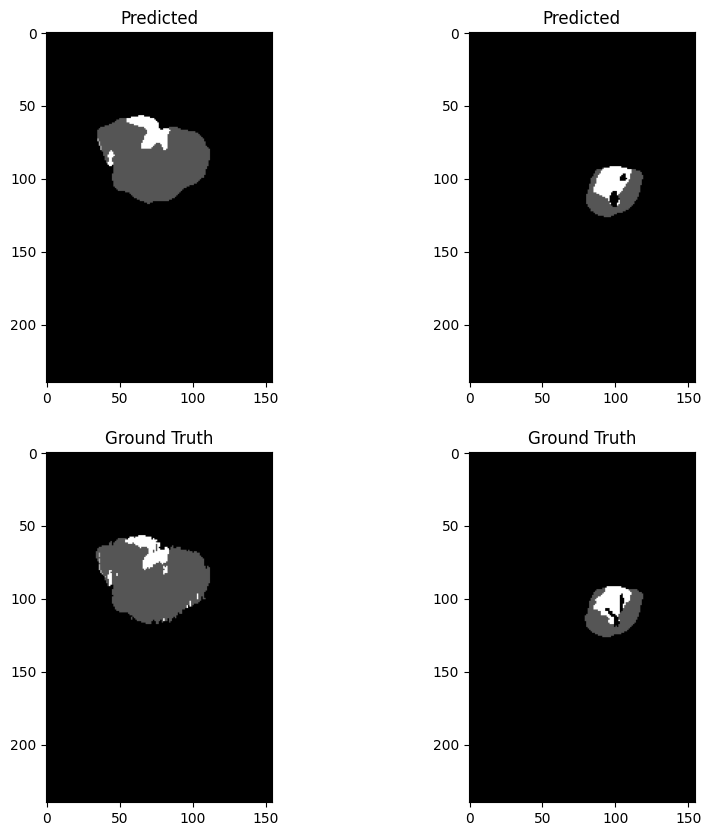

100%|██████████| 189/189 [11:26<00:00,  3.63s/it]



Average Training Loss: 0.008537520868851551

Average Training DSC: [0.99899873 0.90741351 0.93227757 0.78210877]
Average Training ASSD: [ 0.09853197 10.57417708 10.57968514 22.55986866]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


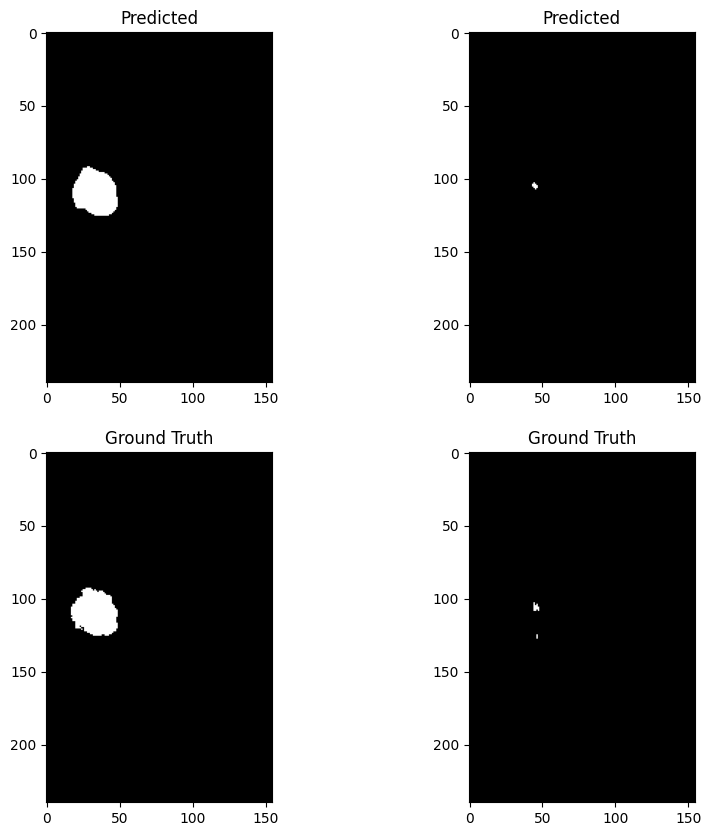

100%|██████████| 48/48 [02:44<00:00,  3.42s/it]


Average Validation Loss: 0.009985670660777638

Average Validation DSC: [0.99890536 0.89699522 0.90959621 0.75434582]
Average Validation ASSD: [ 0.11494451 12.91237355 15.17880878 28.87801533]
Epoch 50/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


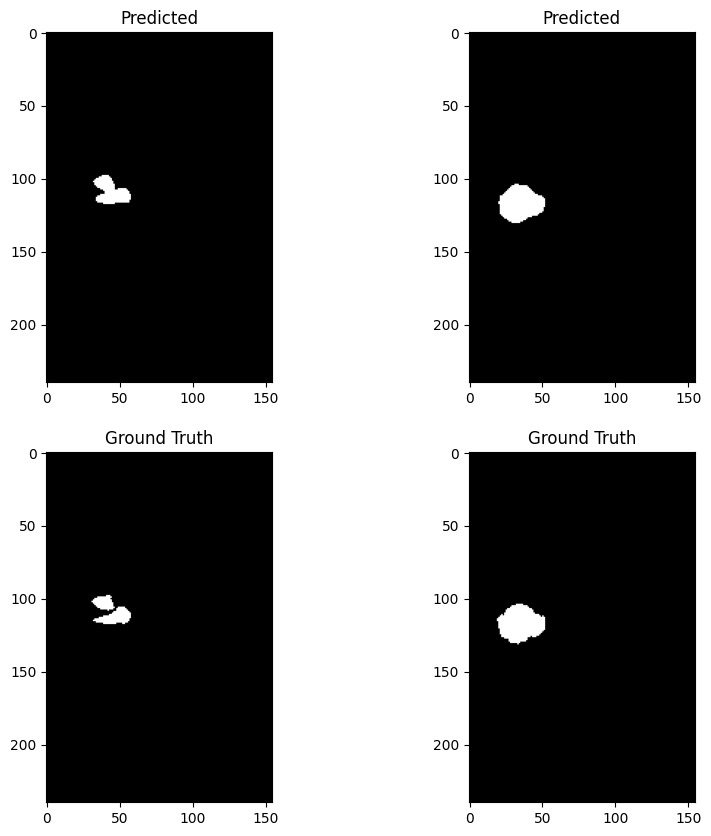

100%|██████████| 189/189 [11:49<00:00,  3.75s/it]



Average Training Loss: 0.0076485612828816685

Average Training DSC: [0.99912063 0.92271852 0.93827583 0.79296616]
Average Training ASSD: [ 0.08447817  7.59558646  9.63936088 23.23407461]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


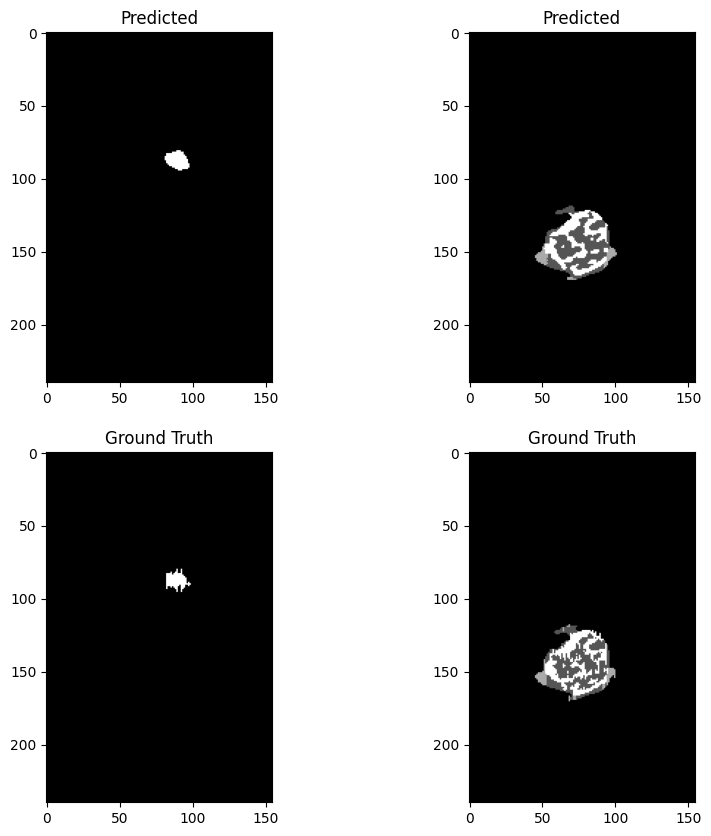

100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Average Validation Loss: 0.008772172111396989

Average Validation DSC: [0.9990439  0.91504958 0.92461156 0.77947923]
Average Validation ASSD: [ 0.0959857   9.09585052 13.00246738 23.84522221]
Epoch 51/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


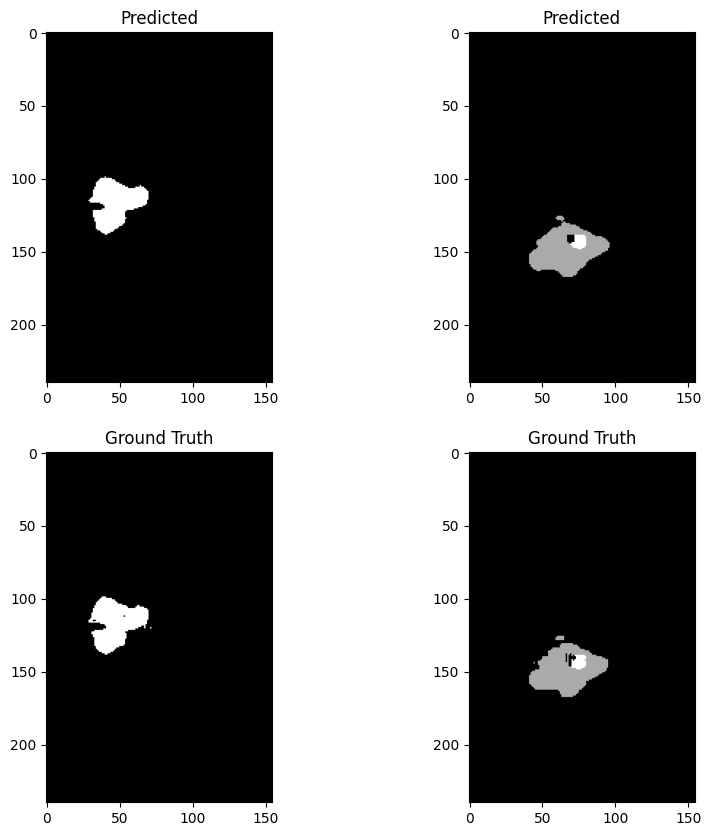

100%|██████████| 189/189 [11:57<00:00,  3.80s/it]



Average Training Loss: 0.0067290339357756745

Average Training DSC: [0.99920652 0.93048872 0.94630032 0.806664  ]
Average Training ASSD: [ 0.07655387  6.12894122  7.56619159 23.06891891]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


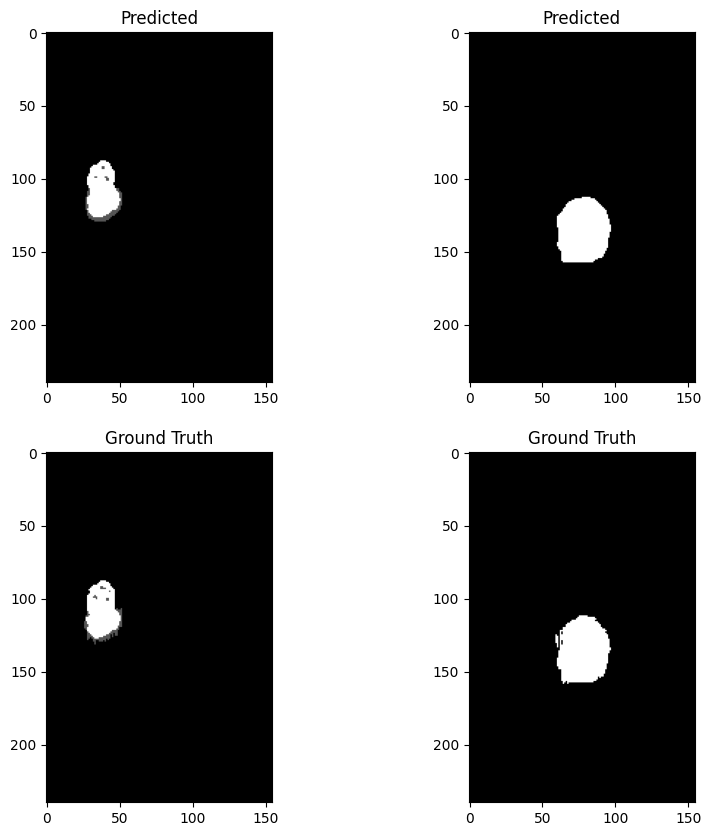

100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Average Validation Loss: 0.007938080166544145

Average Validation DSC: [0.9991194  0.9217926  0.92975202 0.78977309]
Average Validation ASSD: [ 0.08413445  7.78357024 11.79349085 21.46588201]
Epoch 52/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


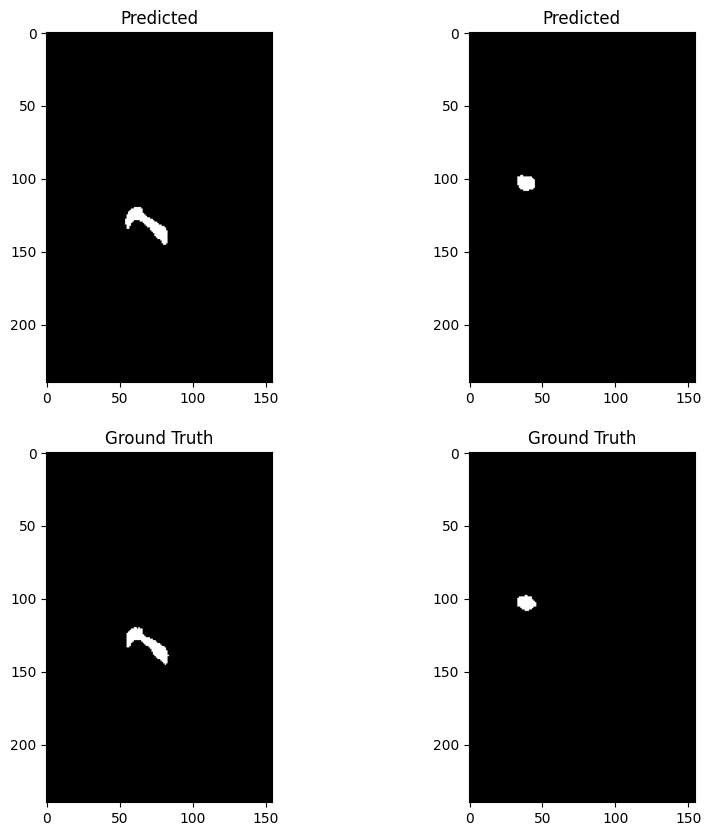

100%|██████████| 189/189 [11:42<00:00,  3.72s/it]



Average Training Loss: 0.006340159706909348

Average Training DSC: [0.99926345 0.93657804 0.94918474 0.8130442 ]
Average Training ASSD: [ 0.06911082  4.61671499  6.84481128 24.1222817 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


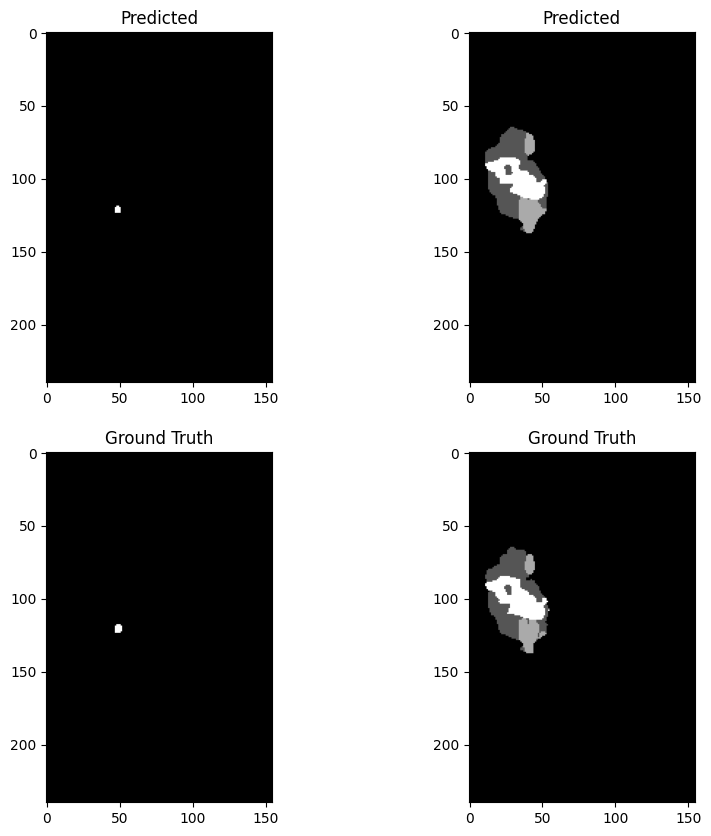

100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Average Validation Loss: 0.007852934427016104

Average Validation DSC: [0.99914297 0.92059916 0.93051615 0.79636397]
Average Validation ASSD: [ 0.08258827  7.65127449 12.81516236 22.00196415]
Epoch 53/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


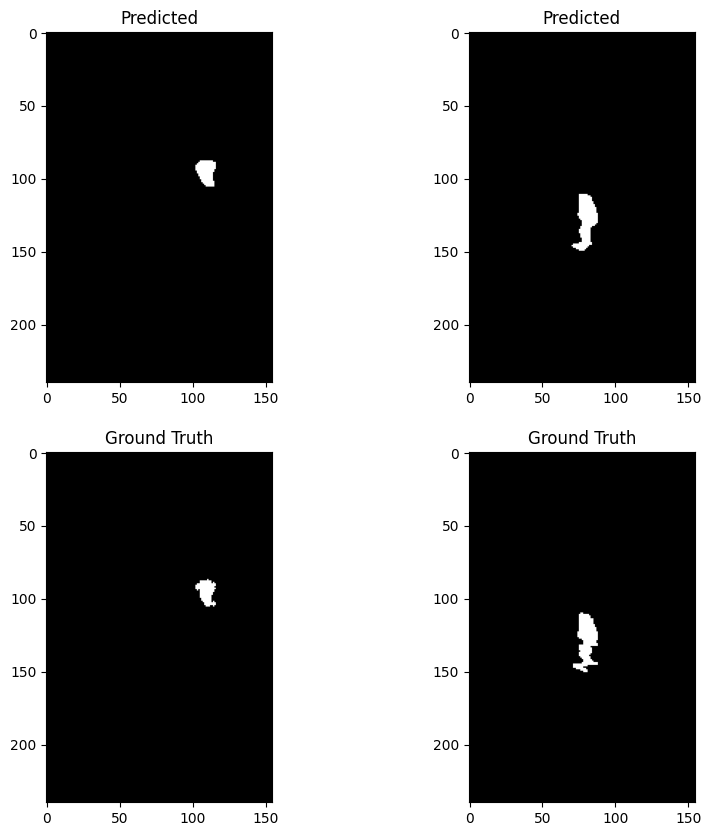

100%|██████████| 189/189 [11:52<00:00,  3.77s/it]



Average Training Loss: 0.006836085378256424

Average Training DSC: [0.99918781 0.92788292 0.94749551 0.80975278]
Average Training ASSD: [ 0.07739285  7.25749639  7.03603157 21.71595897]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


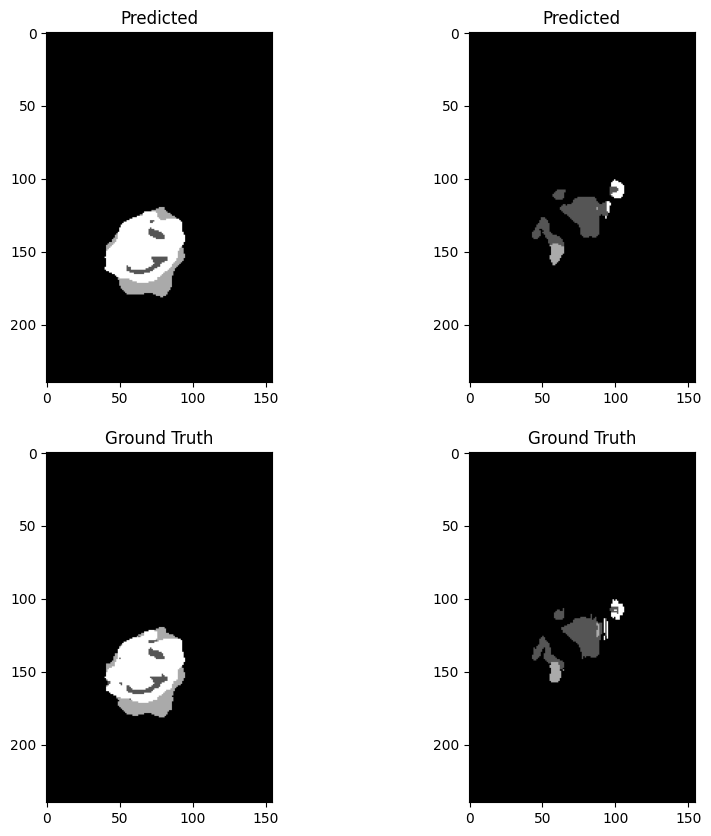

100%|██████████| 48/48 [02:51<00:00,  3.57s/it]


Average Validation Loss: 0.008164864964783192

Average Validation DSC: [0.99907639 0.91999523 0.93234822 0.79475121]
Average Validation ASSD: [ 0.09039899  7.89193273 11.52838894 23.07020571]
Epoch 54/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


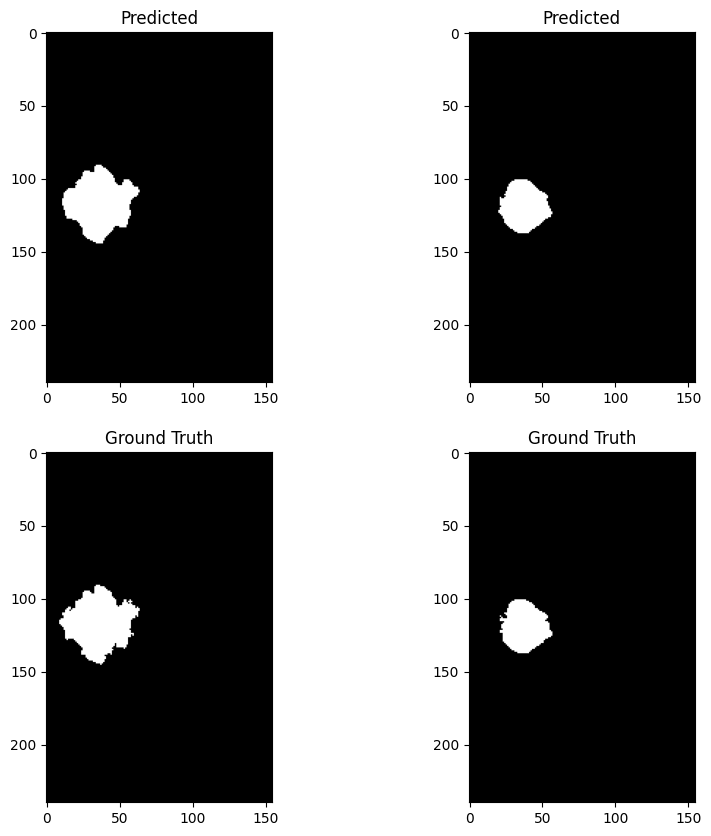

100%|██████████| 189/189 [12:08<00:00,  3.85s/it]



Average Training Loss: 0.006316899567123049

Average Training DSC: [0.99925729 0.93573204 0.94597963 0.81792513]
Average Training ASSD: [ 0.07054703  5.08914648  8.09787892 22.35724421]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


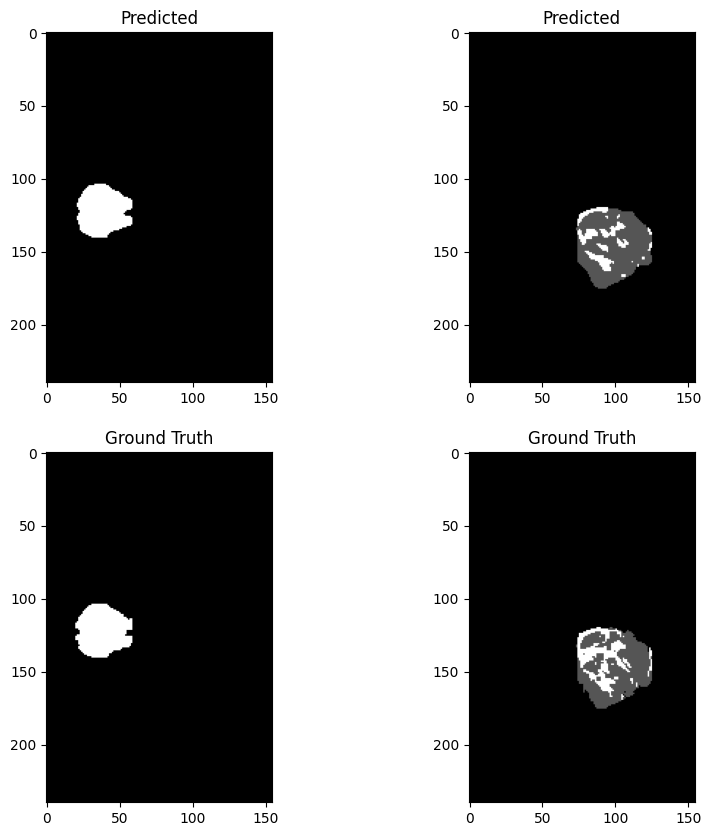

100%|██████████| 48/48 [02:50<00:00,  3.54s/it]


Average Validation Loss: 0.008110722827647502

Average Validation DSC: [0.99910591 0.92409559 0.92995887 0.79043837]
Average Validation ASSD: [ 0.08925718  6.60769989 11.76474752 25.39272568]
Epoch 55/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


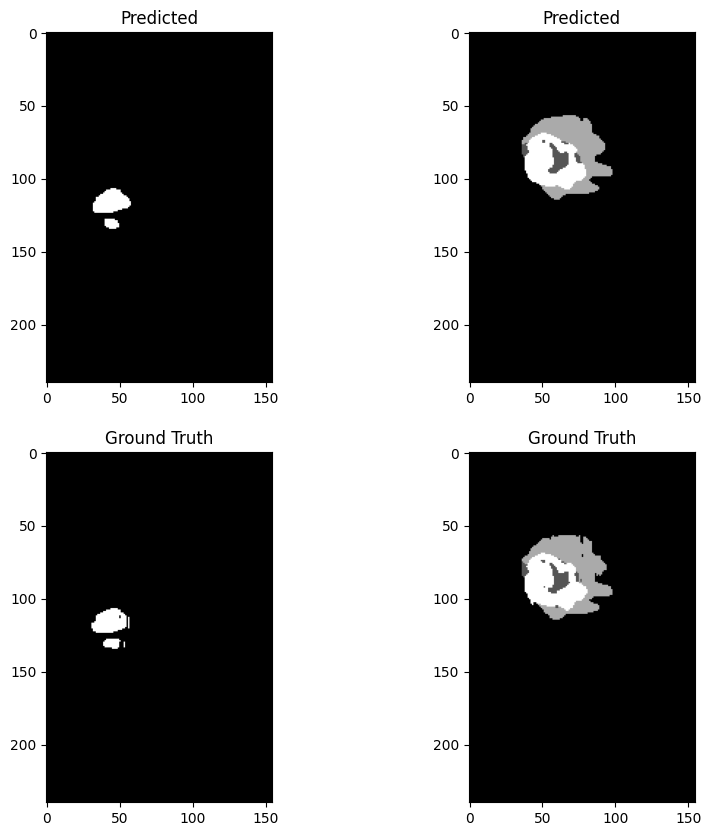

100%|██████████| 189/189 [11:59<00:00,  3.80s/it]



Average Training Loss: 0.0060142186044089534

Average Training DSC: [0.99929262 0.9396474  0.95099052 0.82436679]
Average Training ASSD: [ 0.06709846  4.29614334  6.71187446 21.79341889]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


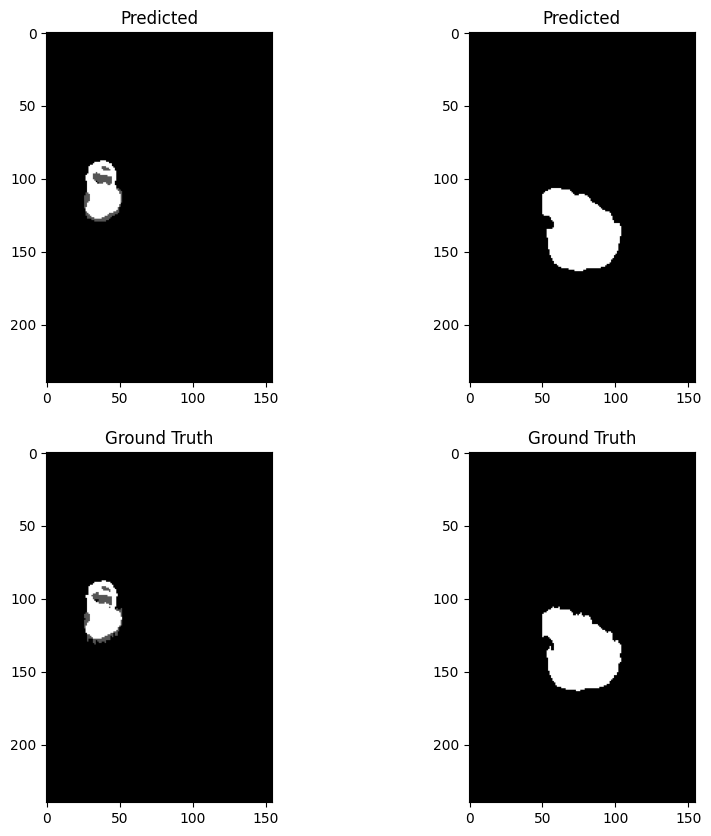

100%|██████████| 48/48 [02:48<00:00,  3.52s/it]


Average Validation Loss: 0.007924902233450363

Average Validation DSC: [0.99913065 0.92748119 0.93204185 0.79086552]
Average Validation ASSD: [ 0.0862719   6.46100106 11.35904548 26.06180527]
Epoch 56/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


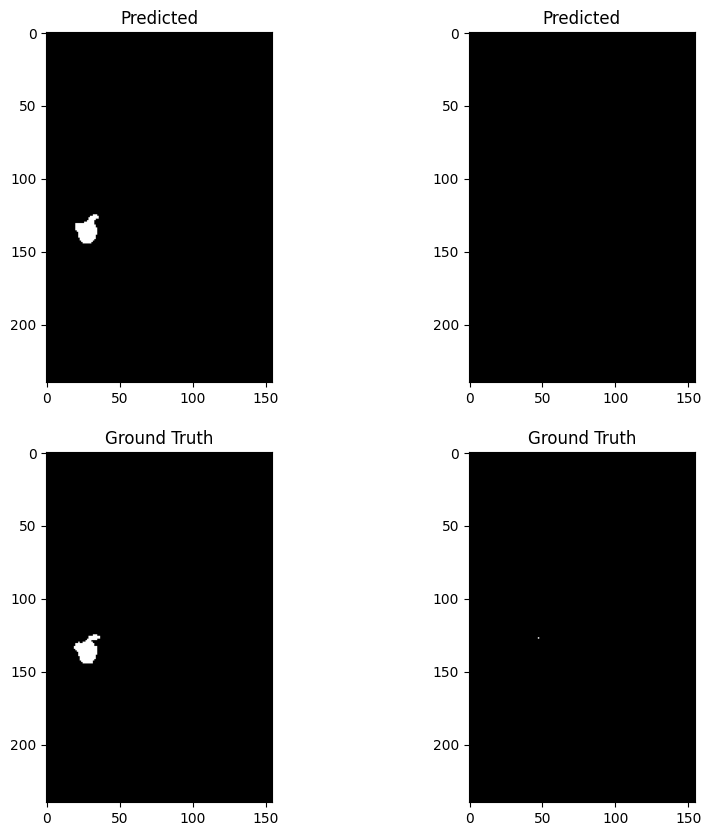

100%|██████████| 189/189 [11:52<00:00,  3.77s/it]



Average Training Loss: 0.006021086082217239

Average Training DSC: [0.99928203 0.94017185 0.9514123  0.82488491]
Average Training ASSD: [ 0.06744293  4.35472767  6.59572862 21.02909718]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


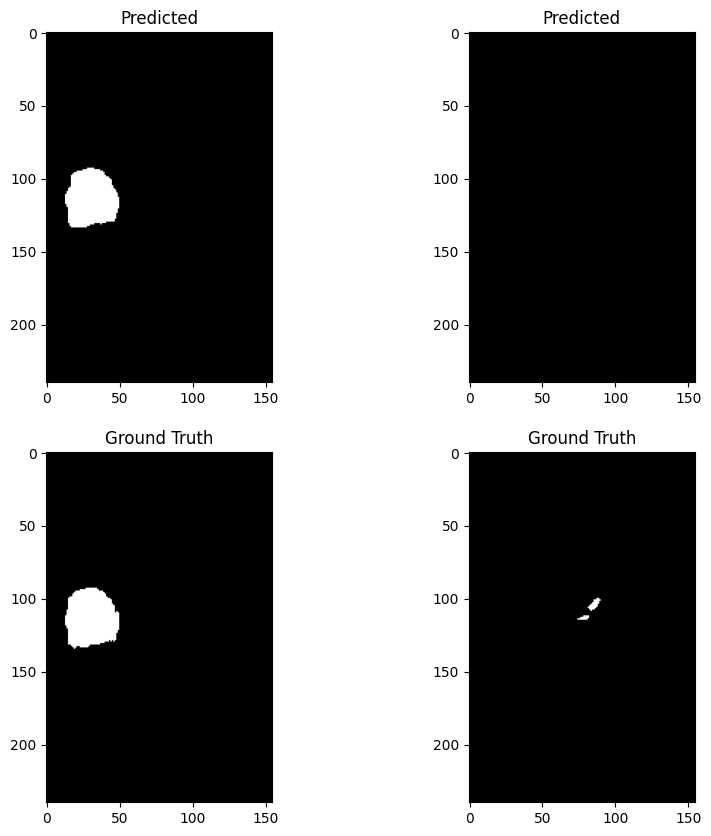

100%|██████████| 48/48 [02:48<00:00,  3.52s/it]


Average Validation Loss: 0.007690824442155038

Average Validation DSC: [0.99912529 0.92548801 0.93220388 0.80396177]
Average Validation ASSD: [ 0.08333269  6.68846069 11.02571876 20.40010068]
Epoch 57/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


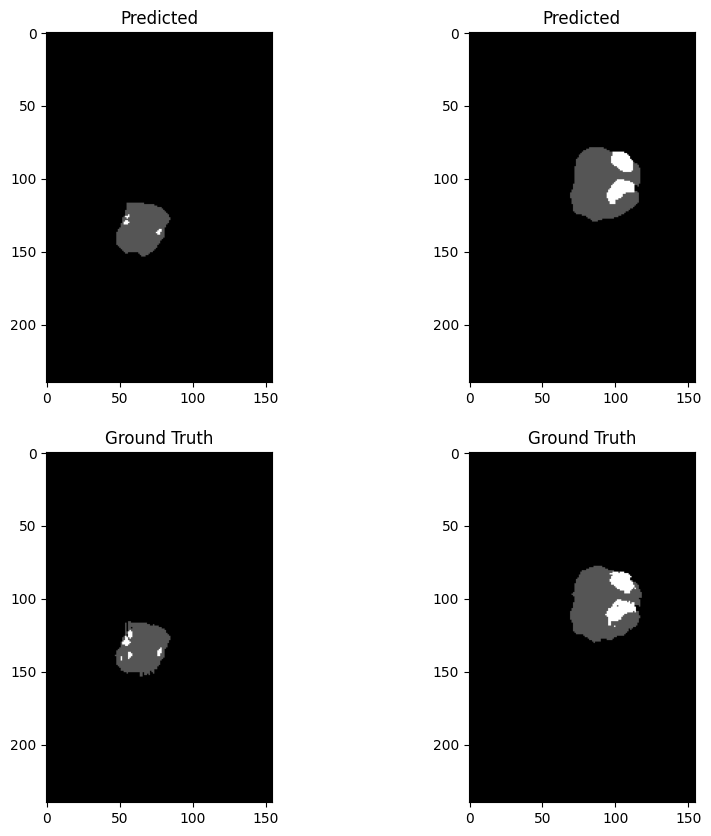

100%|██████████| 189/189 [12:01<00:00,  3.82s/it]



Average Training Loss: 0.006568592434709586

Average Training DSC: [0.99922606 0.92998234 0.94627552 0.81529047]
Average Training ASSD: [ 0.07574262  6.65382975  7.55432805 21.05054223]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


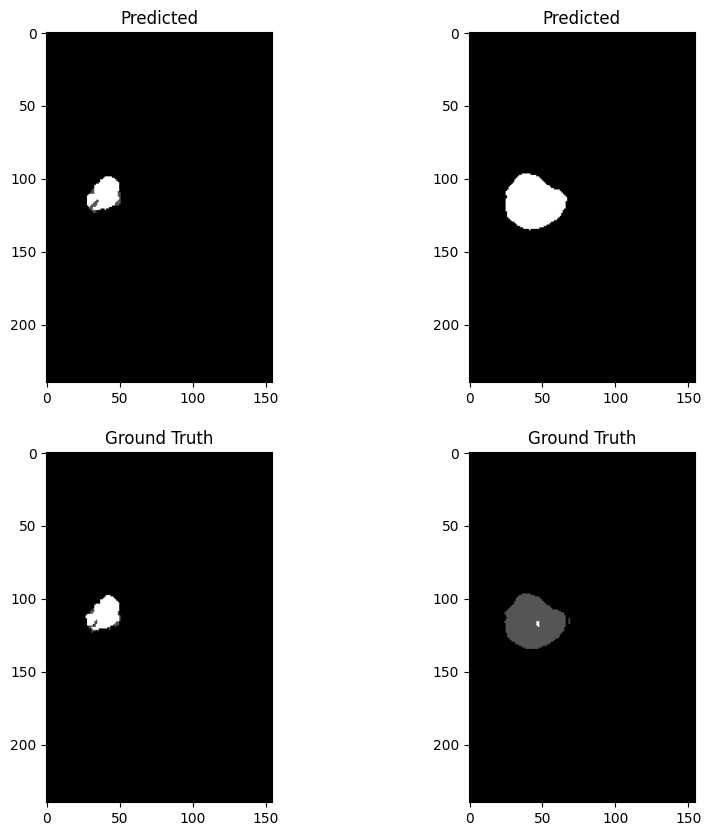

100%|██████████| 48/48 [02:49<00:00,  3.52s/it]


Average Validation Loss: 0.007796856196364388

Average Validation DSC: [0.99915107 0.92196766 0.93353544 0.80517617]
Average Validation ASSD: [ 0.08385653  8.58082062 10.12312108 19.49548504]
Epoch 58/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


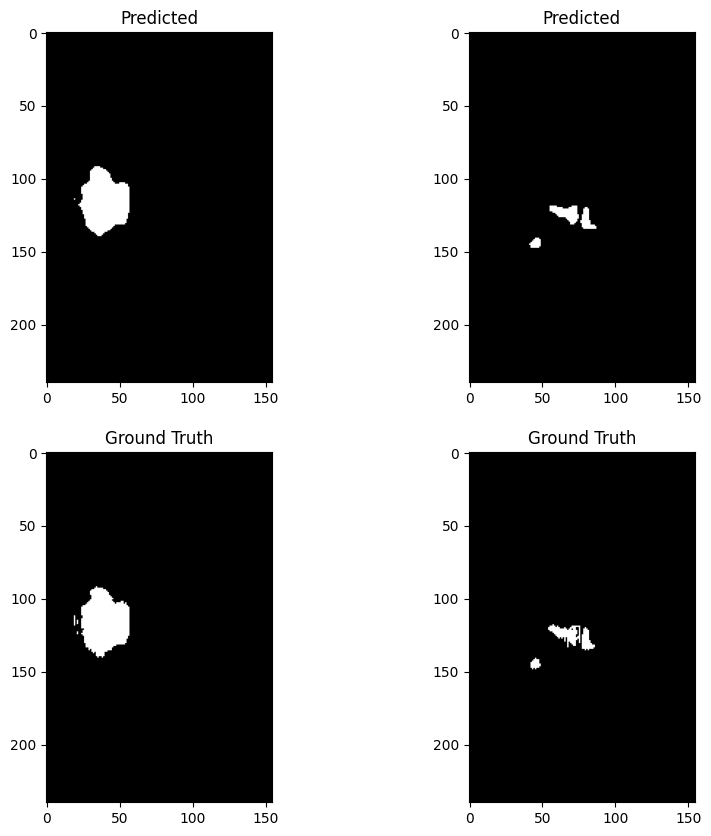

100%|██████████| 189/189 [12:05<00:00,  3.84s/it]



Average Training Loss: 0.00649095094447374

Average Training DSC: [0.99925194 0.93352547 0.93222875 0.82009282]
Average Training ASSD: [ 0.0701493   5.87484295 12.27034883 20.27968349]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


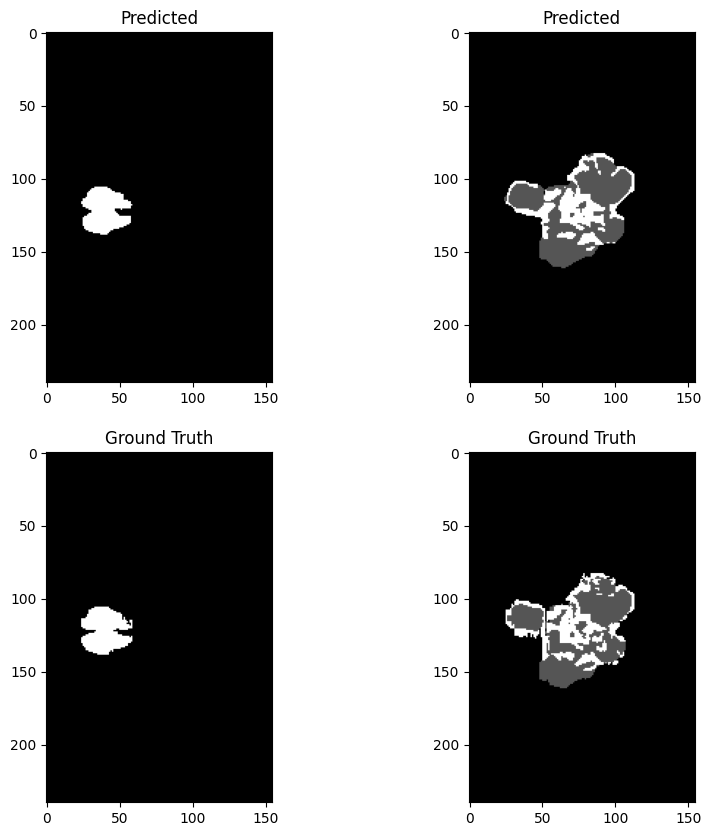

100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Average Validation Loss: 0.009188943416423475

Average Validation DSC: [0.999003   0.9114532  0.9185725  0.77944223]
Average Validation ASSD: [ 0.09728966  7.71100189 13.38955559 23.27171814]
Epoch 59/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


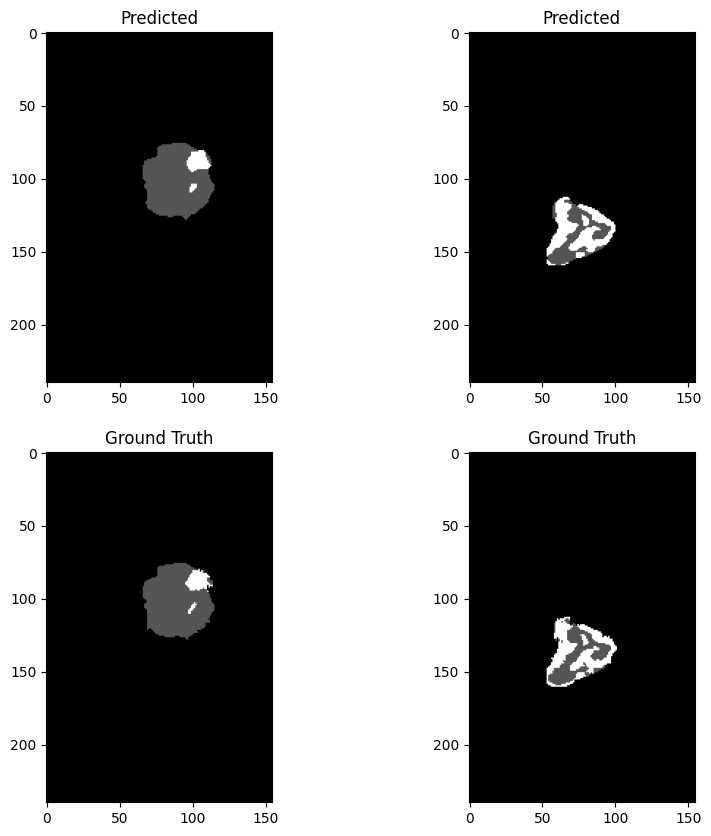

100%|██████████| 189/189 [12:06<00:00,  3.84s/it]



Average Training Loss: 0.006141124708361175

Average Training DSC: [0.99929145 0.93511816 0.95029037 0.82380909]
Average Training ASSD: [ 0.06620761  5.56799786  7.06058469 19.44030709]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


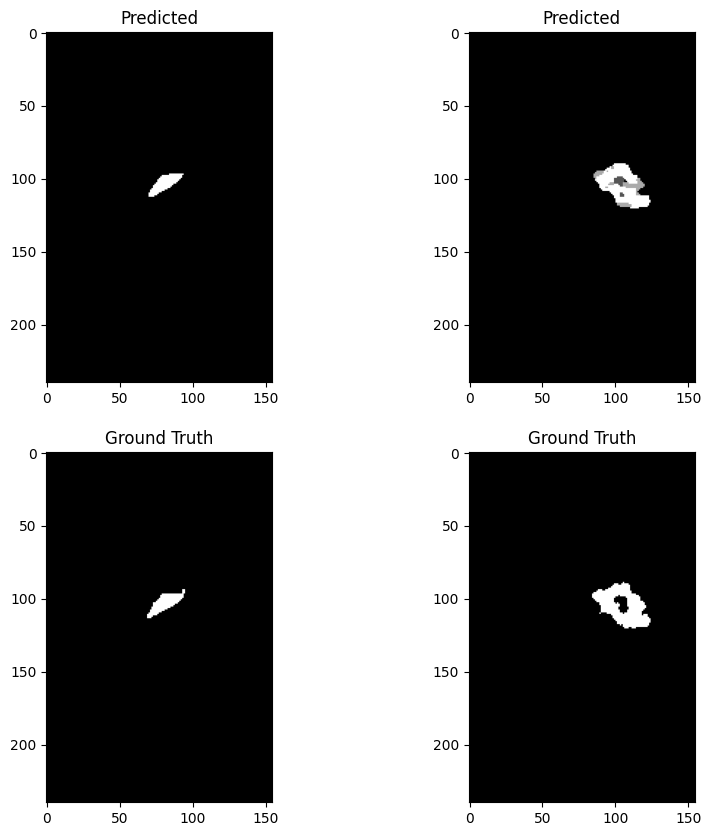

100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


Average Validation Loss: 0.007897376305966949

Average Validation DSC: [0.99912618 0.92168591 0.92899682 0.80364849]
Average Validation ASSD: [ 0.08652429  6.47798351 11.54264851 17.3390101 ]
Epoch 60/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


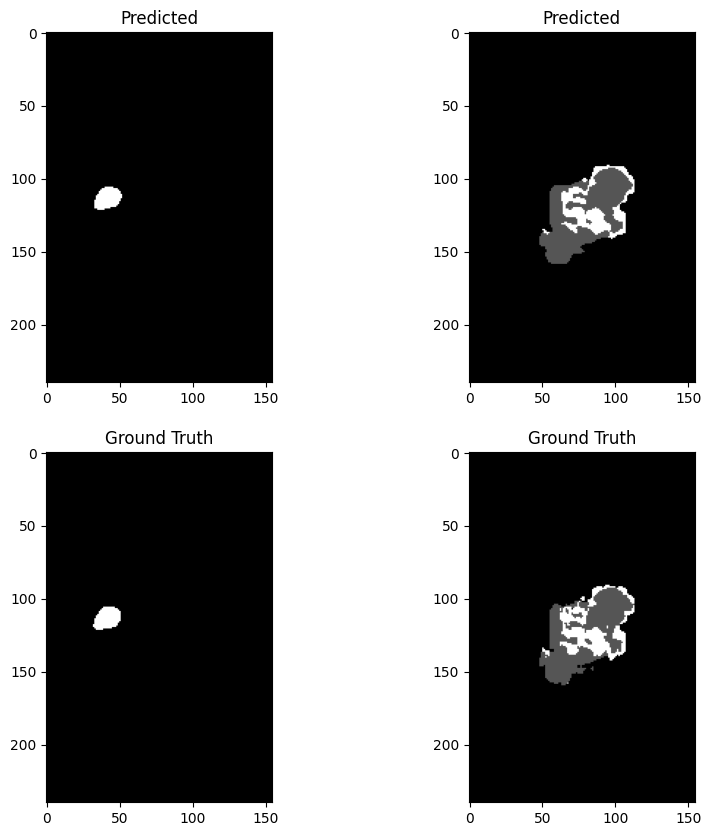

100%|██████████| 189/189 [12:01<00:00,  3.82s/it]



Average Training Loss: 0.0060776549098254355

Average Training DSC: [0.99930239 0.93481782 0.94532187 0.82629911]
Average Training ASSD: [ 0.06571621  6.1524565   8.5149746  19.10890162]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


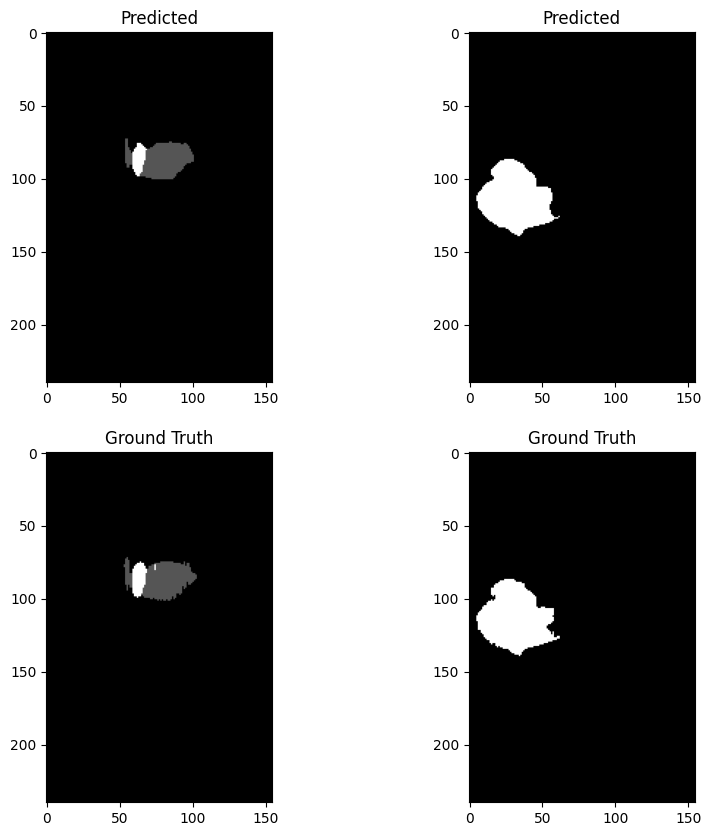

100%|██████████| 48/48 [02:48<00:00,  3.52s/it]


Average Validation Loss: 0.00870073448944216

Average Validation DSC: [0.99909561 0.91843039 0.92108737 0.79437461]
Average Validation ASSD: [ 0.09088934  8.8382509  14.65007084 21.55235975]
Epoch 61/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


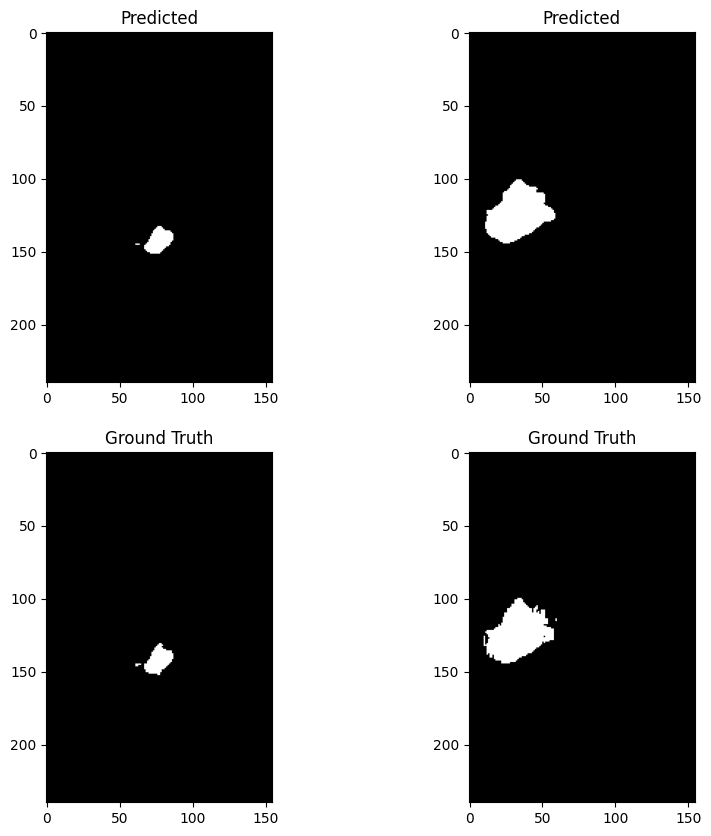

100%|██████████| 189/189 [11:55<00:00,  3.78s/it]



Average Training Loss: 0.0058835113393980515

Average Training DSC: [0.99931858 0.93901397 0.94894826 0.83151383]
Average Training ASSD: [ 0.06258345  5.36317291  7.35616733 19.567217  ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


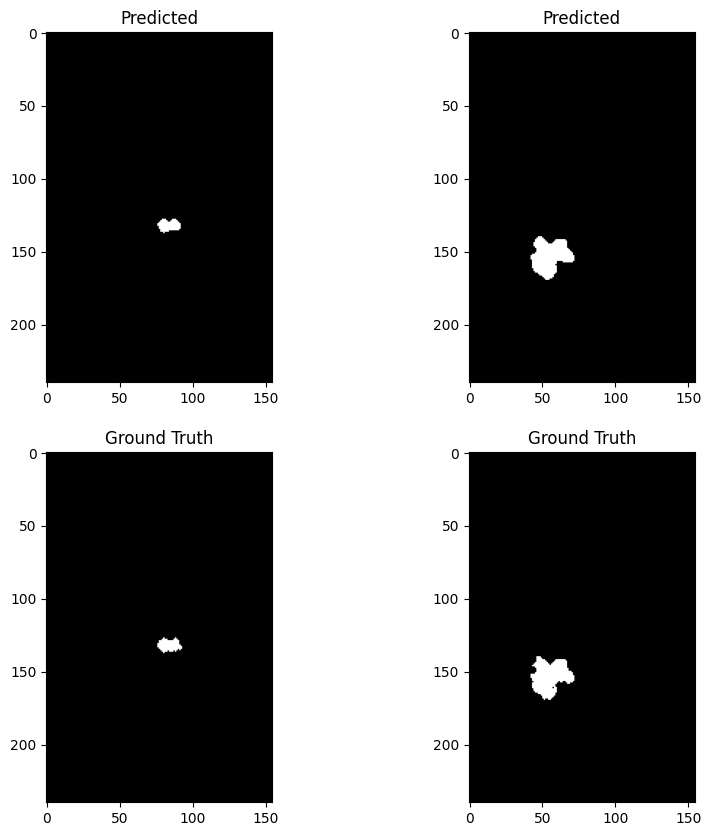

100%|██████████| 48/48 [02:51<00:00,  3.57s/it]


Average Validation Loss: 0.00804514119712015

Average Validation DSC: [0.99915462 0.92597975 0.93025561 0.80374698]
Average Validation ASSD: [ 0.08054675  7.41172442 10.85746581 20.65202405]
Epoch 62/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


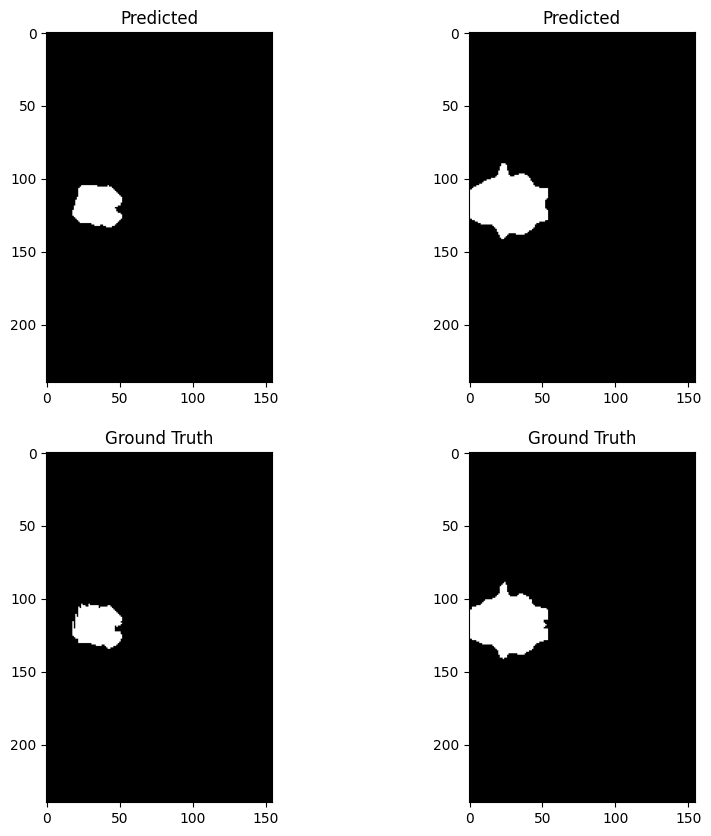

100%|██████████| 189/189 [12:01<00:00,  3.82s/it]



Average Training Loss: 0.0067202231302246375

Average Training DSC: [0.99923076 0.92287885 0.94550451 0.81762678]
Average Training ASSD: [ 0.07260196  9.28940555  8.21807055 18.26469944]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


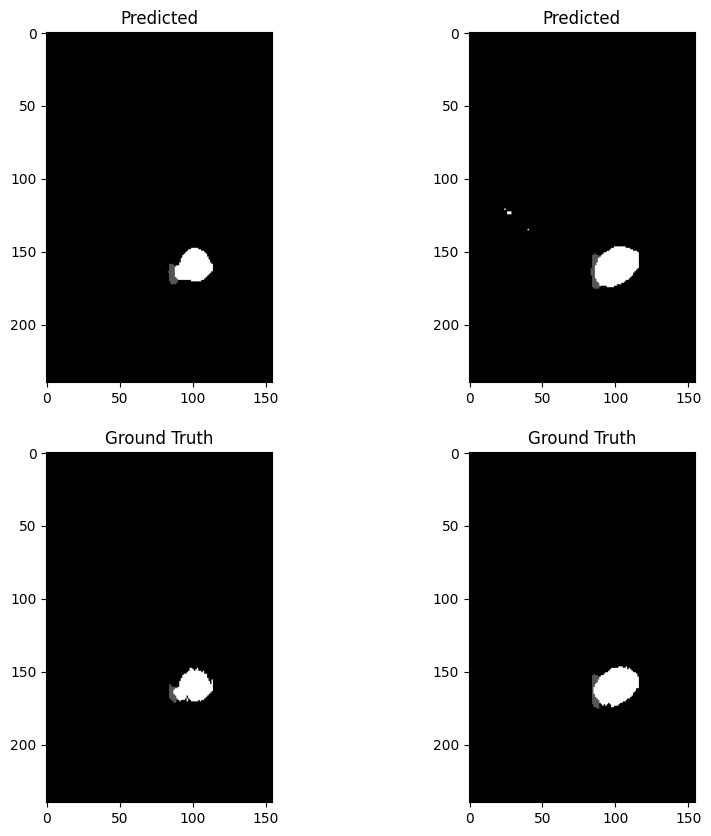

100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


Average Validation Loss: 0.008592015593118655

Average Validation DSC: [0.99905058 0.92266544 0.93331753 0.8064561 ]
Average Validation ASSD: [ 0.08630134  6.95419753 10.6924132  16.59474318]
Epoch 63/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


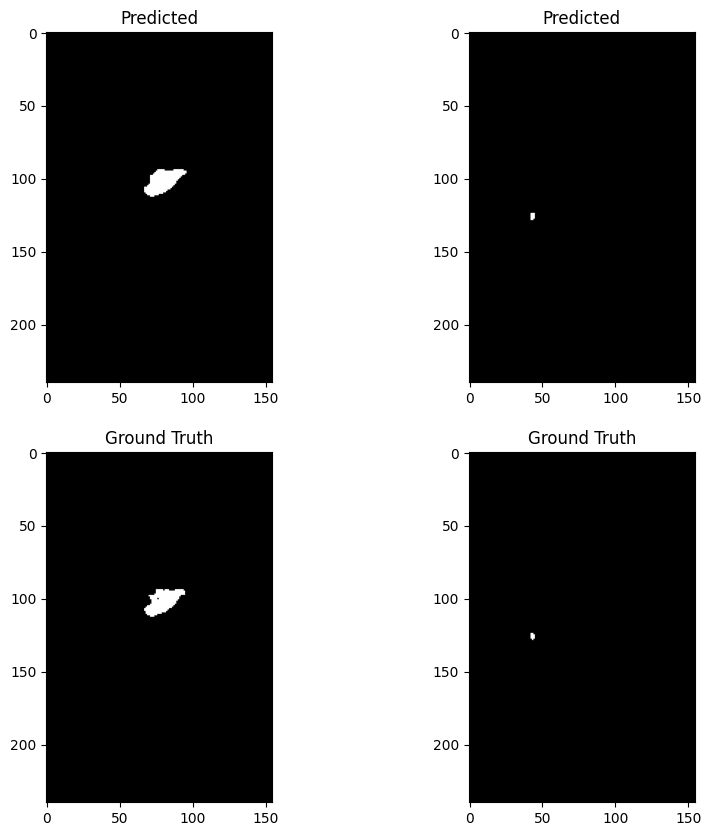

100%|██████████| 189/189 [11:54<00:00,  3.78s/it]



Average Training Loss: 0.006967846974336281

Average Training DSC: [0.99922497 0.91640528 0.94556865 0.81314144]
Average Training ASSD: [ 0.07314679 11.27751242  7.87834189 19.30191267]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


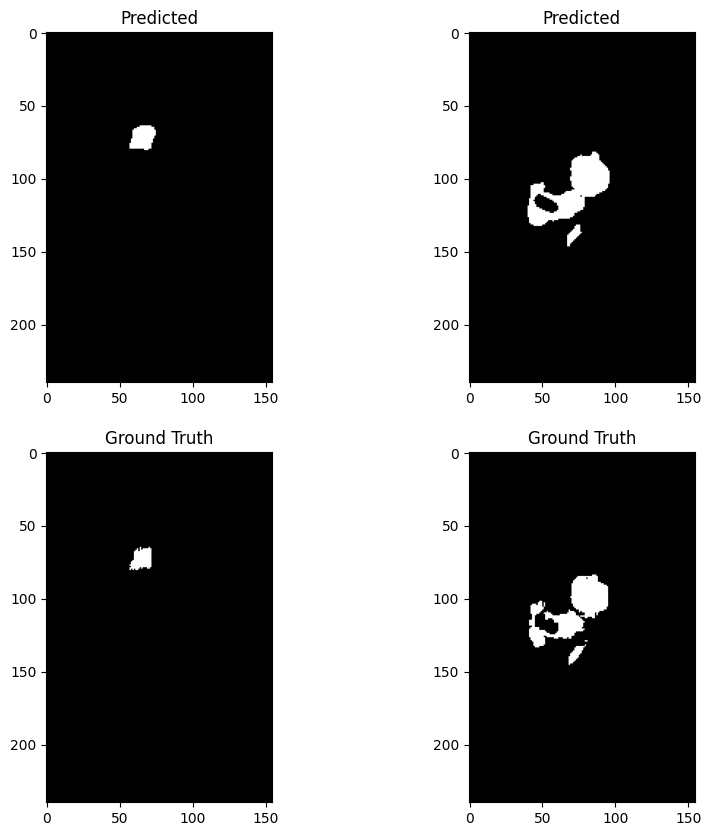

100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Average Validation Loss: 0.009144066648635393

Average Validation DSC: [0.99901395 0.90599308 0.9146541  0.78836015]
Average Validation ASSD: [ 0.0940446   9.14302542 13.39524823 13.13750747]
Epoch 64/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


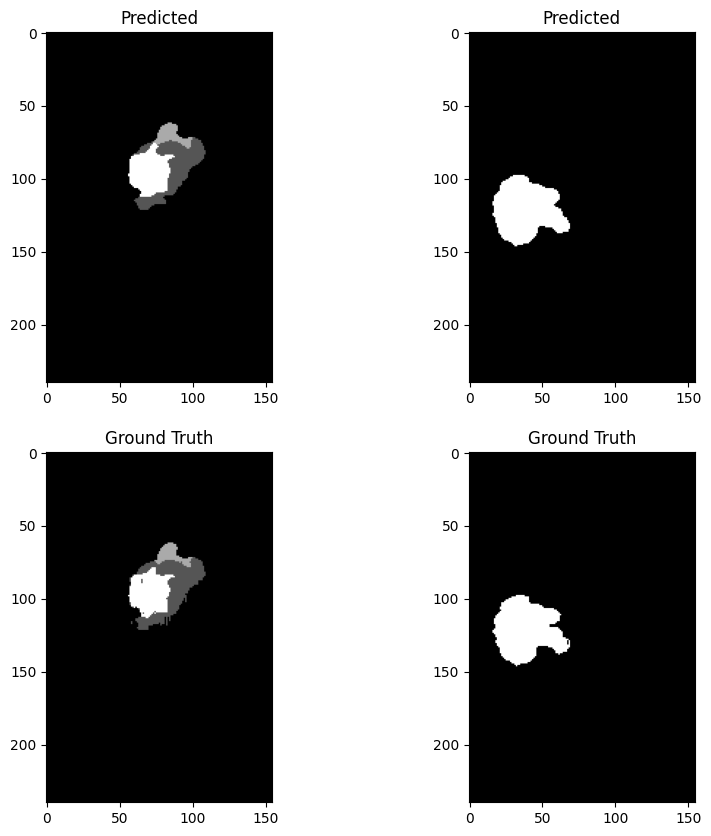

100%|██████████| 189/189 [11:40<00:00,  3.71s/it]



Average Training Loss: 0.0058496329507164695

Average Training DSC: [0.99933136 0.93628643 0.95260148 0.8285066 ]
Average Training ASSD: [ 0.06263877  5.79300896  6.5206327  19.46410222]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


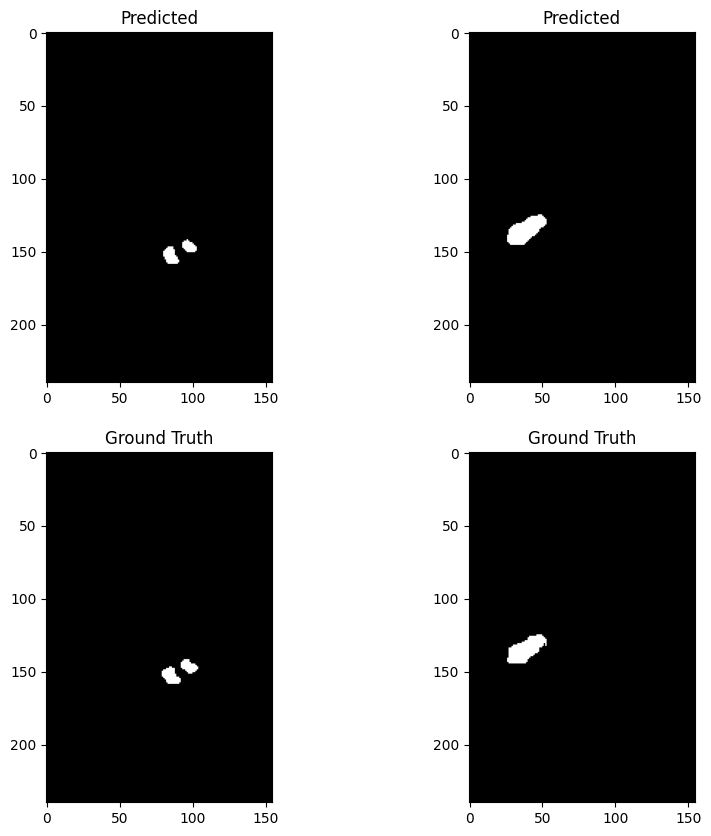

100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Average Validation Loss: 0.007866232617137333

Average Validation DSC: [0.9991536  0.92172905 0.93691728 0.81205691]
Average Validation ASSD: [ 0.08156888  7.87222646  9.91003482 17.56516653]
Epoch 65/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


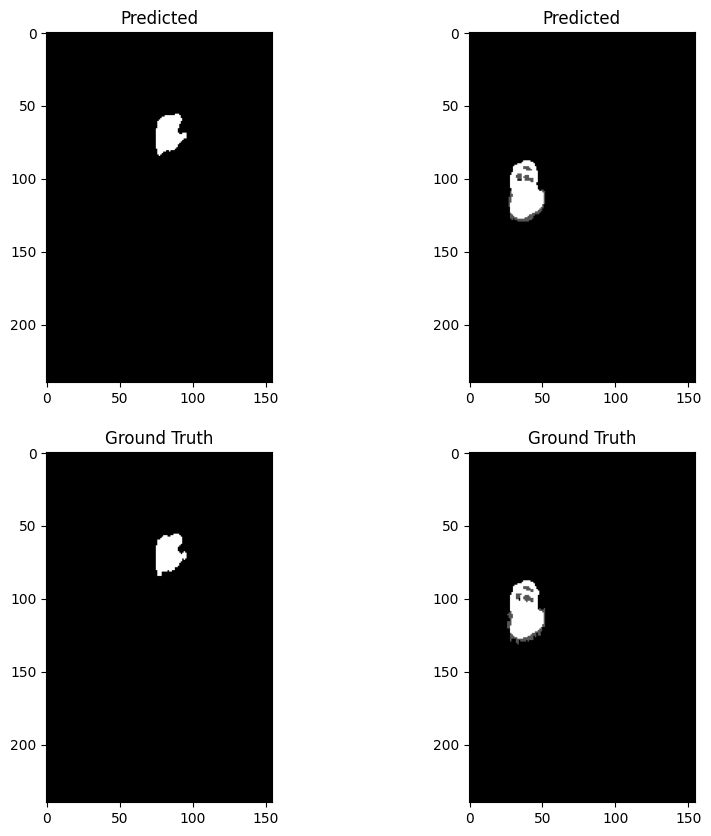

100%|██████████| 189/189 [12:04<00:00,  3.83s/it]



Average Training Loss: 0.005304427609271394

Average Training DSC: [0.99940831 0.9444505  0.95800467 0.84248699]
Average Training ASSD: [ 0.05460812  4.44459934  5.60493376 18.93006429]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


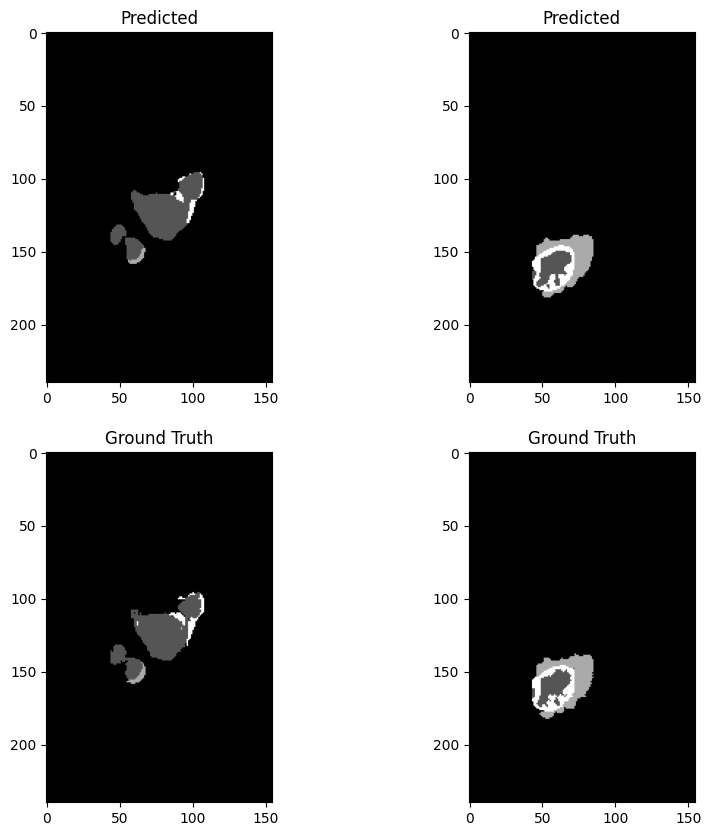

100%|██████████| 48/48 [02:52<00:00,  3.59s/it]


Average Validation Loss: 0.007820292754331604

Average Validation DSC: [0.99923047 0.92500138 0.93796864 0.80760222]
Average Validation ASSD: [ 0.07283307  7.29095084  9.04196906 19.56500971]
Epoch 66/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


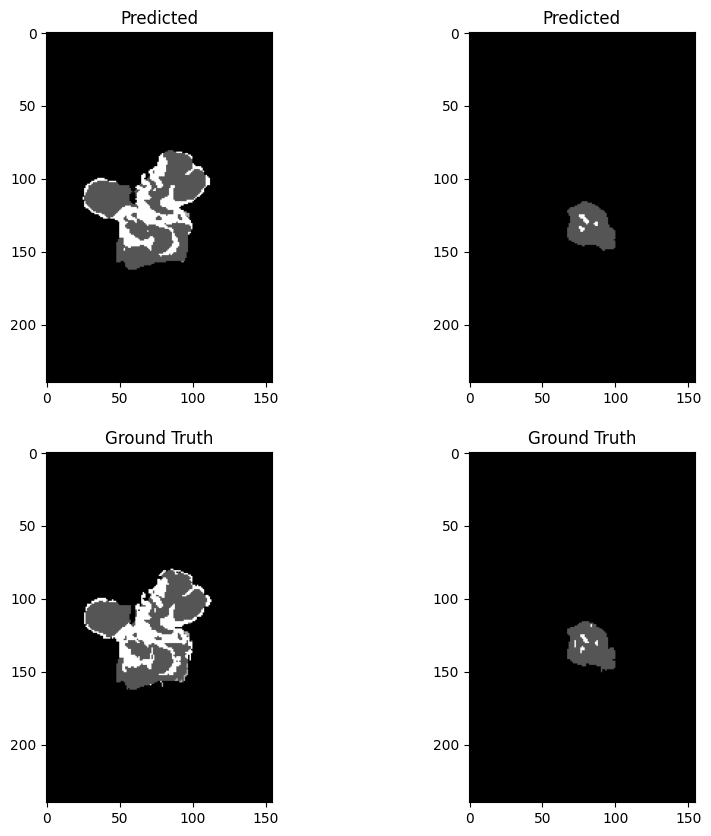

100%|██████████| 189/189 [11:55<00:00,  3.79s/it]



Average Training Loss: 0.005332206398071278

Average Training DSC: [0.99940691 0.94013415 0.9580642  0.84337022]
Average Training ASSD: [ 0.05486704  5.94491286  5.47723052 17.37343536]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


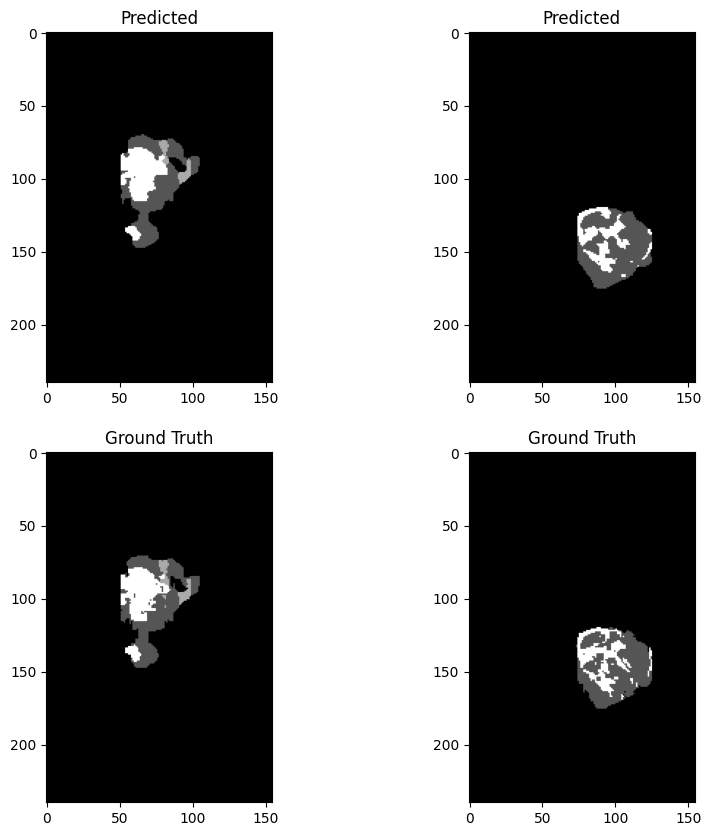

100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


Average Validation Loss: 0.006969511974602938

Average Validation DSC: [0.99927973 0.9356313  0.94267575 0.82648077]
Average Validation ASSD: [ 0.06763411  5.00167544  9.58867265 17.58392747]
Epoch 67/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


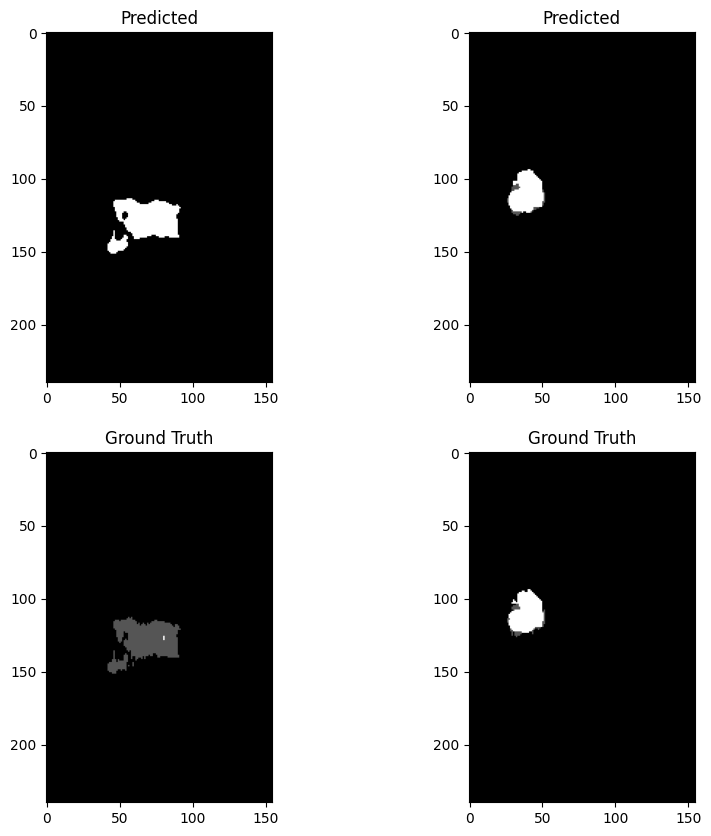

100%|██████████| 189/189 [11:56<00:00,  3.79s/it]



Average Training Loss: 0.004817144272642003

Average Training DSC: [0.99945003 0.95023848 0.96100833 0.85452822]
Average Training ASSD: [ 0.05033088  3.28811591  4.98453809 16.95165078]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


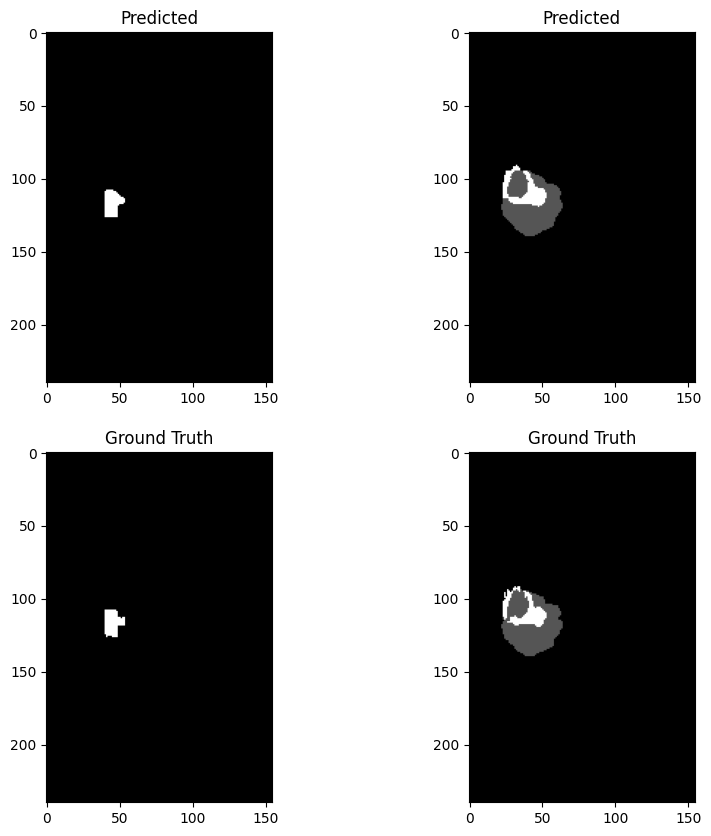

100%|██████████| 48/48 [02:51<00:00,  3.58s/it]


Average Validation Loss: 0.006799189073111241

Average Validation DSC: [0.99929543 0.93677902 0.94174383 0.82295109]
Average Validation ASSD: [ 0.06903926  5.70426463  8.46099364 21.70249019]
Epoch 68/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


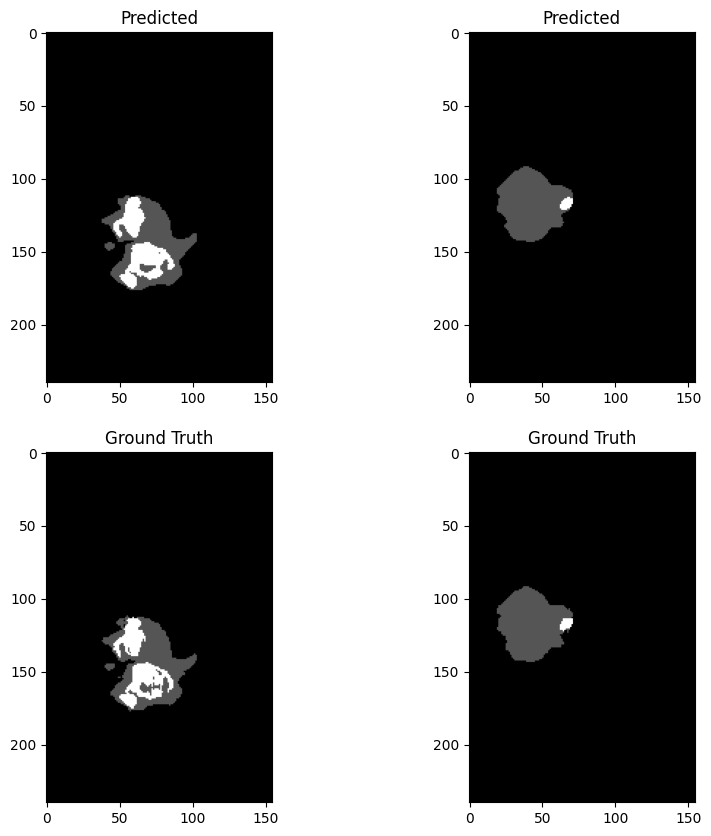

100%|██████████| 189/189 [12:02<00:00,  3.82s/it]



Average Training Loss: 0.004496869979741633

Average Training DSC: [0.99948802 0.95339135 0.96314959 0.85948797]
Average Training ASSD: [ 0.04539889  3.09196388  4.62459919 17.17528608]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


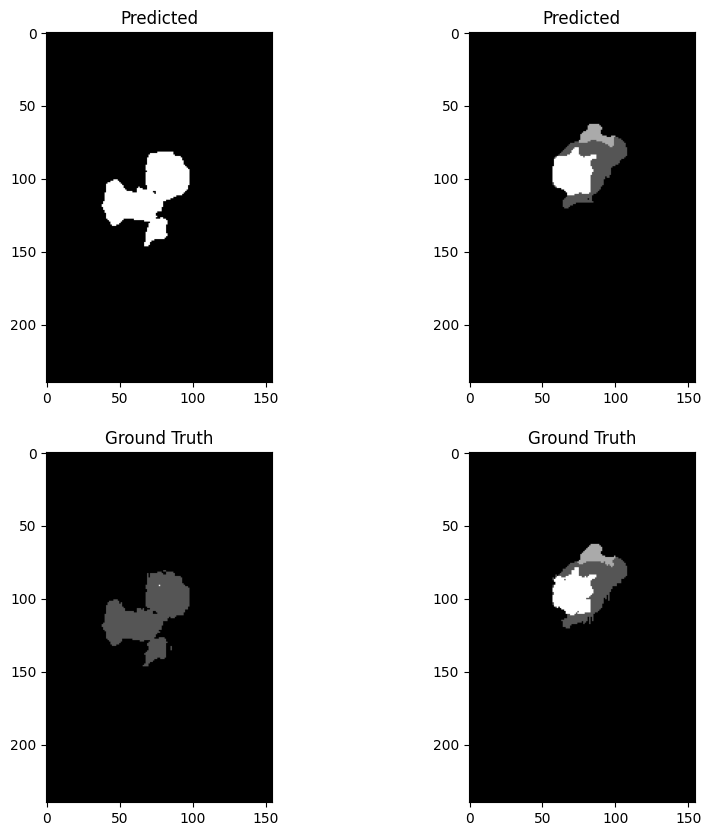

100%|██████████| 48/48 [02:41<00:00,  3.37s/it]


Average Validation Loss: 0.0068545949761755764

Average Validation DSC: [0.99932879 0.93766926 0.94326123 0.83727942]
Average Validation ASSD: [ 0.06426731  4.28869742  9.81872894 15.6675414 ]
Epoch 69/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


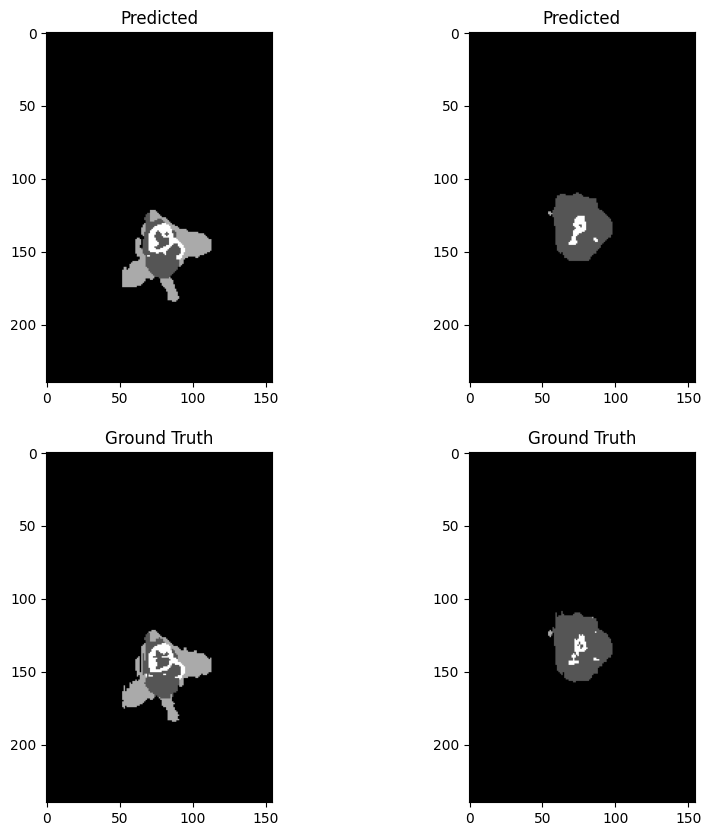

100%|██████████| 189/189 [11:54<00:00,  3.78s/it]



Average Training Loss: 0.004472138443912463

Average Training DSC: [0.99949342 0.95375466 0.96269404 0.86240614]
Average Training ASSD: [ 0.04452048  2.78986558  4.97448802 16.42389332]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


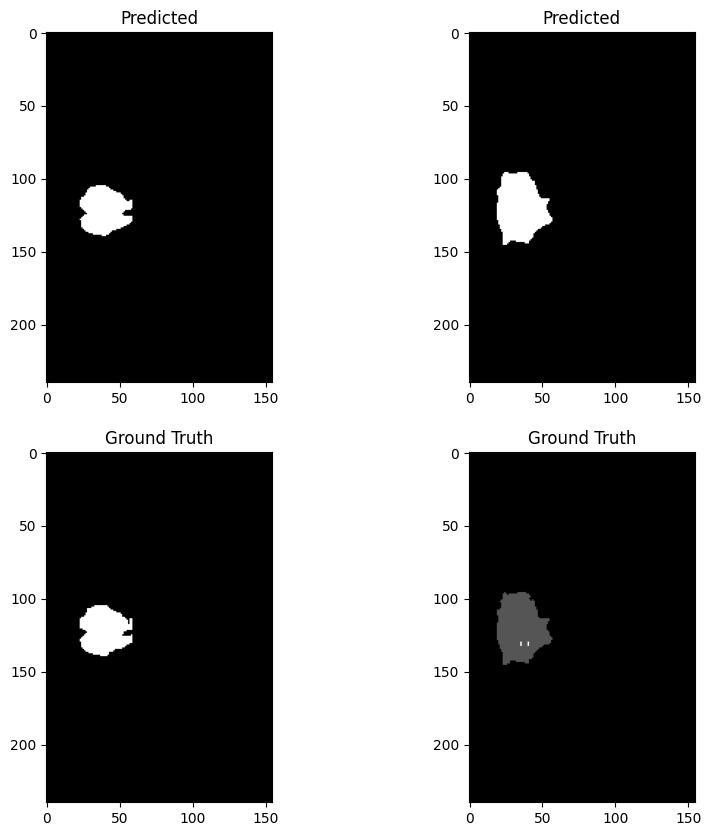

100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Average Validation Loss: 0.0068348592952437075

Average Validation DSC: [0.99932037 0.93925649 0.94293628 0.82973328]
Average Validation ASSD: [ 0.06435333  4.27016808  9.15501803 17.40499983]
Epoch 70/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


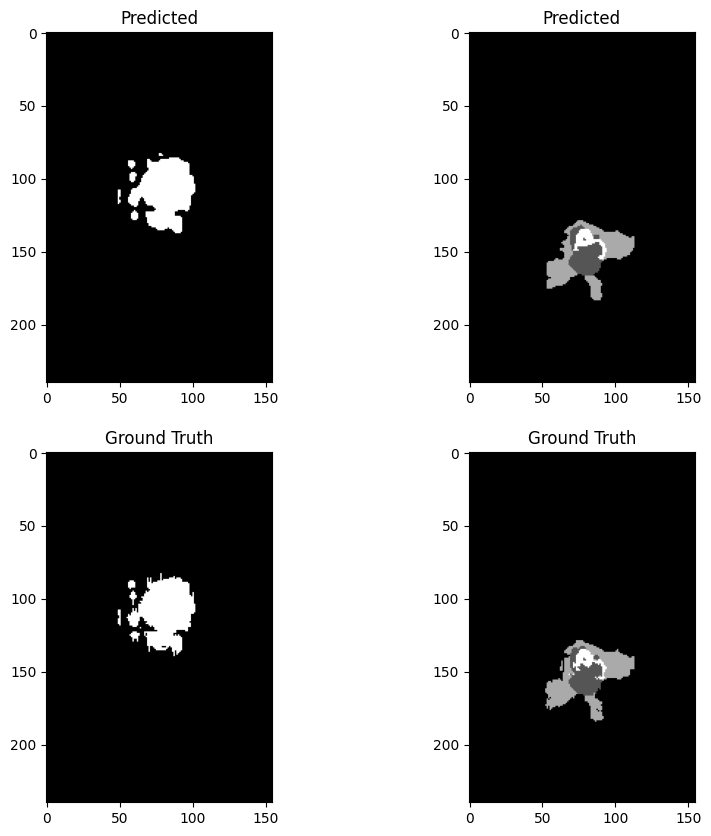

100%|██████████| 189/189 [11:49<00:00,  3.76s/it]



Average Training Loss: 0.005002148981605258

Average Training DSC: [0.99943912 0.94311154 0.95966679 0.85186127]
Average Training ASSD: [ 0.05071456  5.39166953  5.35491732 16.71851316]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


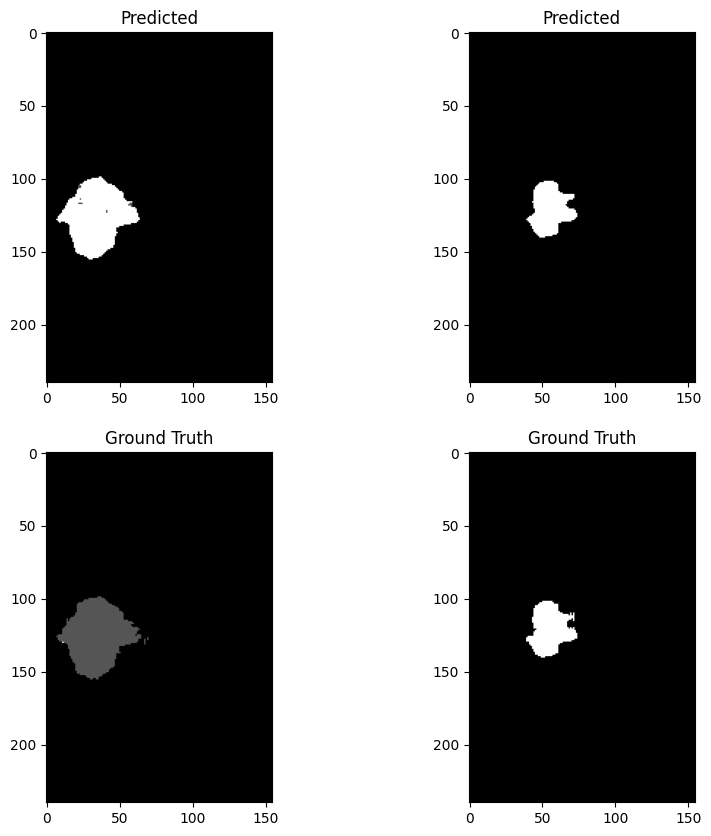

100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Average Validation Loss: 0.006988797618153815

Average Validation DSC: [0.99930619 0.93381222 0.94229554 0.82936803]
Average Validation ASSD: [ 0.06802795  6.17883785  8.67825365 16.57129192]
Epoch 71/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


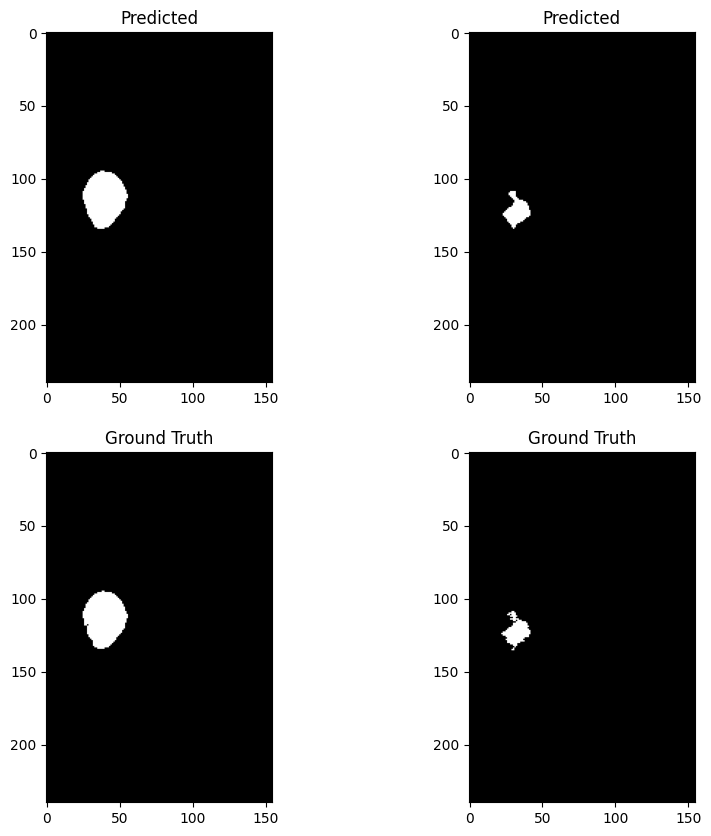

100%|██████████| 189/189 [11:56<00:00,  3.79s/it]



Average Training Loss: 0.00447588541086704

Average Training DSC: [0.99949008 0.95400465 0.96243243 0.86093244]
Average Training ASSD: [ 0.0452082   2.67009044  4.86390102 16.55778701]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


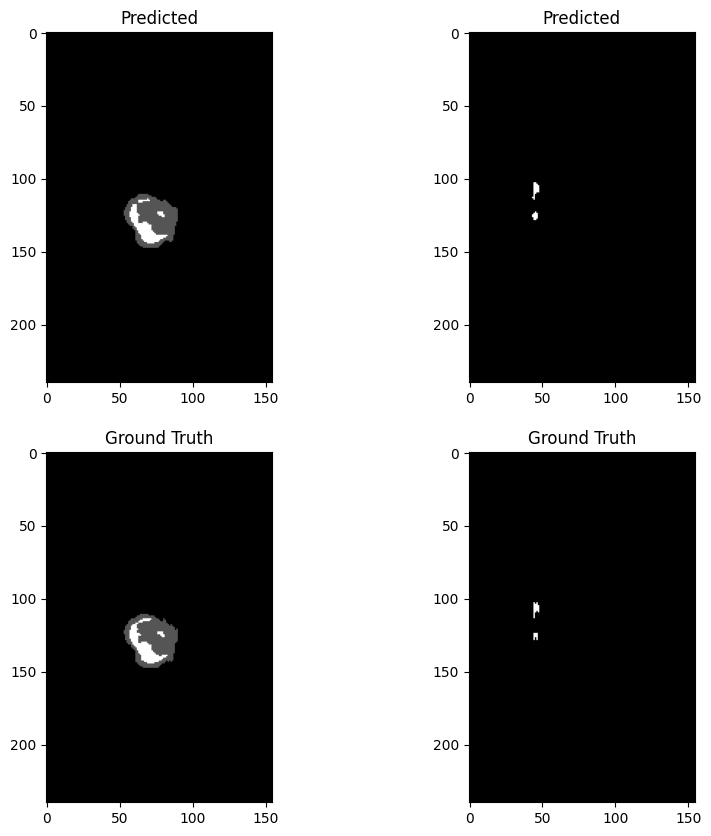

100%|██████████| 48/48 [02:51<00:00,  3.57s/it]


Average Validation Loss: 0.007248895310719187

Average Validation DSC: [0.99929934 0.93967901 0.9415955  0.82732409]
Average Validation ASSD: [ 0.07084228  4.74918892  9.84427698 20.40854967]
Epoch 72/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


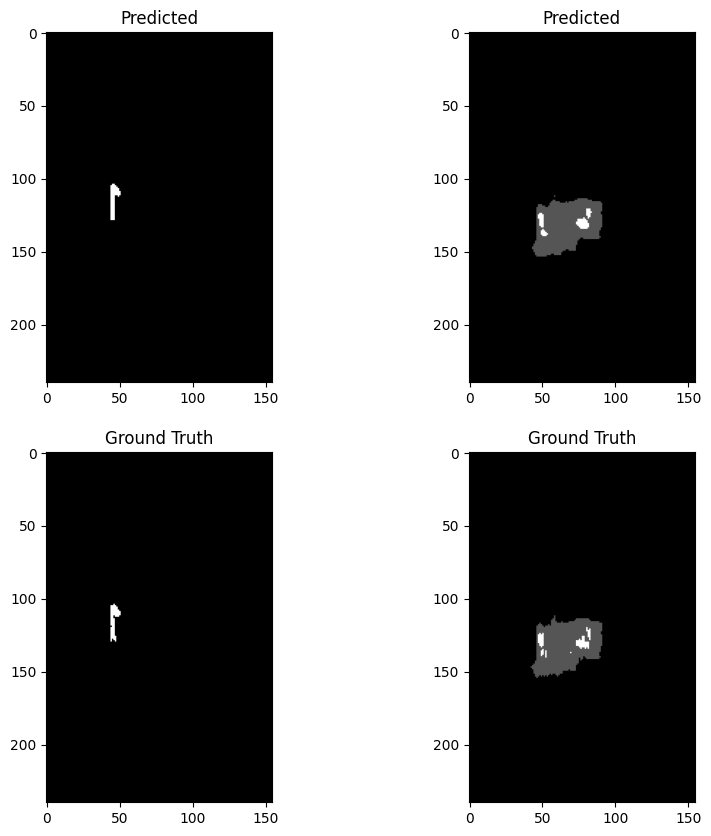

100%|██████████| 189/189 [12:00<00:00,  3.81s/it]



Average Training Loss: 0.004605328377149014

Average Training DSC: [0.99948377 0.95148955 0.96235078 0.8614161 ]
Average Training ASSD: [ 0.04592671  3.5725622   5.02603756 16.07386293]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


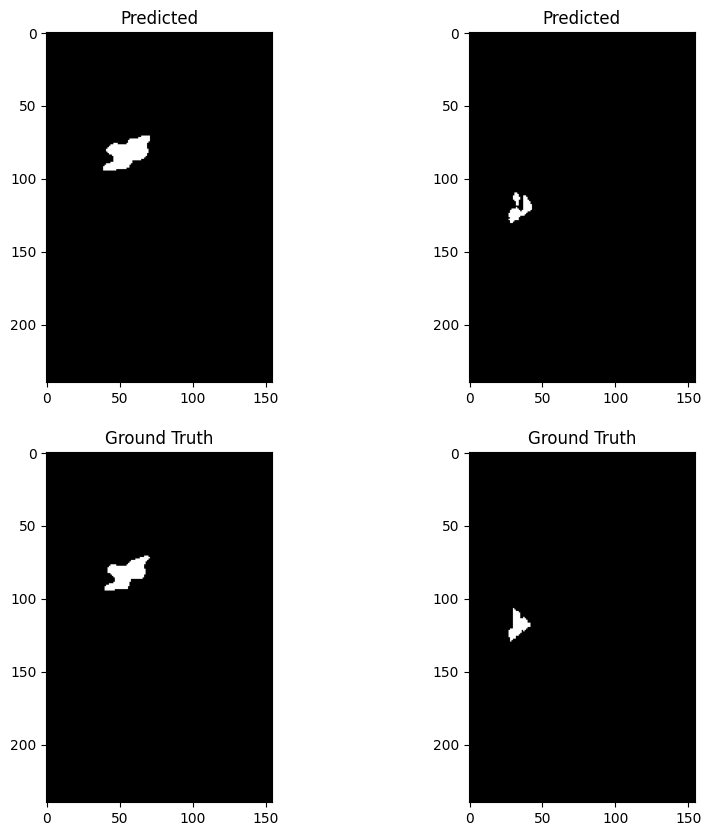

100%|██████████| 48/48 [02:53<00:00,  3.62s/it]


Average Validation Loss: 0.007617455654932807

Average Validation DSC: [0.99926309 0.91036753 0.9395839  0.82513551]
Average Validation ASSD: [ 0.07305129 13.28462126  8.92642381 16.60207089]
Epoch 73/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


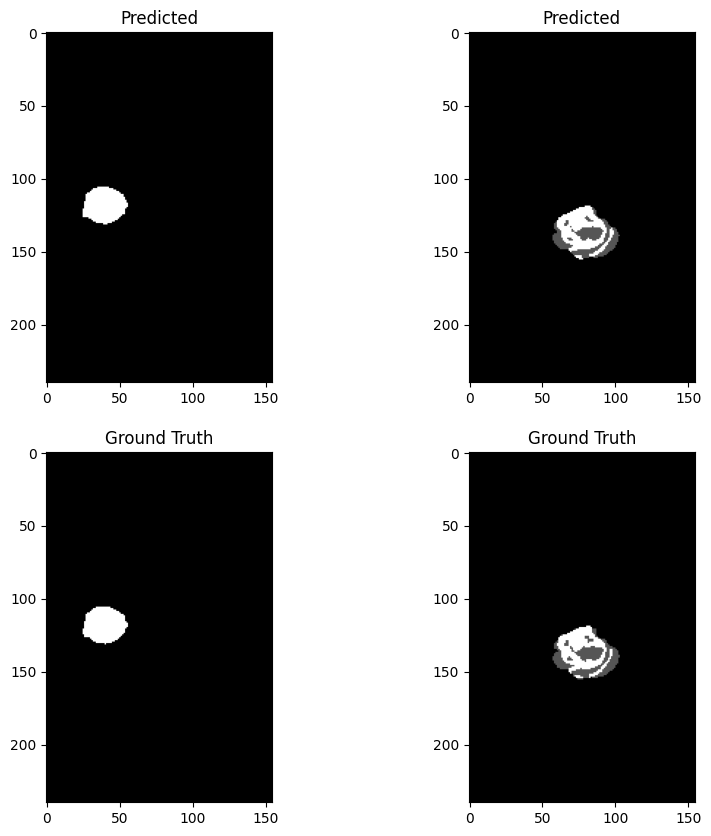

100%|██████████| 189/189 [11:56<00:00,  3.79s/it]



Average Training Loss: 0.005083557612523831

Average Training DSC: [0.99943903 0.94223555 0.95877556 0.85560516]
Average Training ASSD: [ 0.04993307  5.74533515  5.71391529 15.1898168 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


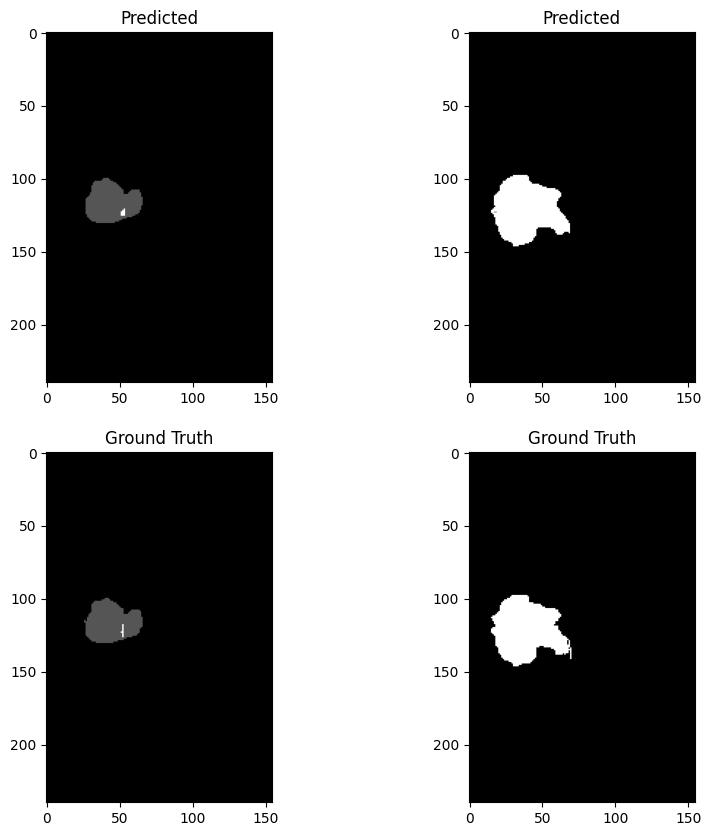

100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Average Validation Loss: 0.007941402436699718

Average Validation DSC: [0.999196   0.91752765 0.91269878 0.82198982]
Average Validation ASSD: [ 0.07771     9.27961751 18.11784306 13.59601188]
Epoch 74/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


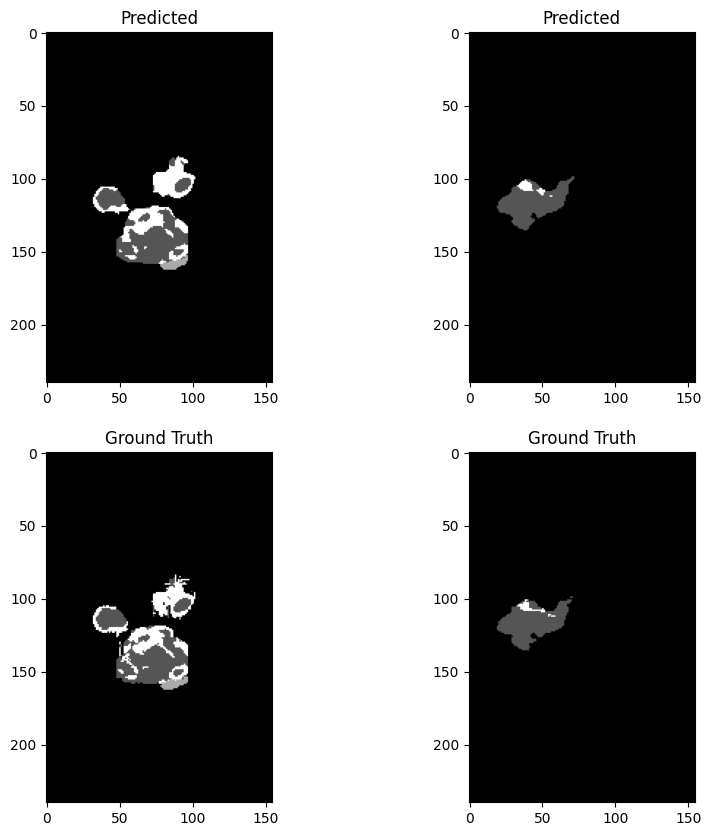

100%|██████████| 189/189 [12:04<00:00,  3.83s/it]



Average Training Loss: 0.005228258506764495

Average Training DSC: [0.99942443 0.94201413 0.95642928 0.84989499]
Average Training ASSD: [ 0.0518576   5.2180596   6.55071853 15.72035068]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


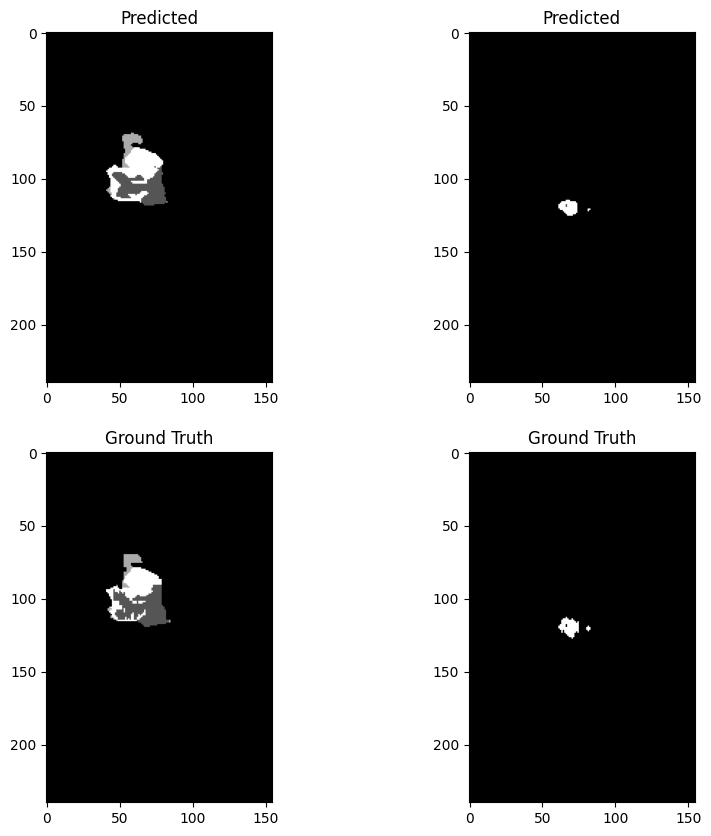

100%|██████████| 48/48 [02:44<00:00,  3.44s/it]


Average Validation Loss: 0.008577485879262289

Average Validation DSC: [0.99909957 0.90471549 0.91258215 0.80667294]
Average Validation ASSD: [ 0.0859872  12.15240128 14.59593718 13.79274929]
Epoch 75/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


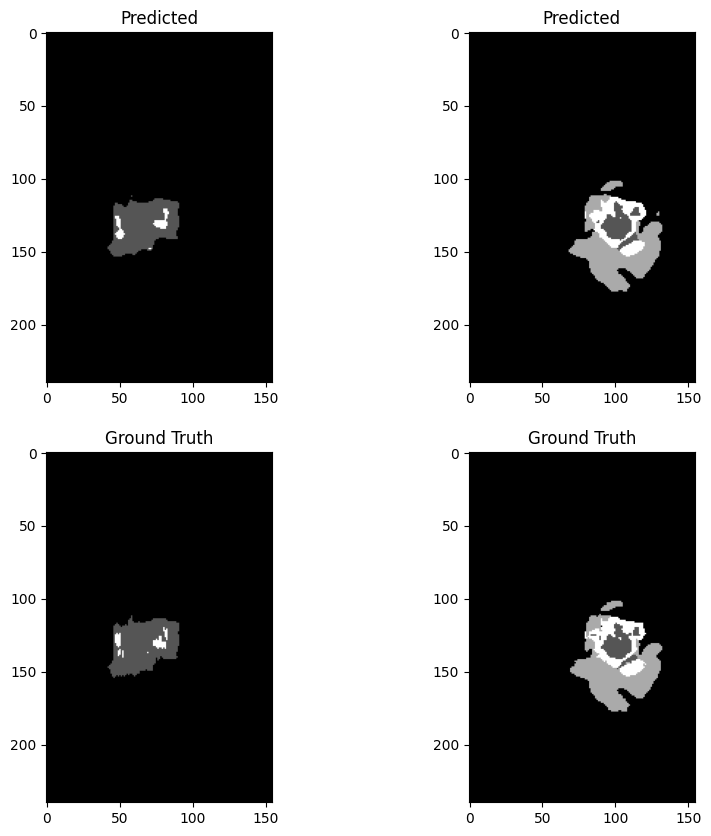

100%|██████████| 189/189 [11:37<00:00,  3.69s/it]



Average Training Loss: 0.007493059213701931

Average Training DSC: [0.99914509 0.91472108 0.93701486 0.81094215]
Average Training ASSD: [ 0.08279921 11.63652205 10.81264488 16.57449767]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


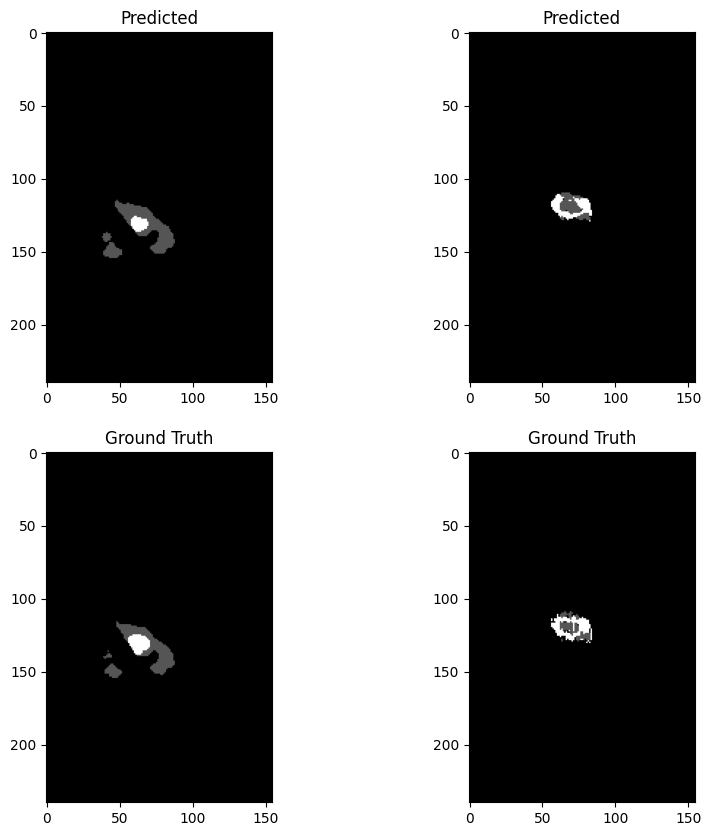

100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


Average Validation Loss: 0.008462406626980131

Average Validation DSC: [0.99908936 0.90505052 0.91737057 0.78126102]
Average Validation ASSD: [ 0.09103256 13.54862032 15.60607458 22.17834404]
Epoch 76/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


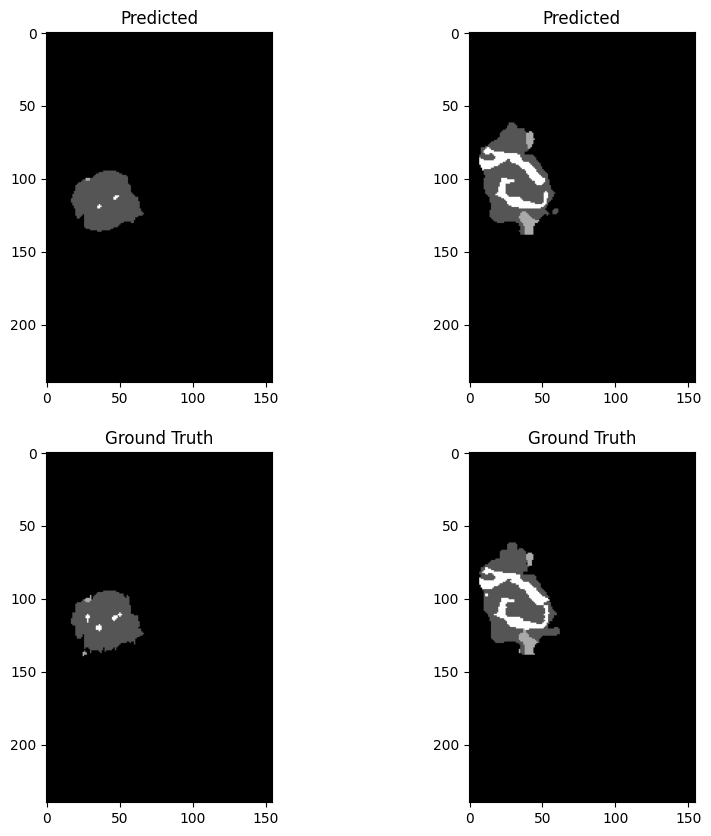

100%|██████████| 189/189 [12:02<00:00,  3.82s/it]



Average Training Loss: 0.006296961671776242

Average Training DSC: [0.99930436 0.92601768 0.94663346 0.83356583]
Average Training ASSD: [ 0.06557642  9.56597845  8.57752987 14.85872617]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


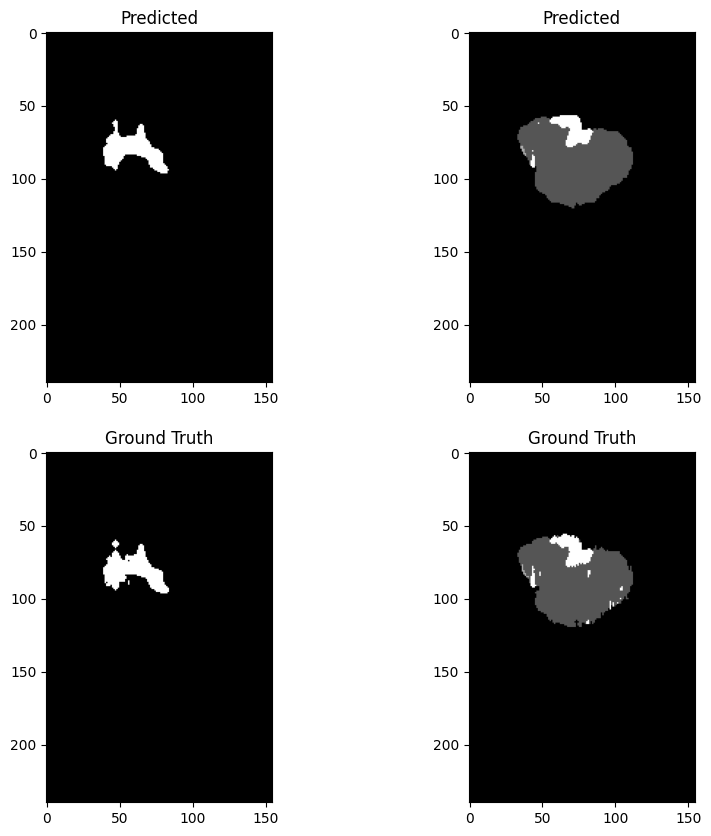

100%|██████████| 48/48 [02:55<00:00,  3.66s/it]


Average Validation Loss: 0.007466600189218298

Average Validation DSC: [0.99923498 0.93019766 0.93981603 0.81159798]
Average Validation ASSD: [ 0.07590883  7.59208741 10.57455913 20.30468468]
Epoch 77/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


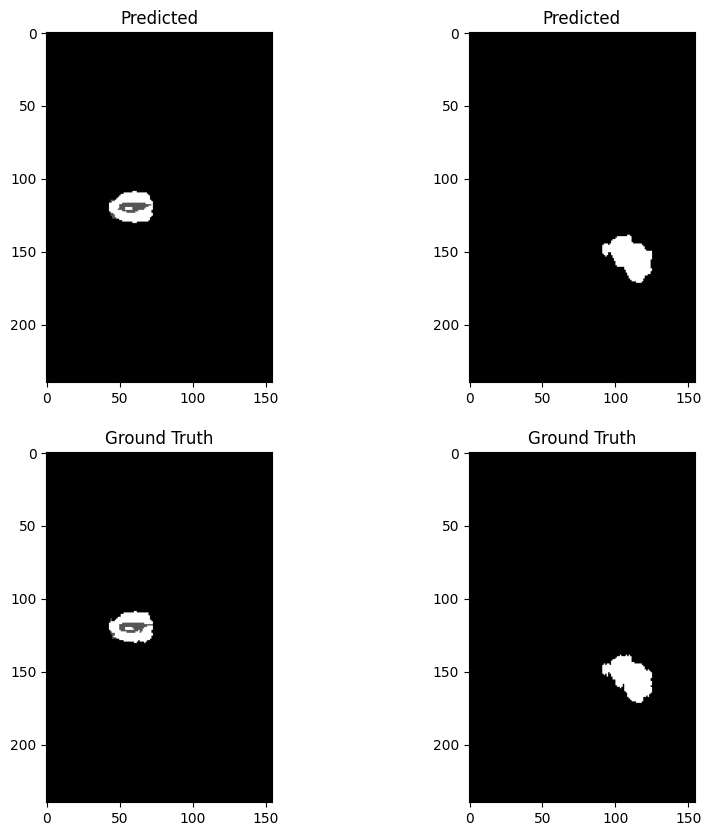

100%|██████████| 189/189 [12:08<00:00,  3.86s/it]



Average Training Loss: 0.005325296365227255

Average Training DSC: [0.99938088 0.94745654 0.94935911 0.84488046]
Average Training ASSD: [ 0.05864514  4.01176946  8.31157709 17.42409846]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


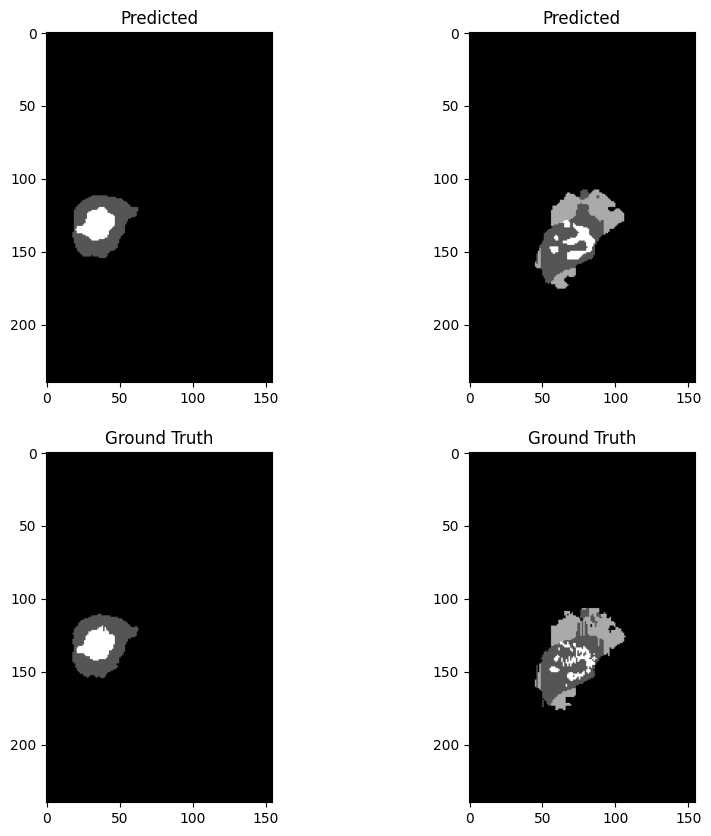

100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Average Validation Loss: 0.008120665501337498

Average Validation DSC: [0.99916142 0.92161698 0.93809361 0.81865661]
Average Validation ASSD: [ 0.08114511  9.16396322  9.27903071 13.41201644]
Epoch 78/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


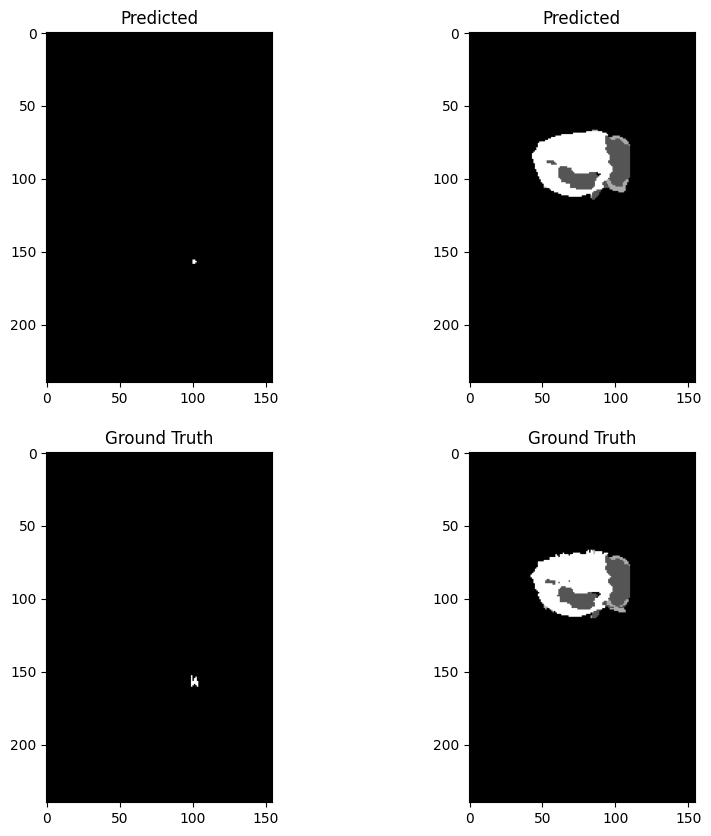

100%|██████████| 189/189 [11:54<00:00,  3.78s/it]



Average Training Loss: 0.004492809170630401

Average Training DSC: [0.99948252 0.95328412 0.9611812  0.86335447]
Average Training ASSD: [ 0.0468796   3.38337506  5.69507217 16.01155529]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


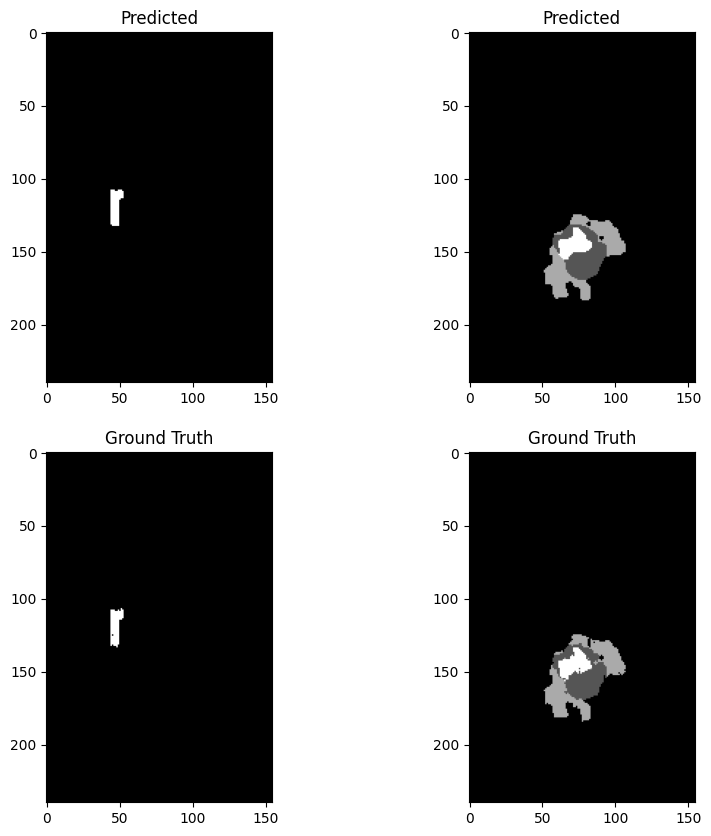

100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


Average Validation Loss: 0.006213961562025361

Average Validation DSC: [0.99936558 0.94042101 0.94818191 0.83817503]
Average Validation ASSD: [ 0.06310734  5.56076358  8.66091585 18.03231033]
Epoch 79/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


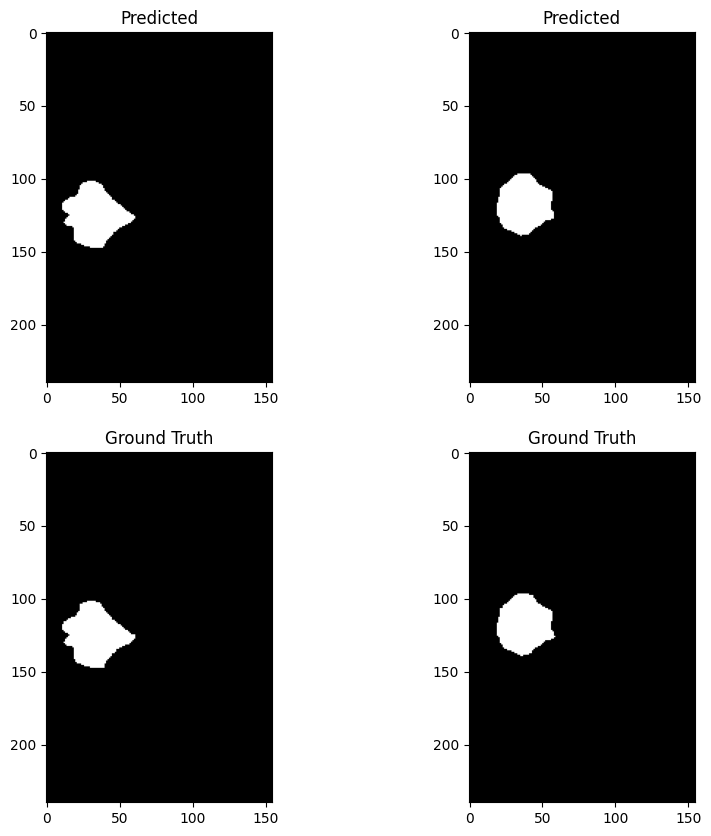

100%|██████████| 189/189 [11:57<00:00,  3.80s/it]



Average Training Loss: 0.003916769675299446

Average Training DSC: [0.99955728 0.95975504 0.96727845 0.87514977]
Average Training ASSD: [ 0.03916432  2.16478791  4.53131655 15.0354346 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


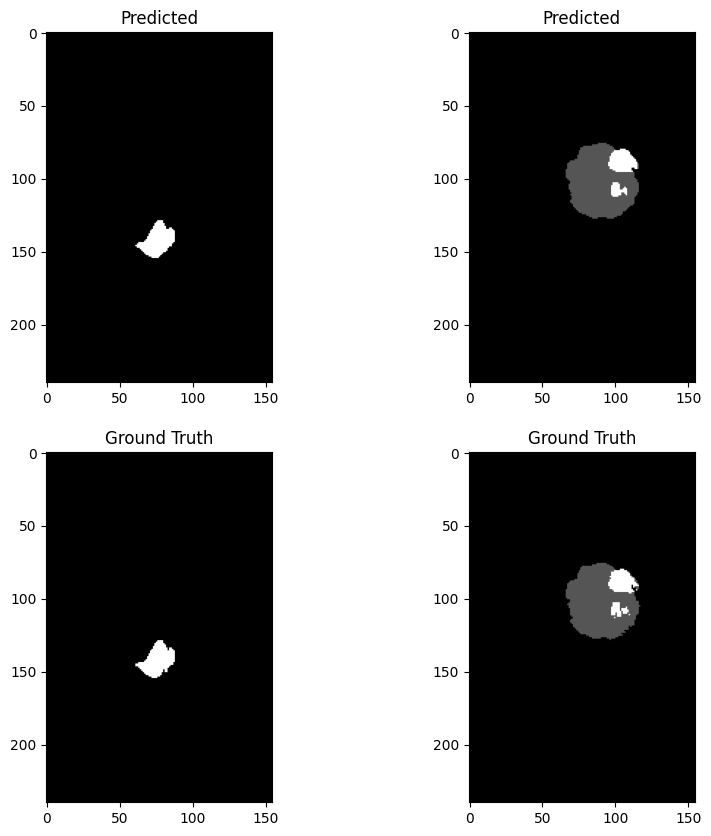

100%|██████████| 48/48 [02:49<00:00,  3.54s/it]


Average Validation Loss: 0.006203599783475511

Average Validation DSC: [0.9993859  0.94239437 0.9470714  0.8440273 ]
Average Validation ASSD: [ 0.0586507   5.194177    9.02625811 15.87443218]
Epoch 80/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


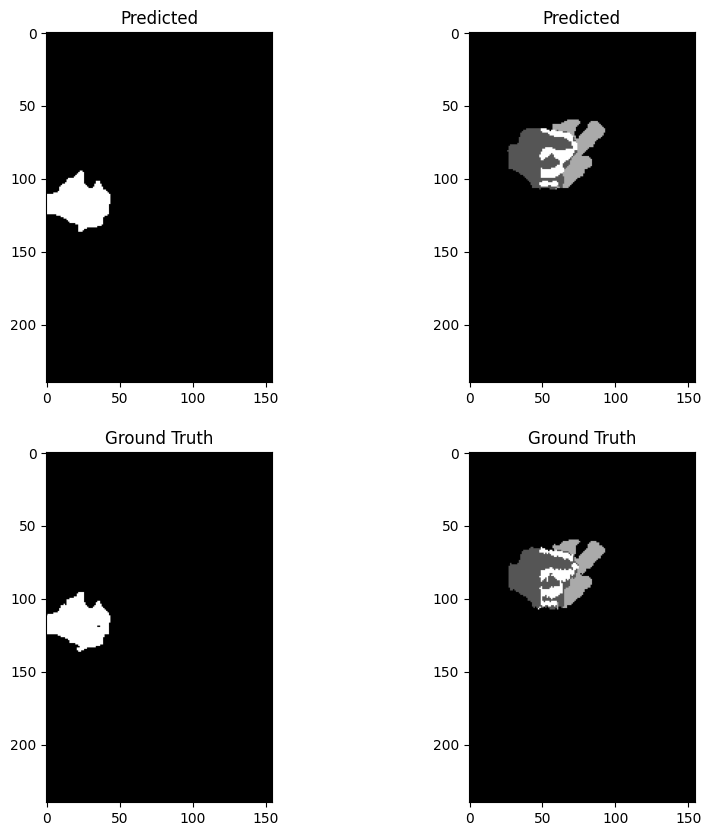

100%|██████████| 189/189 [10:32<00:00,  3.34s/it]



Average Training Loss: 0.0038753071930456573

Average Training DSC: [0.99955786 0.96047297 0.96784956 0.87781163]
Average Training ASSD: [ 0.03916501  2.15882305  4.47951364 14.80872481]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


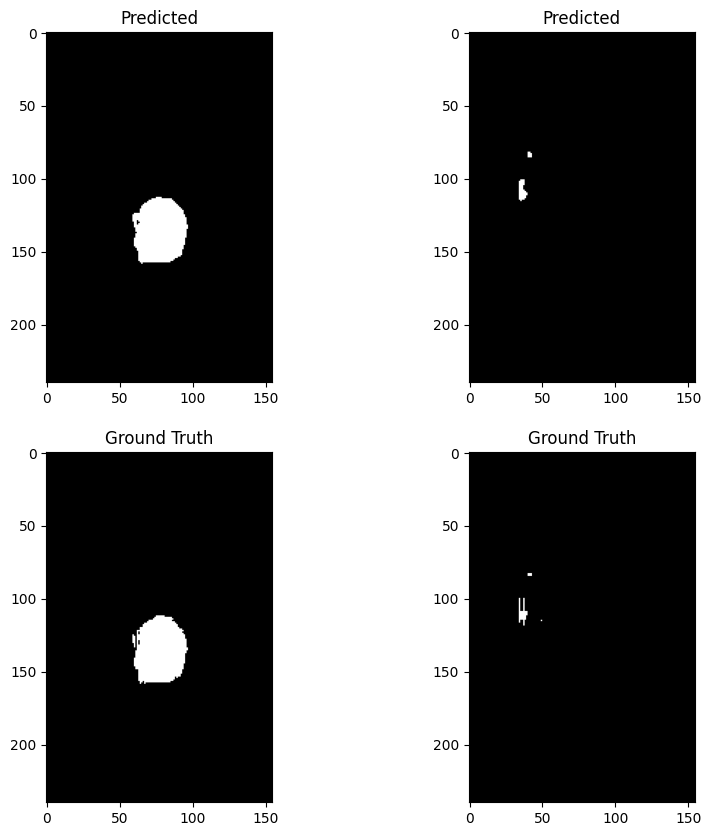

100%|██████████| 48/48 [01:26<00:00,  1.81s/it]


Average Validation Loss: 0.0061502629541791975

Average Validation DSC: [0.99940641 0.94613656 0.94768216 0.84863379]
Average Validation ASSD: [ 0.05740008  4.23292176  8.89130819 15.76809369]
Epoch 81/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


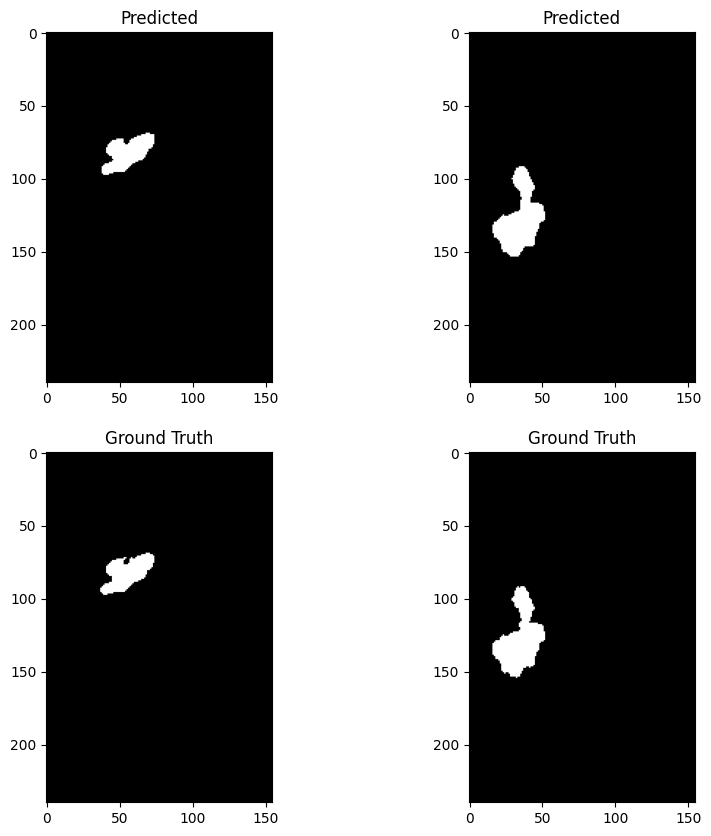

100%|██████████| 189/189 [06:31<00:00,  2.07s/it]



Average Training Loss: 0.0036466217238860076

Average Training DSC: [0.99959562 0.96268427 0.96913717 0.88341091]
Average Training ASSD: [ 0.03512578  1.79129401  4.05556496 14.25214271]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


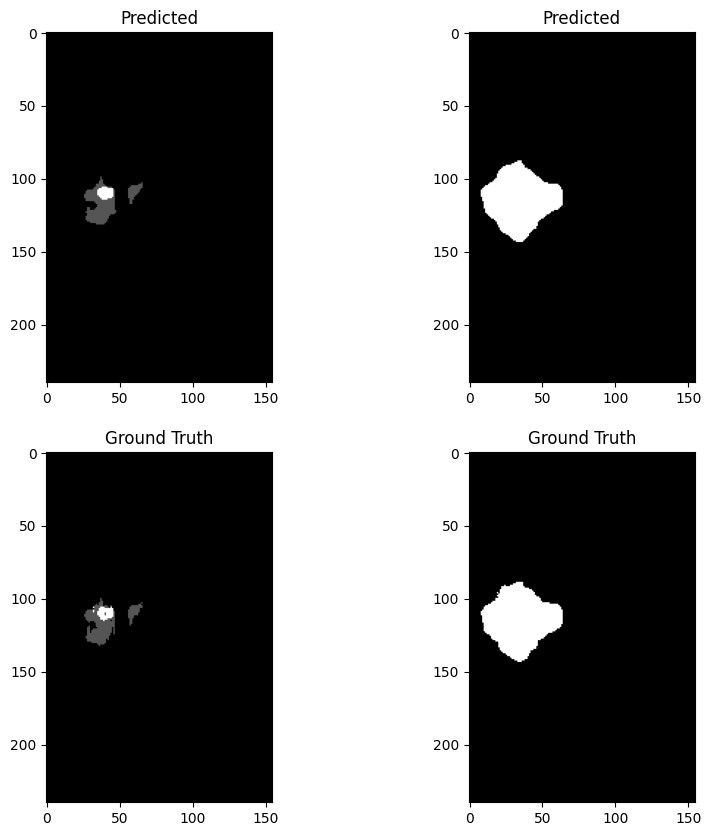

100%|██████████| 48/48 [01:33<00:00,  1.94s/it]


Average Validation Loss: 0.006116839445894584

Average Validation DSC: [0.99940446 0.94521509 0.94948039 0.84868549]
Average Validation ASSD: [ 0.05743959  4.47612349  8.61363141 14.93723036]
Epoch 82/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


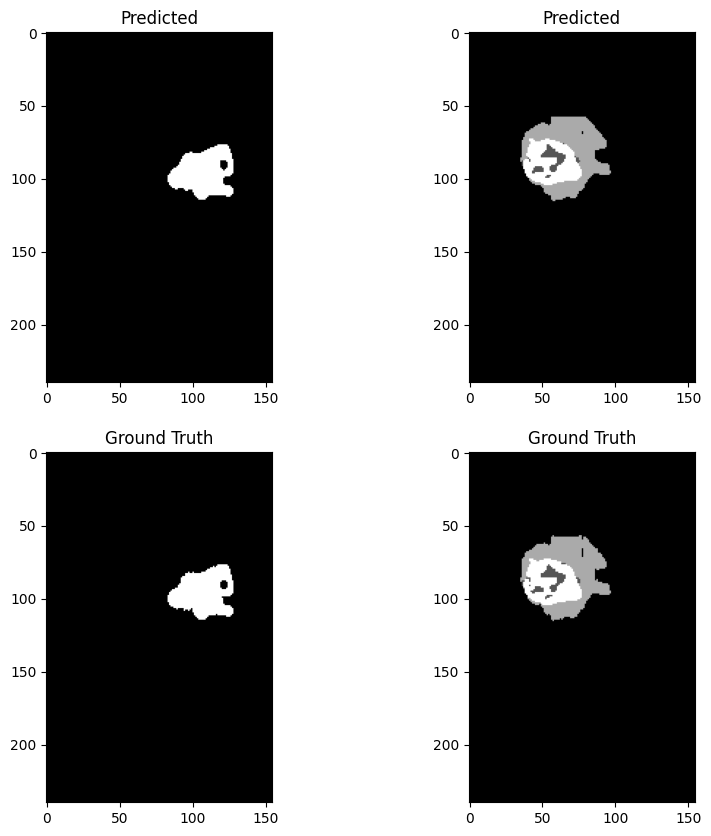

100%|██████████| 189/189 [06:27<00:00,  2.05s/it]



Average Training Loss: 0.0036131468300939235

Average Training DSC: [0.99960004 0.96148972 0.96883759 0.88575725]
Average Training ASSD: [ 0.03440921  2.32749286  4.51677122 13.47133231]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


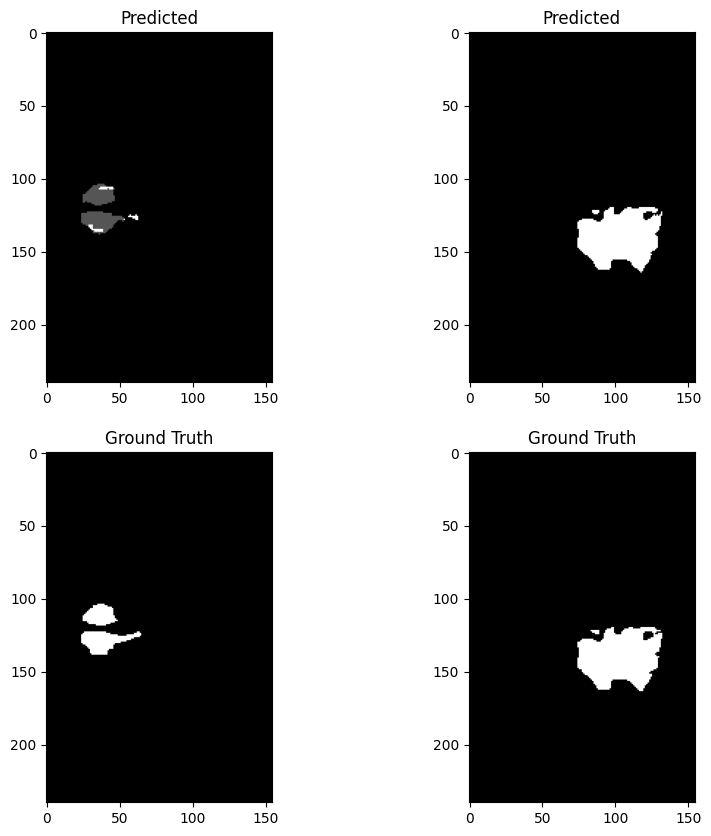

100%|██████████| 48/48 [01:26<00:00,  1.81s/it]


Average Validation Loss: 0.00603043630932613

Average Validation DSC: [0.99941809 0.94655197 0.94903706 0.84879067]
Average Validation ASSD: [ 0.05701832  4.46666896  9.08993755 14.69791202]
Epoch 83/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


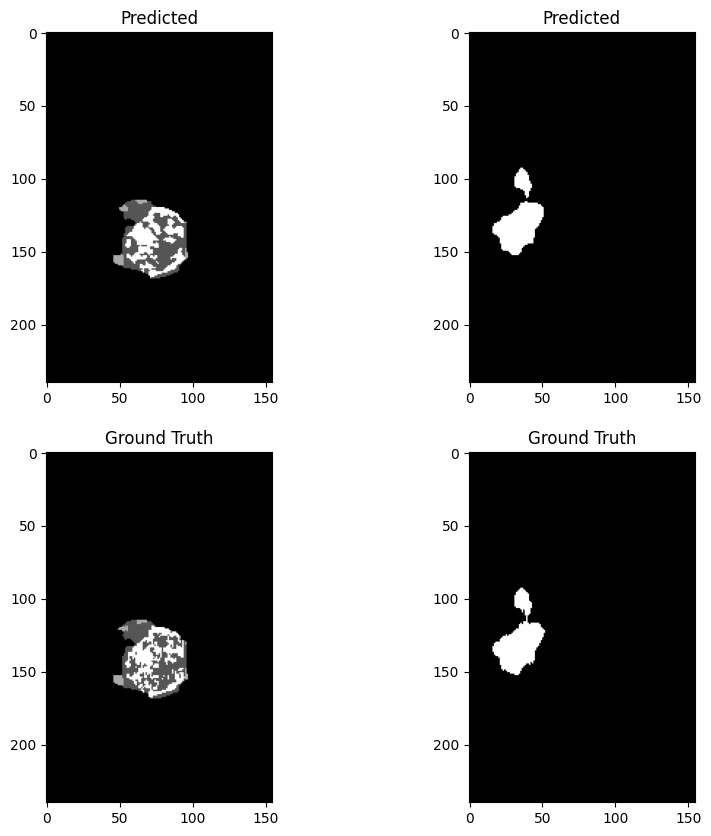

100%|██████████| 189/189 [04:16<00:00,  1.36s/it]



Average Training Loss: 0.003625998593787983

Average Training DSC: [0.99959524 0.96287855 0.96876881 0.88513924]
Average Training ASSD: [ 0.03495951  1.49087857  4.17638345 13.18292064]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


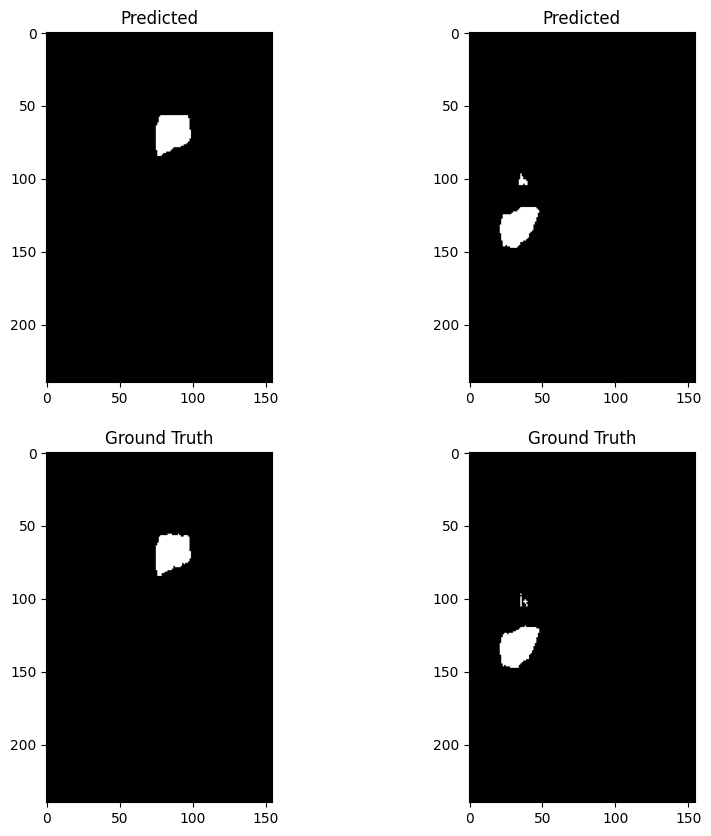

100%|██████████| 48/48 [00:38<00:00,  1.23it/s]


Average Validation Loss: 0.0061403845029417425

Average Validation DSC: [0.99940888 0.94560628 0.94748137 0.85253658]
Average Validation ASSD: [ 0.05719274  4.94213116  9.08559006 13.93464161]
Epoch 84/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


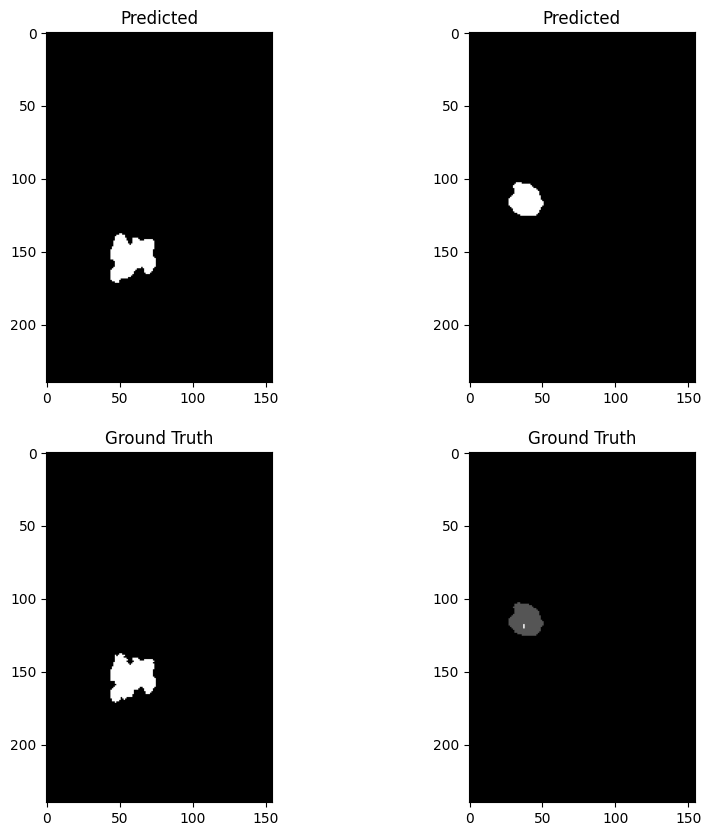

100%|██████████| 189/189 [03:15<00:00,  1.03s/it]



Average Training Loss: 0.0035397943550297033

Average Training DSC: [0.99960304 0.9635437  0.96871995 0.8875867 ]
Average Training ASSD: [ 0.03403897  1.66525064  4.69241994 13.4059865 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


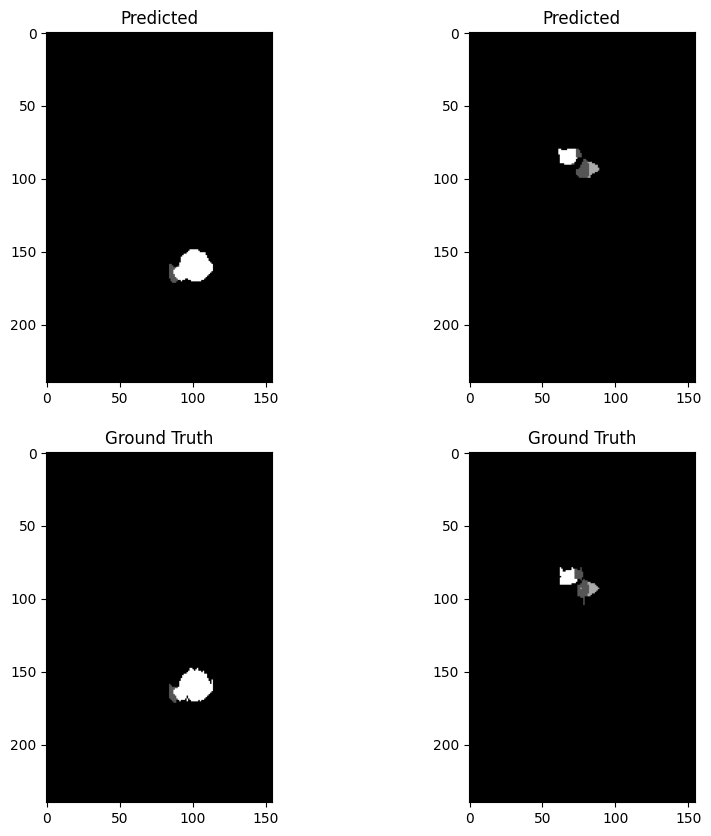

100%|██████████| 48/48 [00:39<00:00,  1.22it/s]


Average Validation Loss: 0.006117983367100048

Average Validation DSC: [0.99941432 0.94879388 0.94784101 0.85273608]
Average Validation ASSD: [ 0.05750909  3.98877005  8.38540704 15.15476537]
Epoch 85/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


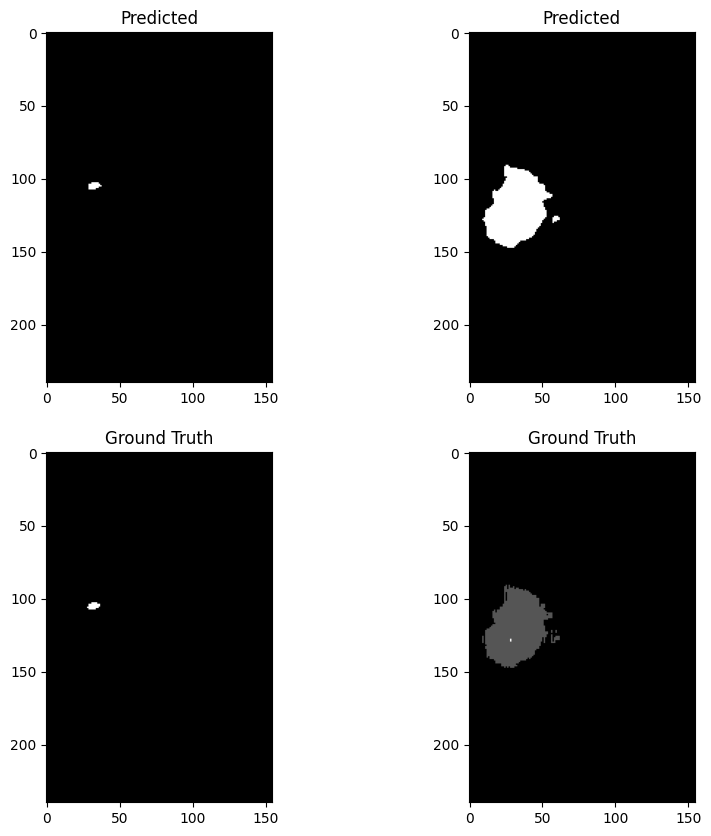

100%|██████████| 189/189 [03:20<00:00,  1.06s/it]



Average Training Loss: 0.0035924091479351754

Average Training DSC: [0.99959593 0.9626031  0.96828679 0.8877179 ]
Average Training ASSD: [ 0.03417801  2.08563271  4.2451844  12.21464627]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


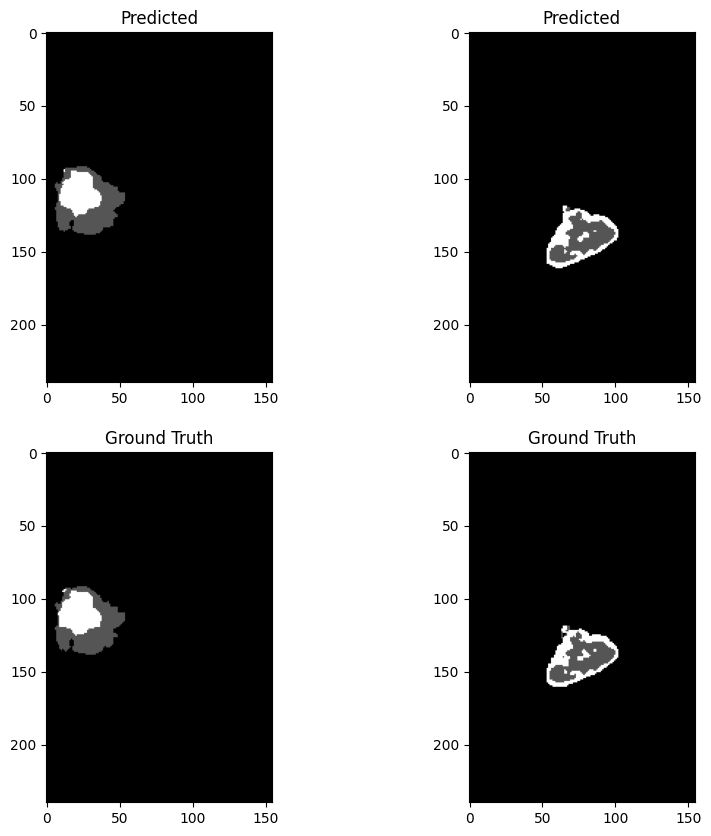

100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Average Validation Loss: 0.006101283317548223

Average Validation DSC: [0.99941171 0.94716568 0.94626277 0.85338041]
Average Validation ASSD: [ 0.05683387  4.23598621  9.58565841 13.46383057]
Epoch 86/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


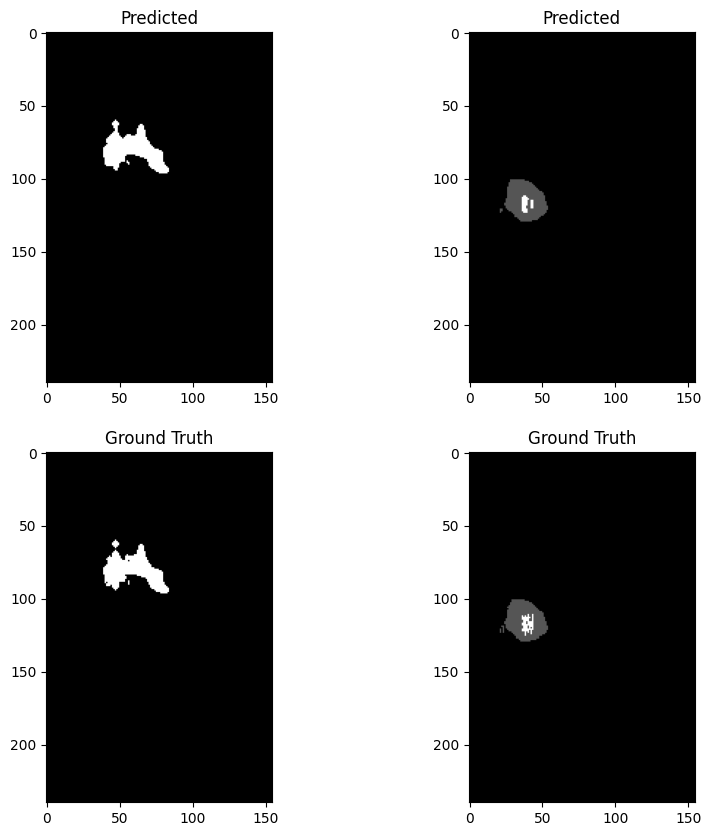

100%|██████████| 189/189 [03:21<00:00,  1.06s/it]



Average Training Loss: 0.003479136040720044

Average Training DSC: [0.99961357 0.96365324 0.96925706 0.89013808]
Average Training ASSD: [ 0.03298042  1.54564299  4.2323226  12.14462996]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


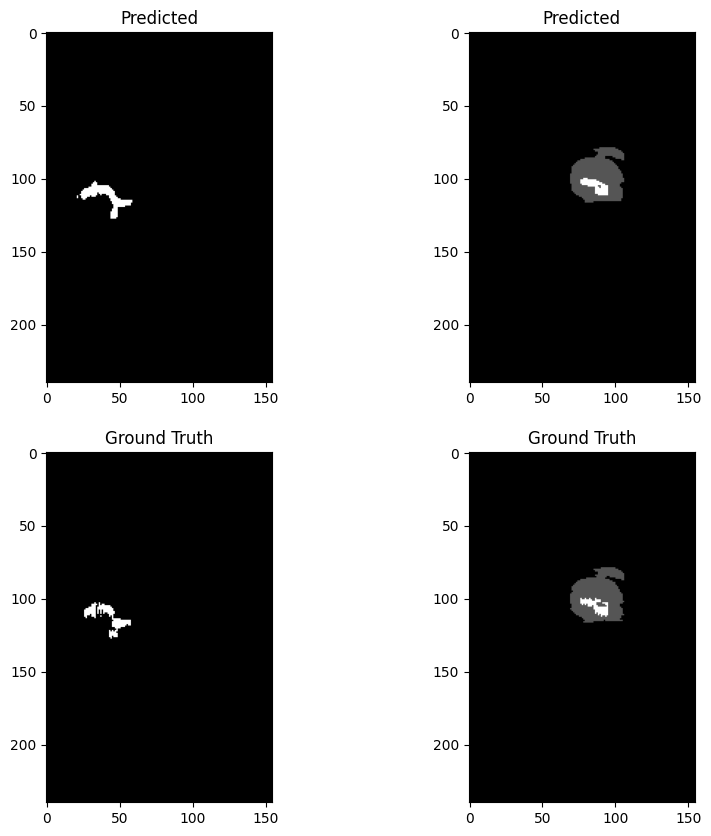

100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


Average Validation Loss: 0.005983411950486091

Average Validation DSC: [0.9994285  0.94721718 0.94525382 0.85349619]
Average Validation ASSD: [ 0.05549202  4.22727966  9.47923504 14.43641493]
Epoch 87/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


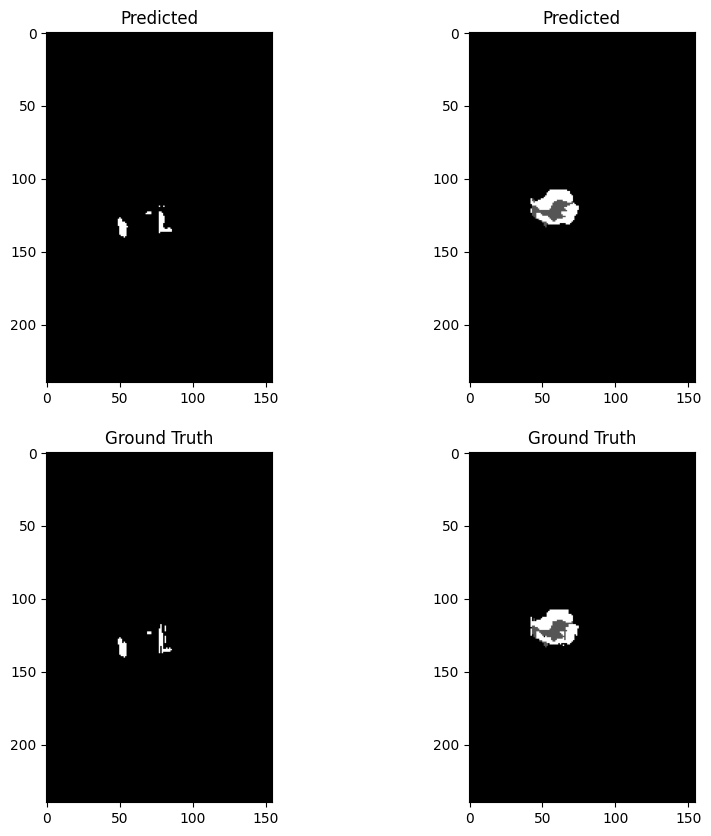

100%|██████████| 189/189 [03:18<00:00,  1.05s/it]



Average Training Loss: 0.003575230762608862

Average Training DSC: [0.99959046 0.9634939  0.9686933  0.88792323]
Average Training ASSD: [ 0.03486584  1.6673321   4.11225203 12.16628215]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


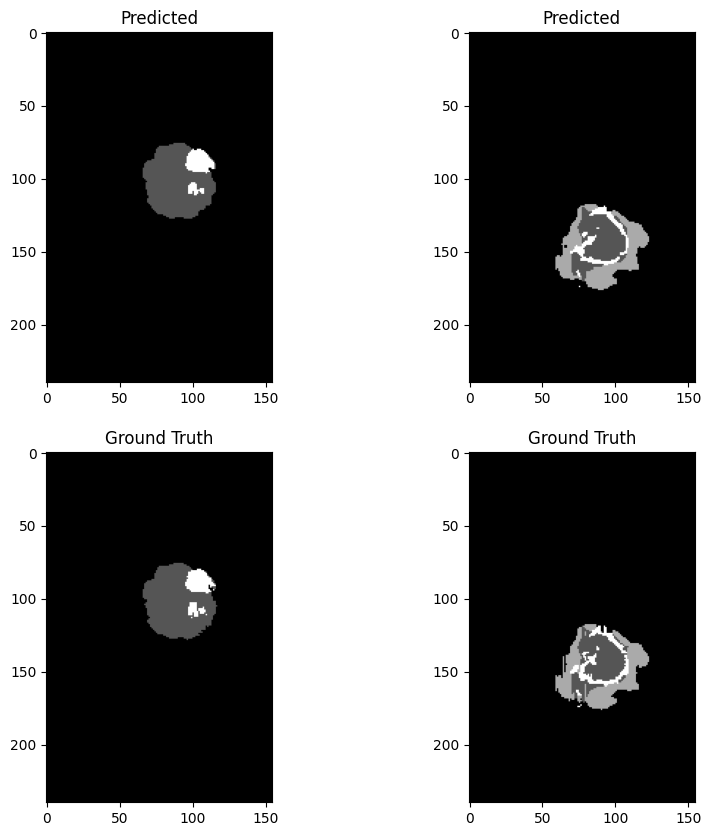

100%|██████████| 48/48 [00:40<00:00,  1.20it/s]


Average Validation Loss: 0.00607621011537655

Average Validation DSC: [0.99939954 0.94605695 0.94843911 0.85203523]
Average Validation ASSD: [ 0.0583581   4.23714867  8.63651073 13.80340027]
Epoch 88/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


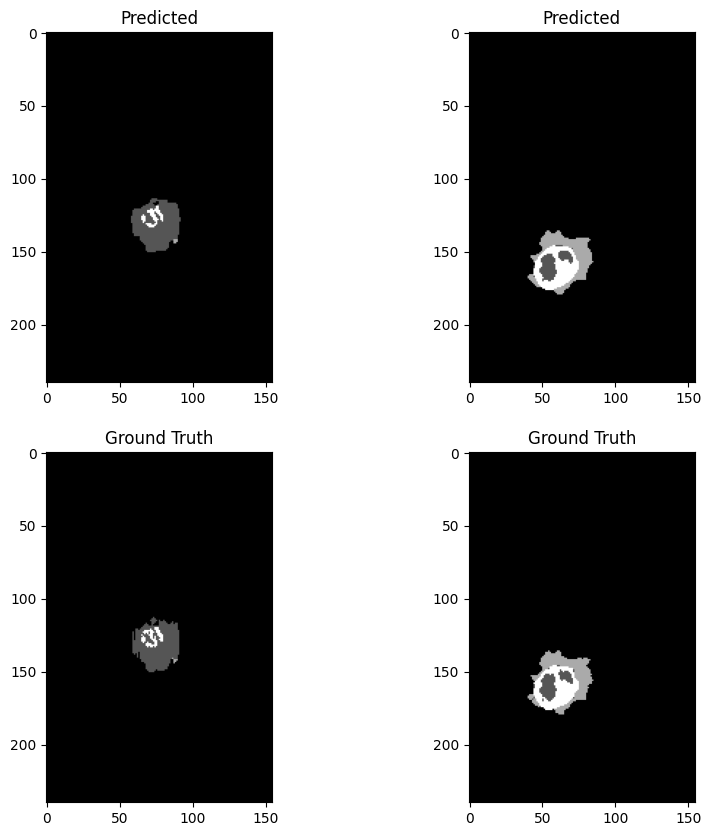

100%|██████████| 189/189 [03:18<00:00,  1.05s/it]



Average Training Loss: 0.0035155216581804097

Average Training DSC: [0.99960254 0.96298797 0.96885158 0.8884691 ]
Average Training ASSD: [ 0.03450636  1.72663439  4.34977309 12.93076082]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


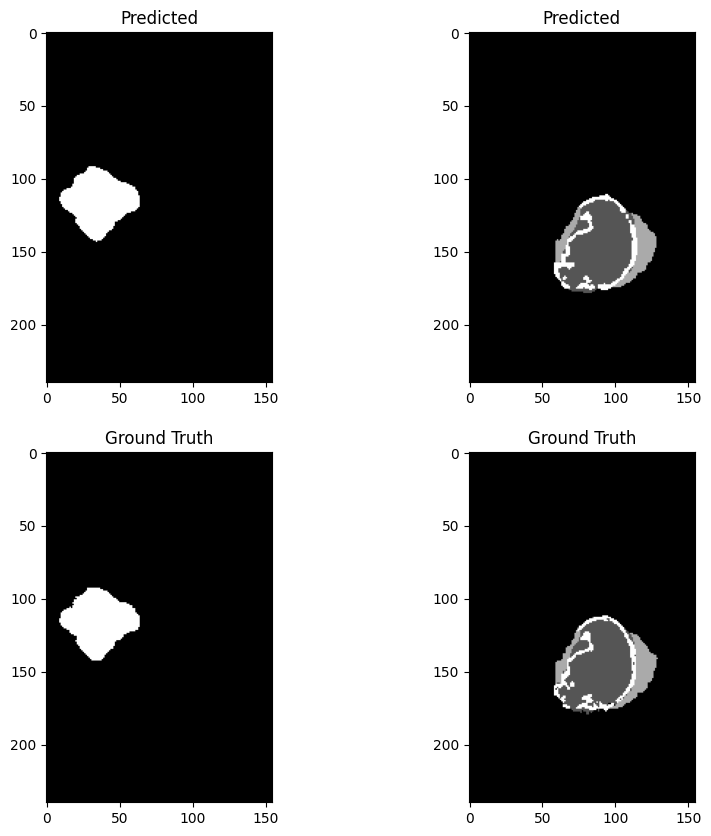

100%|██████████| 48/48 [00:39<00:00,  1.21it/s]


Average Validation Loss: 0.006149542042597507

Average Validation DSC: [0.99940997 0.94702785 0.94627593 0.85031051]
Average Validation ASSD: [ 0.05818742  3.52652123  8.86378175 14.94469285]
Epoch 89/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


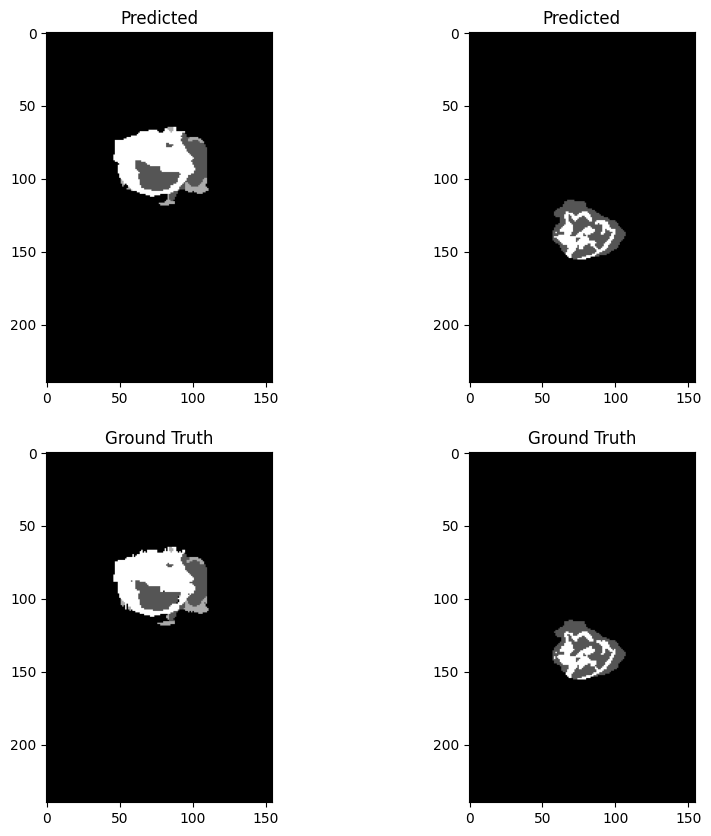

100%|██████████| 189/189 [03:21<00:00,  1.07s/it]



Average Training Loss: 0.003442415000535745

Average Training DSC: [0.99961161 0.96451518 0.97071058 0.89167954]
Average Training ASSD: [ 0.03302525  1.83880224  3.93133615 11.49833774]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


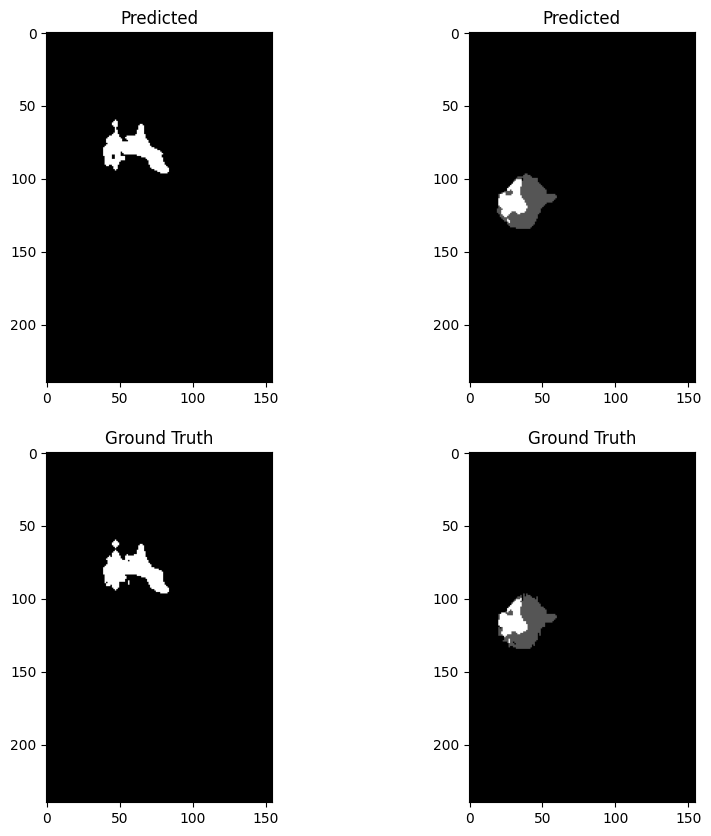

100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


Average Validation Loss: 0.006096866268004912

Average Validation DSC: [0.99941293 0.94780021 0.94853574 0.8474612 ]
Average Validation ASSD: [ 0.05703533  4.23062684  8.62187282 15.03414427]
Epoch 90/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


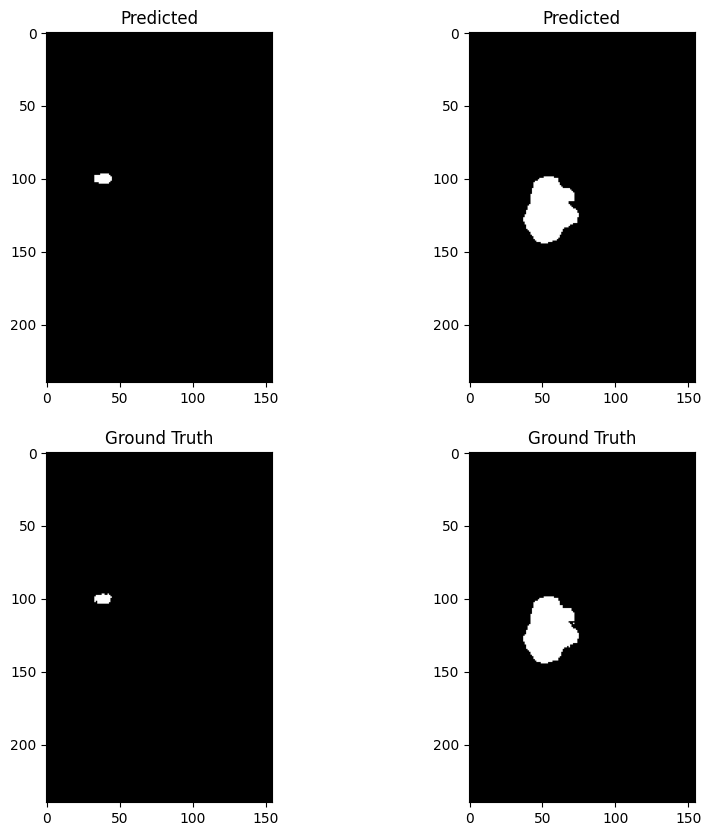

100%|██████████| 189/189 [03:19<00:00,  1.06s/it]



Average Training Loss: 0.0034352586753715678

Average Training DSC: [0.99961302 0.96425028 0.96904879 0.89238152]
Average Training ASSD: [ 0.03281589  1.72007011  4.15637934 11.74083456]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


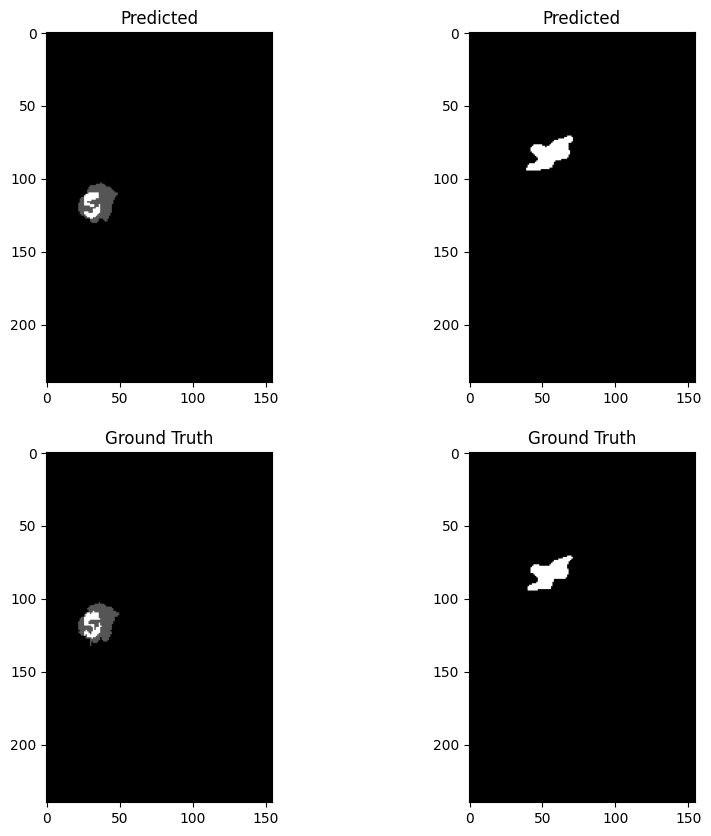

100%|██████████| 48/48 [00:39<00:00,  1.20it/s]


Average Validation Loss: 0.006109006431264182

Average Validation DSC: [0.99942171 0.9481504  0.94875823 0.86049753]
Average Validation ASSD: [ 0.05607663  4.45212095  7.47581321 12.77732684]
Epoch 91/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


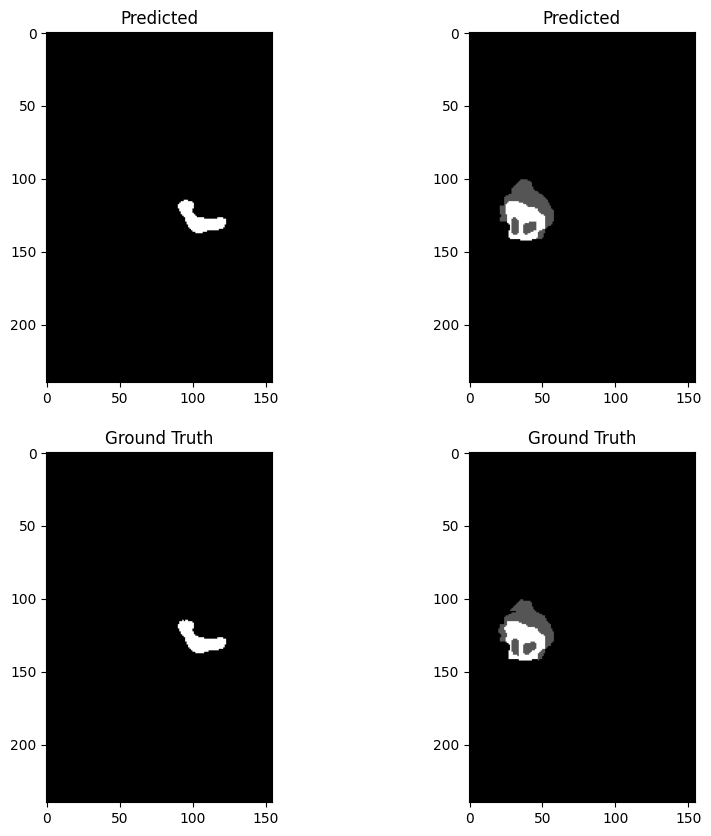

100%|██████████| 189/189 [03:19<00:00,  1.06s/it]



Average Training Loss: 0.0033105548308600507

Average Training DSC: [0.99963073 0.96592989 0.97073869 0.89656859]
Average Training ASSD: [ 0.03097258  1.65377194  3.97732469 11.52836809]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


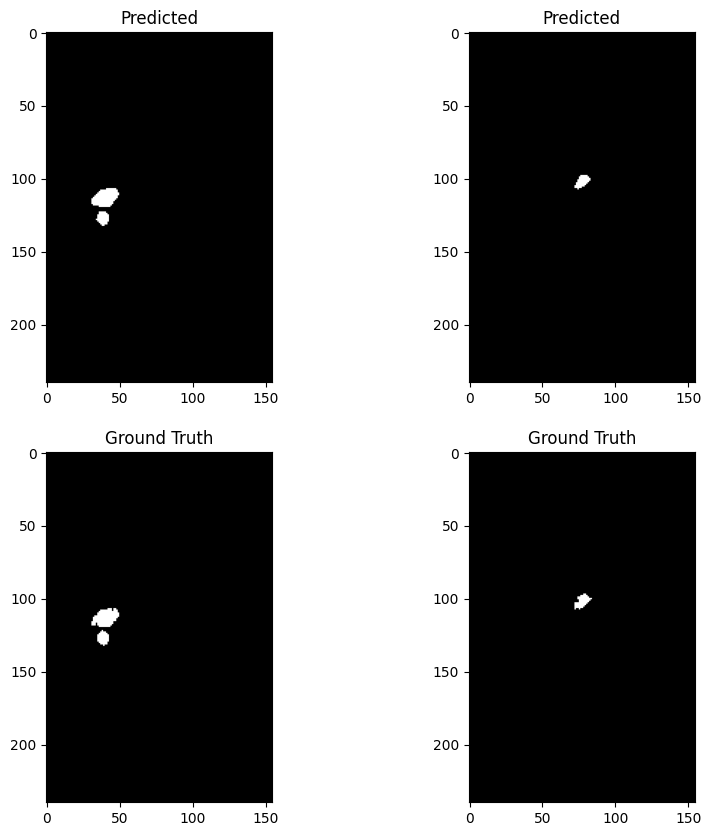

100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


Average Validation Loss: 0.006119351436306412

Average Validation DSC: [0.99942675 0.945151   0.94994747 0.85819421]
Average Validation ASSD: [ 0.05668046  4.46208463  8.16432541 11.93136584]
Epoch 92/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


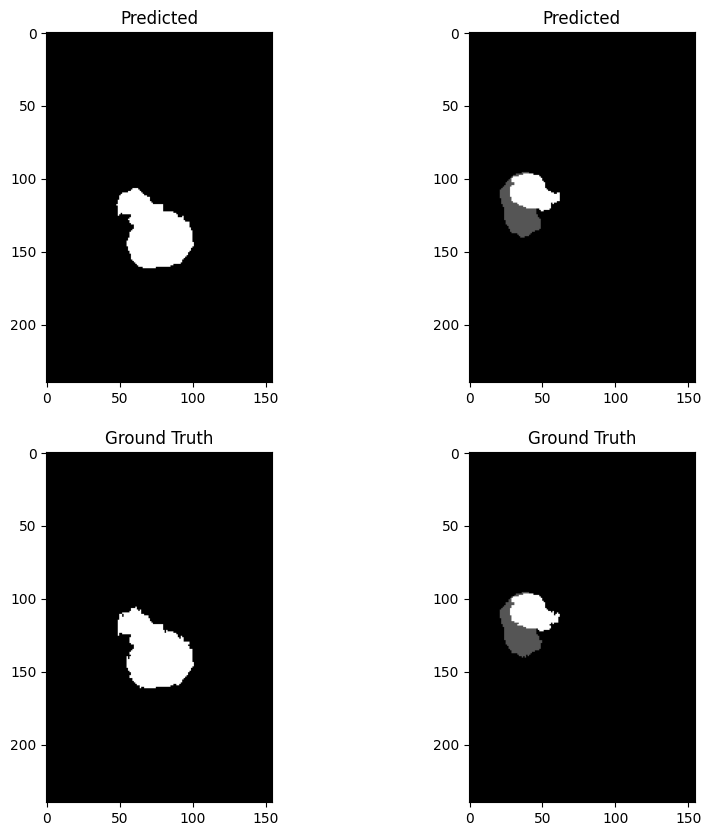

100%|██████████| 189/189 [03:22<00:00,  1.07s/it]



Average Training Loss: 0.003310329402136621

Average Training DSC: [0.99963295 0.96423435 0.97104063 0.89408187]
Average Training ASSD: [ 0.03156762  2.01415345  3.91442227 12.02796592]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


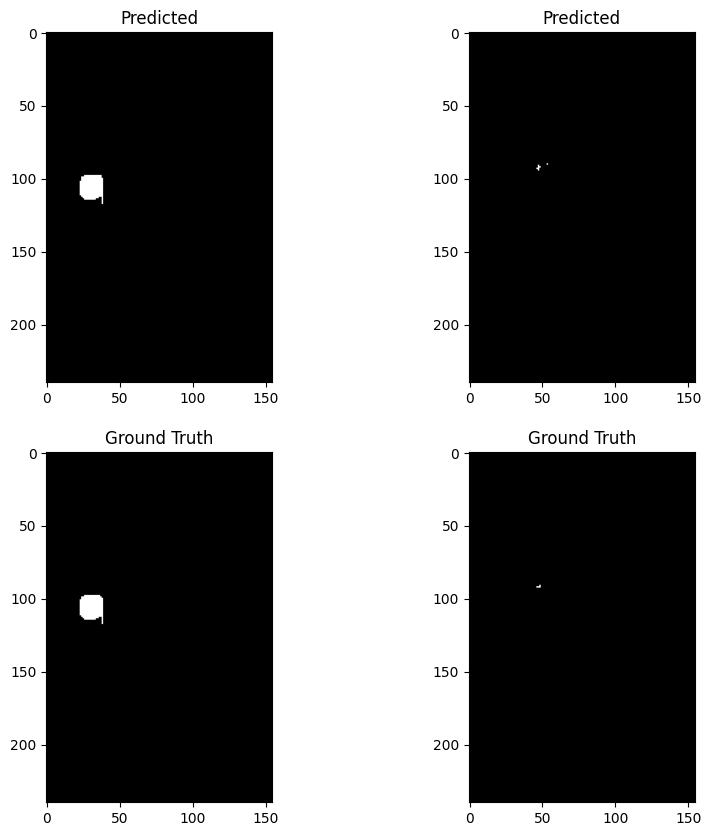

100%|██████████| 48/48 [00:39<00:00,  1.22it/s]


Average Validation Loss: 0.006154312868602574

Average Validation DSC: [0.99942335 0.9481428  0.94948997 0.8588452 ]
Average Validation ASSD: [ 0.0560093   4.45897453  7.69510034 12.92346882]
Epoch 93/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


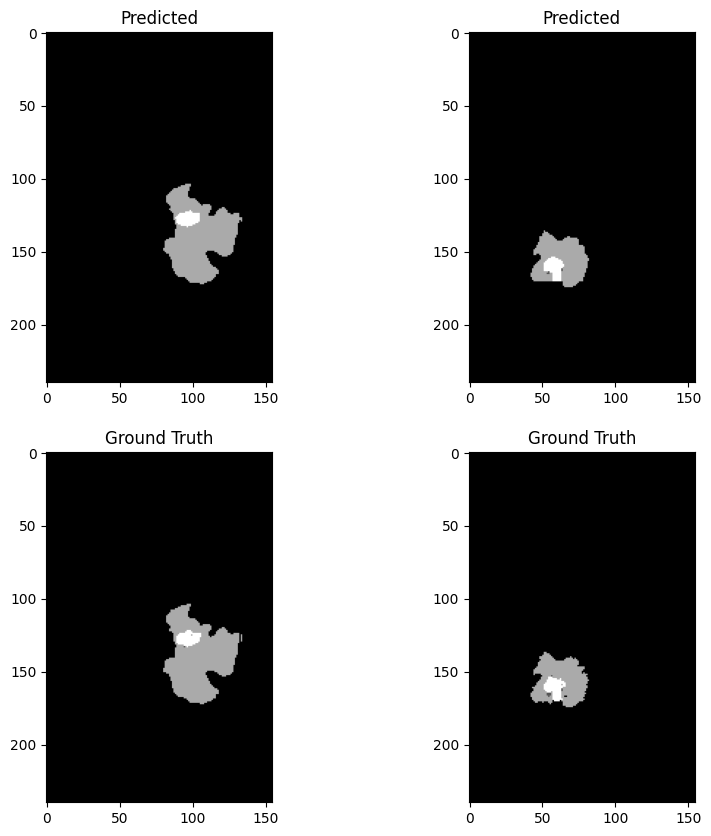

100%|██████████| 189/189 [03:15<00:00,  1.04s/it]



Average Training Loss: 0.003193717302074508

Average Training DSC: [0.99964389 0.96597232 0.97159313 0.89995126]
Average Training ASSD: [ 0.02983993  1.94530082  4.09111616 10.86289077]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


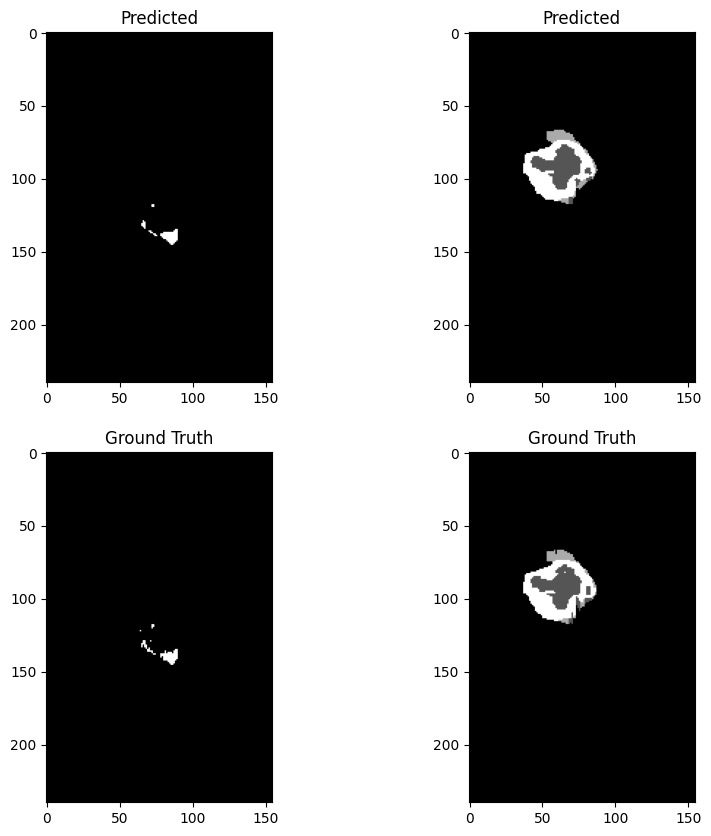

100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Average Validation Loss: 0.006058671991922893

Average Validation DSC: [0.99944493 0.94943365 0.94605179 0.86239411]
Average Validation ASSD: [ 0.05354458  4.216177    7.88662859 12.33022448]
Epoch 94/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


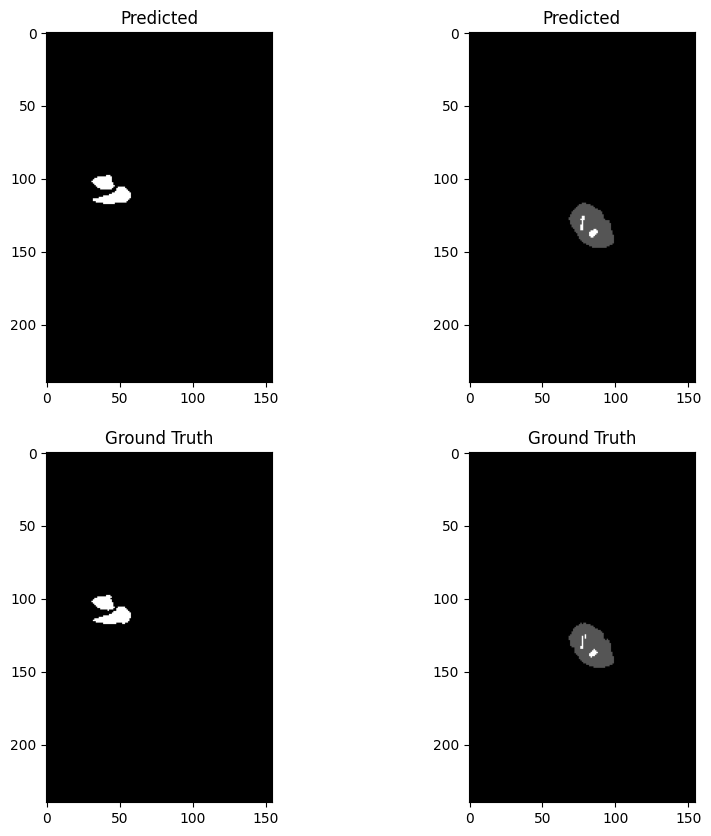

100%|██████████| 189/189 [03:18<00:00,  1.05s/it]



Average Training Loss: 0.00320878798122365

Average Training DSC: [0.99964376 0.96611253 0.97161056 0.90002973]
Average Training ASSD: [ 0.03023994  1.47145275  3.73593344 10.69761939]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


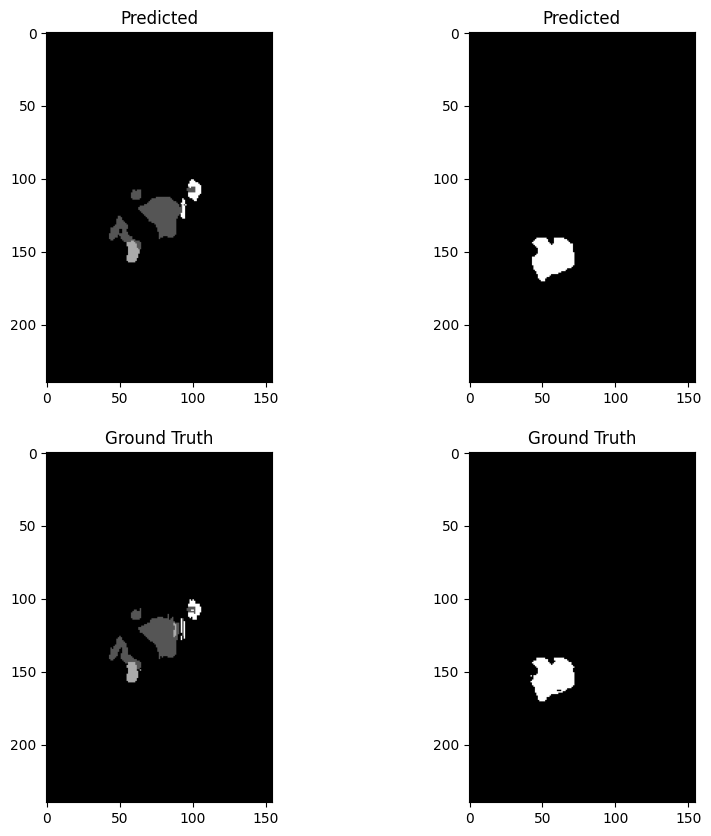

100%|██████████| 48/48 [00:39<00:00,  1.23it/s]


Average Validation Loss: 0.0060180810299546765

Average Validation DSC: [0.99944862 0.94890264 0.95297003 0.86019556]
Average Validation ASSD: [ 0.05388962  4.45075323  6.99556571 13.24662474]
Epoch 95/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


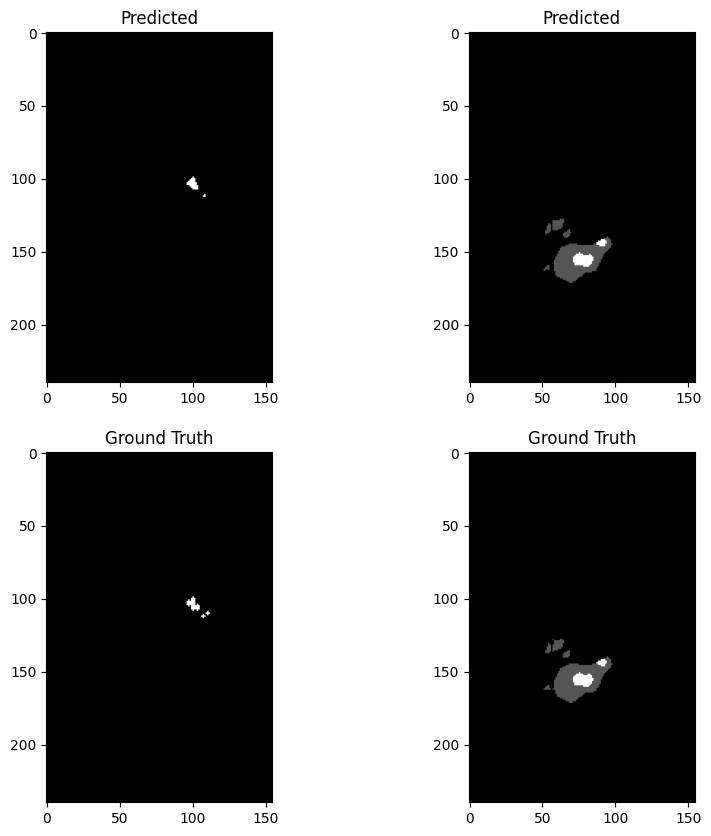

100%|██████████| 189/189 [03:18<00:00,  1.05s/it]



Average Training Loss: 0.003223987051689869

Average Training DSC: [0.99963815 0.96475663 0.97084655 0.89940337]
Average Training ASSD: [ 0.03048831  2.12987694  4.33632333 10.81735033]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


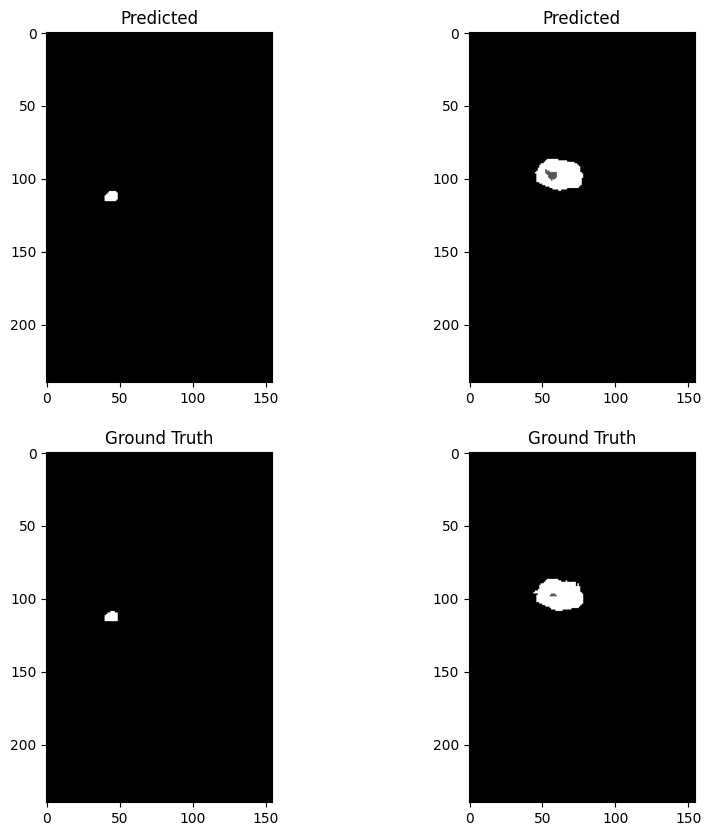

100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Average Validation Loss: 0.006071288274445881

Average Validation DSC: [0.99945068 0.94775552 0.94992708 0.86310575]
Average Validation ASSD: [ 0.0541231   5.15690747  7.22839653 11.63252356]
Epoch 96/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


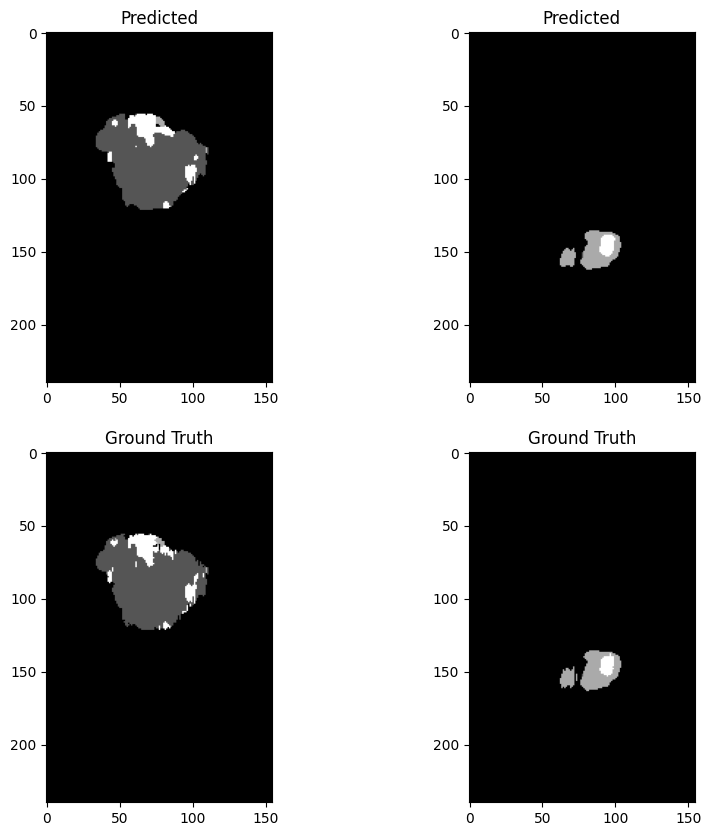

100%|██████████| 189/189 [03:26<00:00,  1.09s/it]



Average Training Loss: 0.003178068052326876

Average Training DSC: [0.99964144 0.96670622 0.97214514 0.90059021]
Average Training ASSD: [ 0.03032472  1.58752351  3.61602108 11.11009868]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


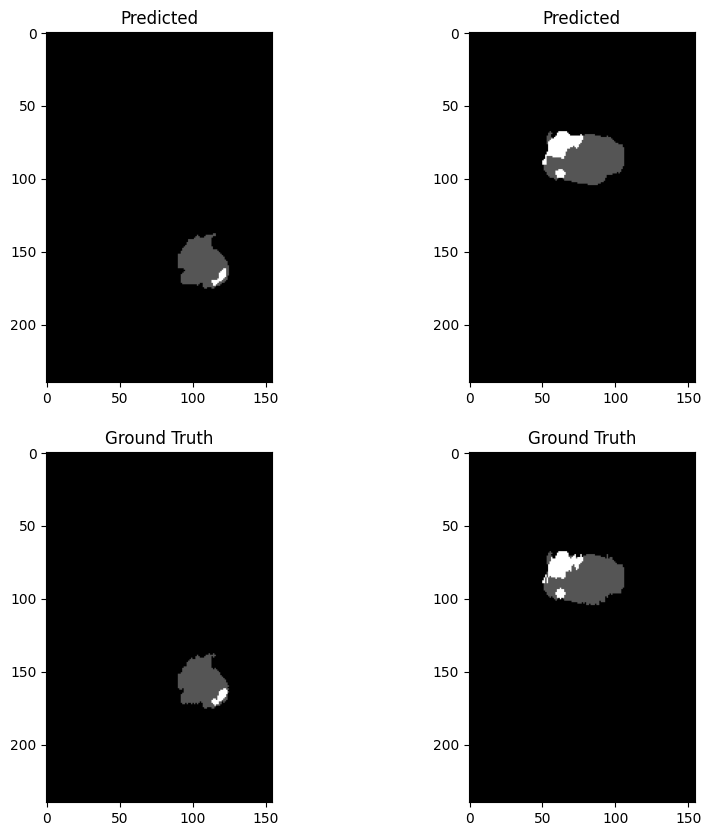

100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Average Validation Loss: 0.006171628493272389

Average Validation DSC: [0.99942787 0.94916233 0.94732917 0.85910369]
Average Validation ASSD: [ 0.05514706  4.92535862  8.76968108 11.68200901]
Epoch 97/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


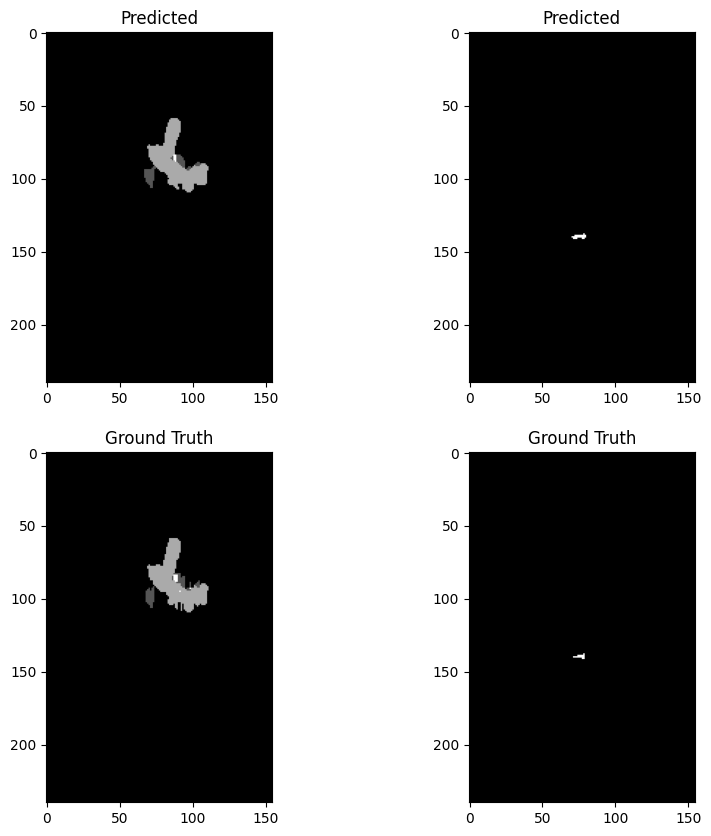

100%|██████████| 189/189 [03:23<00:00,  1.08s/it]



Average Training Loss: 0.0031557971095449474

Average Training DSC: [0.99964572 0.96638544 0.96923314 0.9010196 ]
Average Training ASSD: [ 0.02981272  1.82536417  4.87384624 11.04555511]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


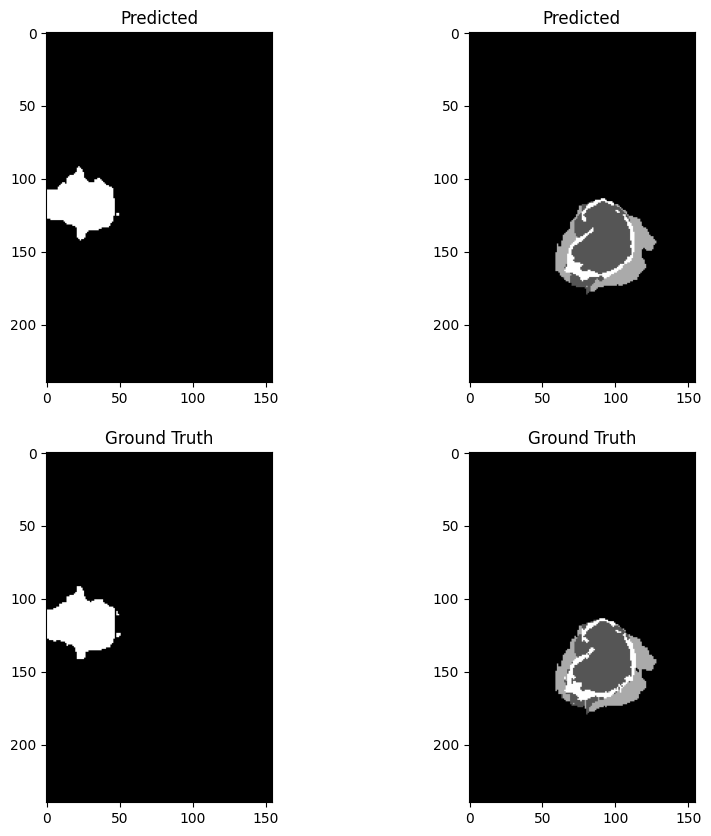

100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Average Validation Loss: 0.006284725333292347

Average Validation DSC: [0.99940892 0.94620719 0.94774545 0.85547197]
Average Validation ASSD: [ 0.05919595  4.69463054  7.91546111 15.55766734]
Epoch 98/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


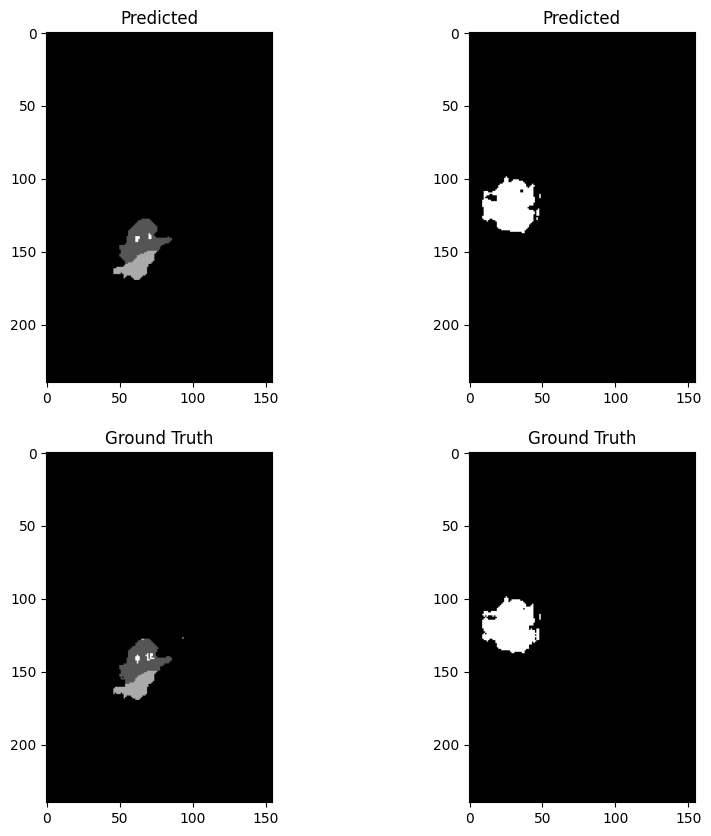

100%|██████████| 189/189 [03:27<00:00,  1.10s/it]



Average Training Loss: 0.0031028015874129122

Average Training DSC: [0.99965589 0.96736177 0.97117686 0.9044037 ]
Average Training ASSD: [0.02862715 1.40600947 4.26966668 9.96317084]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


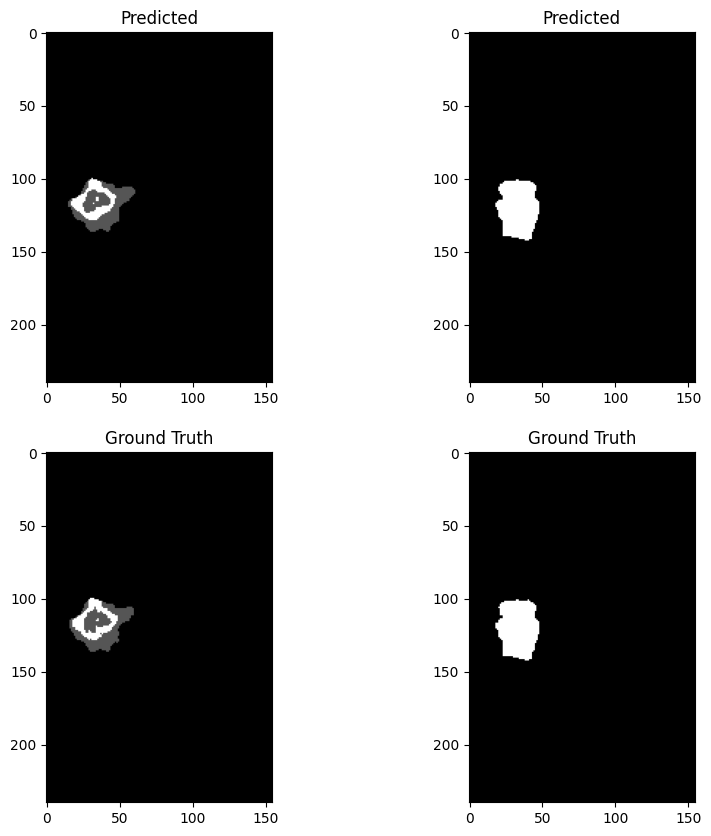

100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Average Validation Loss: 0.0061354023588743685

Average Validation DSC: [0.99943498 0.95045649 0.95229594 0.86493573]
Average Validation ASSD: [ 0.05371725  3.97230369  7.21039978 11.58313494]
Epoch 99/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


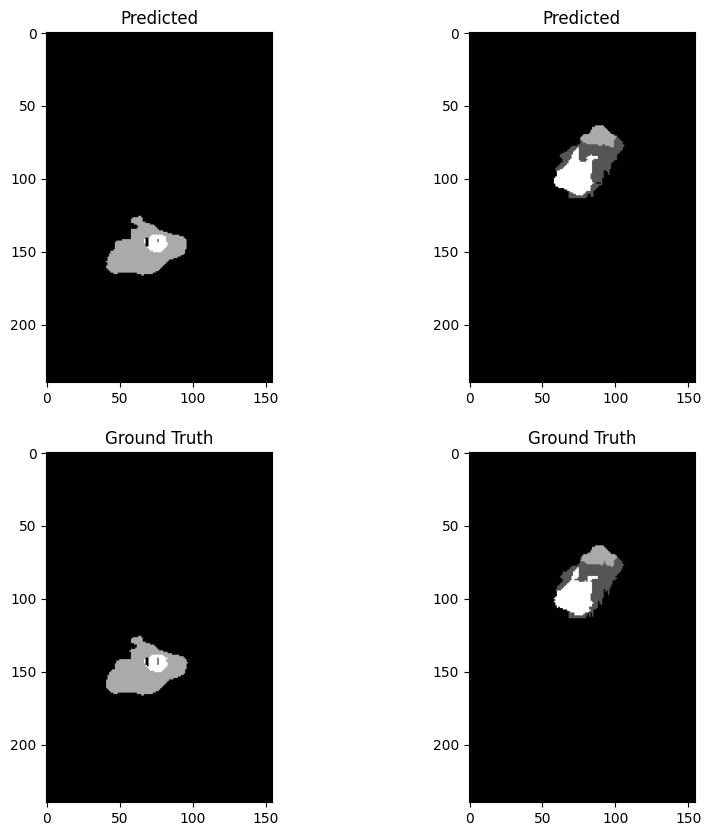

100%|██████████| 189/189 [03:27<00:00,  1.10s/it]



Average Training Loss: 0.003085240686593193

Average Training DSC: [0.99967249 0.96554013 0.97185649 0.90275509]
Average Training ASSD: [ 0.02720132  2.06378315  3.85819002 10.02823772]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


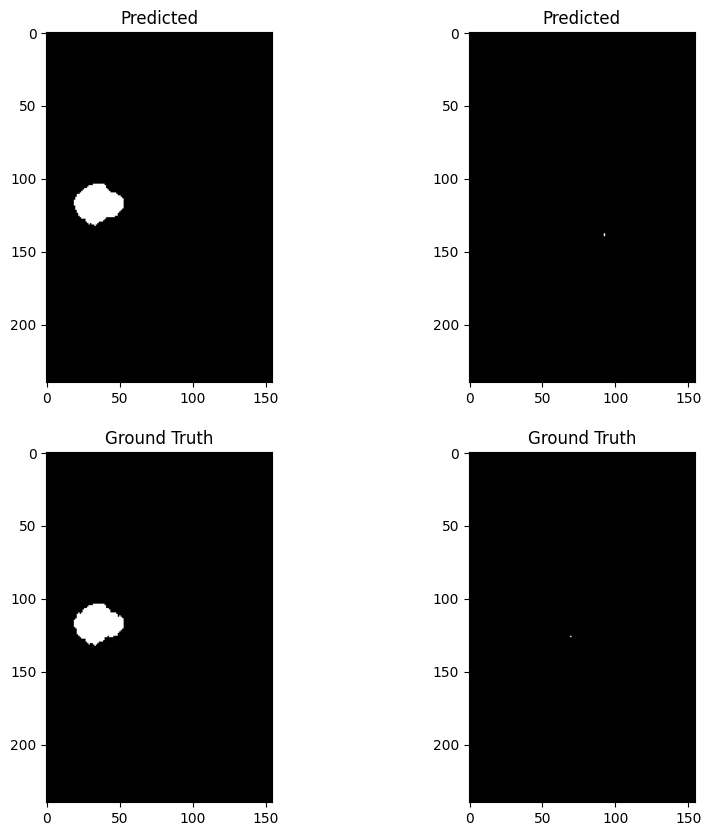

100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


Average Validation Loss: 0.006067658915223244

Average Validation DSC: [0.99946351 0.94647735 0.95249057 0.85483919]
Average Validation ASSD: [ 0.05345094  4.69725523  8.14169997 14.68376953]
Epoch 100/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


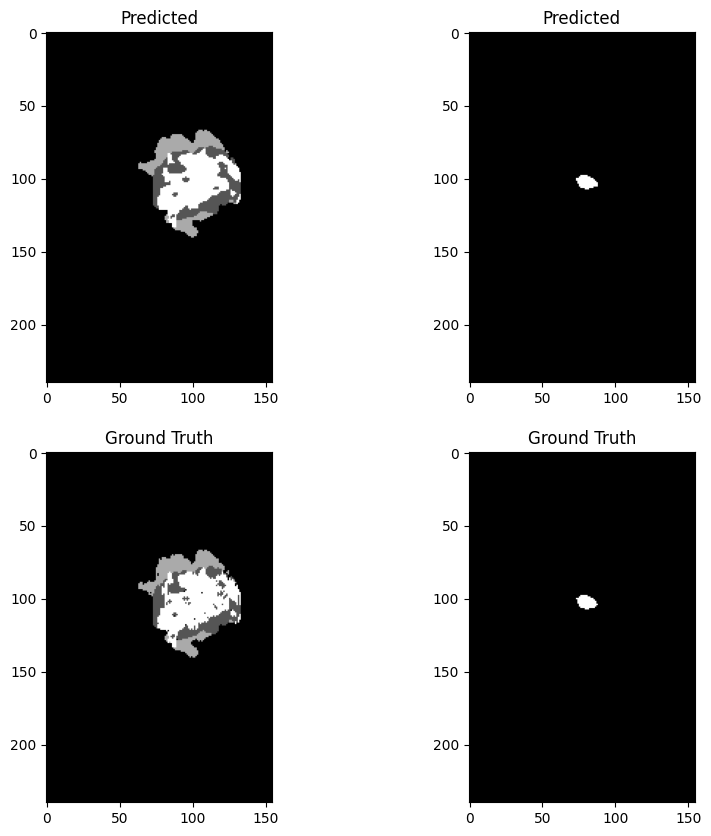

100%|██████████| 189/189 [03:26<00:00,  1.09s/it]



Average Training Loss: 0.002942547654220588

Average Training DSC: [0.99967818 0.96717395 0.97508049 0.90842857]
Average Training ASSD: [0.02665682 2.11511588 3.06900312 8.70222322]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


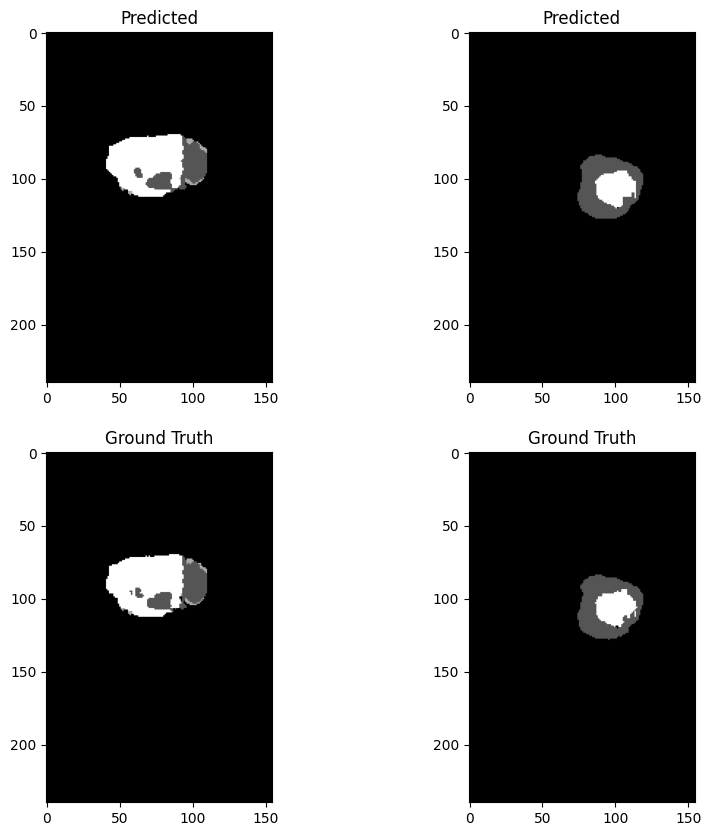

100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Average Validation Loss: 0.00593713199486956

Average Validation DSC: [0.99948273 0.95383181 0.95327067 0.86901717]
Average Validation ASSD: [ 0.05082767  3.72730014  7.20739315 11.34938394]


In [11]:
model = train_model(num_epochs = 100)